<a href="https://colab.research.google.com/github/zhus-dika/togyz-qumalaq-agent/blob/main/togyzqumalaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from IPython.display import clear_output

## Define classes

In [ ]:
class State:
  def __init__(self):
      self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
      self.tuzdyq = [-1, -1]
      self.qazandar = [0, 0]
  def update_state(self, otaular=[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], tuzdyq=[-1, -1], qazandar=[0, 0]):
      self.otaular = otaular
      self.tuzdyq = tuzdyq
      self.qazandar = qazandar
      return self
  def print_state(self):
      print('otaular:', self.otaular, 'tuzdyq:', self.tuzdyq, 'qazandar:', self.qazandar)

In [ ]:
class Action:
    def __init__(self):
        self.start = 0
        self.num_qumalaq = 0
        self.player = 0 #'bastaushy' - 0, 'qostaushy' - 1
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]

    def update_action(self, start, env, player):
        self.start = start
        self.num_qumalaq = env.state.otaular[start]
        self.player = player

    def check_correct_action(self, state):
        otaular = state.otaular
        tuzdyq = state.tuzdyq
        qazandar = state.qazandar
        start = self.start
        num_qumalaq = self.num_qumalaq

        limit = 9
        if start in range(self.player * limit, (self.player + 1) * limit) and tuzdyq[(self.player + 1) % 2] != start and num_qumalaq != 0:
              return True
        return False

    def check_atsyrau(self, state):
        player = self.player
        opponent = (player + 1) % 2
        for idx, i in enumerate(state.otaular[player * 9: (player + 1) * 9]):
            if i > 0 and idx + player * 9 != state.tuzdyq[opponent]:
                return False
        return True

    def distribute_qumalaqs(self, state):
        otaular = state.otaular
        idx = self.direction[self.player].index(self.start)
        if otaular[self.start] == 1:
            otaular[self.direction[self.player][idx + 1]] += 1
            otaular[self.start] -= 1
        else:
            i = 1
            while otaular[self.start] > 1:
                otaular[self.direction[self.player][(idx + i) % 18]] += 1
                otaular[self.start] -= 1
                i += 1
        return state.update_state(otaular=otaular, qazandar=state.qazandar, tuzdyq=state.tuzdyq)

    def add_tuzdyq(self, state):
        tuzdyq = state.tuzdyq
        state.qazandar[self.player] += state.otaular[tuzdyq[self.player]]
        state.otaular[tuzdyq[self.player]] = 0
        return state

    def check_tuzdyq(self, state):
        idx = self.direction[self.player].index(self.start)
        if self.num_qumalaq > 1:
            last_otau = self.direction[self.player][(idx + self.num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[self.player][(idx + self.num_qumalaq) % 18]
        limit = 9
        opponent = (self.player + 1) % 2
        if last_otau in range(opponent * limit, (opponent + 1) * limit) and state.otaular[last_otau] == 3 and last_otau != 17 - self.player * 9 and abs(last_otau - state.tuzdyq[opponent]) != 9:
            state.tuzdyq[self.player] = last_otau
        return state

    def add_qazandar(self, state):
        idx = self.direction[self.player].index(self.start)
        if self.num_qumalaq > 1:
            last_otau = self.direction[self.player][(idx + self.num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[self.player][(idx + self.num_qumalaq) % 18]
        limit = 9
        opponent = (self.player + 1) % 2
        if last_otau in range(opponent * limit, (opponent + 1) * limit) and state.otaular[last_otau] % 2 == 0:
            state.qazandar[self.player] += state.otaular[last_otau]
            state.otaular[last_otau] = 0
        return state

In [ ]:
class Environment:

    def __init__(self):
        self.state = State()
        self.terminated = False

    def reset(self):
        self.state = State()
        self.terminated = False
        return (self.state, self.terminated)

    def step(self, action):
        player = action.player
        init_reward = self.state.qazandar[player]
        # check if action isn't tuzdyq of the env & otaular[action] has any ball
        if action.check_correct_action(self.state):
            self.state = action.distribute_qumalaqs(self.state)
            if self.state.tuzdyq[player] < 0:
                self.state = action.check_tuzdyq(self.state)
            else:
                self.state = action.add_tuzdyq(self.state)
            self.state = action.add_qazandar(self.state)
            if self.state.qazandar[0] > 81 or self.state.qazandar[1] > 81:
                self.terminated = True

            return (self.state, self.state.qazandar[player] - init_reward, self.terminated)

        else:
            self.terminated = True
            if self.state.tuzdyq[player] > 0:
                self.state = action.add_tuzdyq(self.state)
            if action.check_atsyrau(self.state):
                print(f'Player {player} reaches atsyrau. No actions avalable.')
                opponent = (player + 1) % 2
                reward = 0
                for i in self.state.otaular[opponent * 9: (opponent + 1) * 9]:
                      reward += i
                self.state.qazandar[opponent] += reward
            else:
                print(f'Action {(action.start, action.player)} is not applicable for state {(self.state.otaular, self.state.tuzdyq, self.state.qazandar)}')
            return (self.state, 0, self.terminated)

    def render(self):

        points_bastaushy_x = np.array([i * 2 for i in range(10)])
        points_bastaushy_y = np.array([i % 5 for i in range(50)])

        x = np.arange(-3, 225, 1)
        y = -1

        text_kwargs = dict(ha='center', va='center', fontsize=12)
        plt.figure(figsize=(17, 6))

        for i in range(9):
            # qostaushy's part
            plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.state.otaular[17 - i]], points_bastaushy_y[:self.state.otaular[17 - i]], marker='o')
            # horizontal line
            plt.plot(x, np.repeat(y, len(x)))
            # vertical lines
            plt.plot(np.repeat(25 * i - 2, len(x)), np.arange(-7, 5, 12 / len(x)))
            # bastaushy's part
            plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.state.otaular[i]], points_bastaushy_y[:self.state.otaular[i]] - 6, marker='o')

        #last vertical line
        plt.plot(np.repeat(25 * 9 - 2, len(x)), np.arange(-7, 5, 12 / len(x)))

        for i in range(9):
            # bastaushy's qumalaqtar
            plt.text(25 * i + 10, -7, f'{i} ({self.state.otaular[i]})', **text_kwargs)
            # qostaushy's qumalaqtar
            plt.text(25 * i + 10, 5, f'{17 - i} ({self.state.otaular[17 - i]})', **text_kwargs)
        # bastaushy qazan's qumalaqtar
        plt.text(230, -4, f'qazan: {self.state.qazandar[0]}', **text_kwargs)
        # qostaushy qazan's qumalaqtar
        plt.text(230, 2, f'qazan: {self.state.qazandar[1]}', **text_kwargs);
        # bastaushy tuzdyq's qumalaqtar
        plt.text(230, -6, f'tuzdyq: {self.state.tuzdyq[0]}', **text_kwargs)
        # qostaushy tuzdyq's qumalaqtar
        plt.text(230, 0, f'tuzdyq: {self.state.tuzdyq[1]}', **text_kwargs);
        plt.show()

## Check correctness

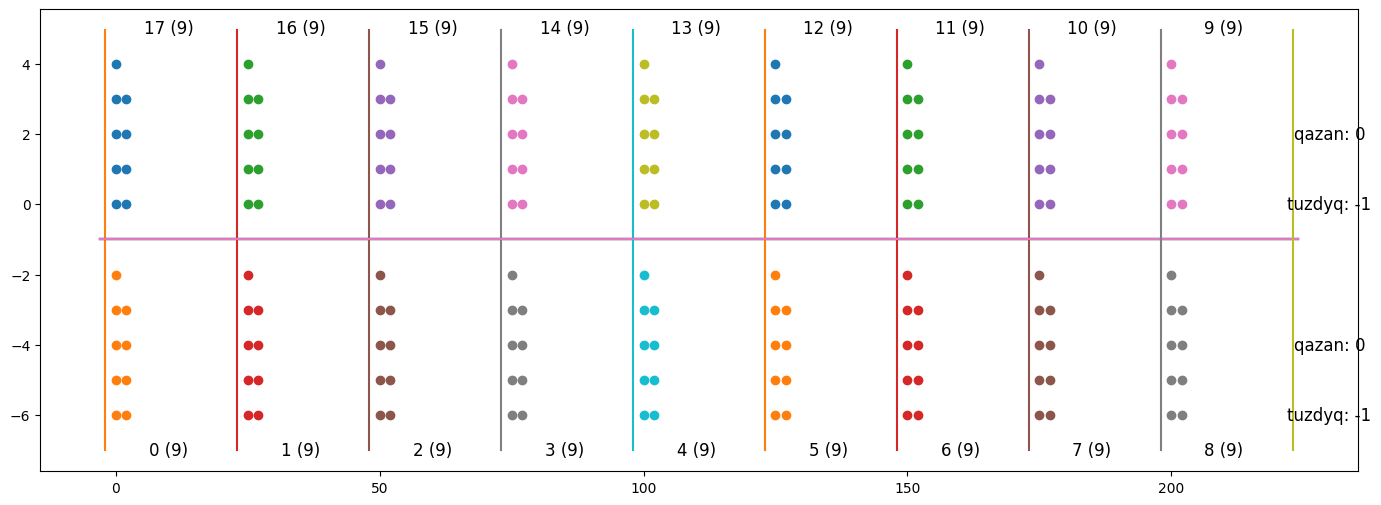

In [ ]:
env = Environment()
env.render()

### Check qazan & tuzdyq calculations

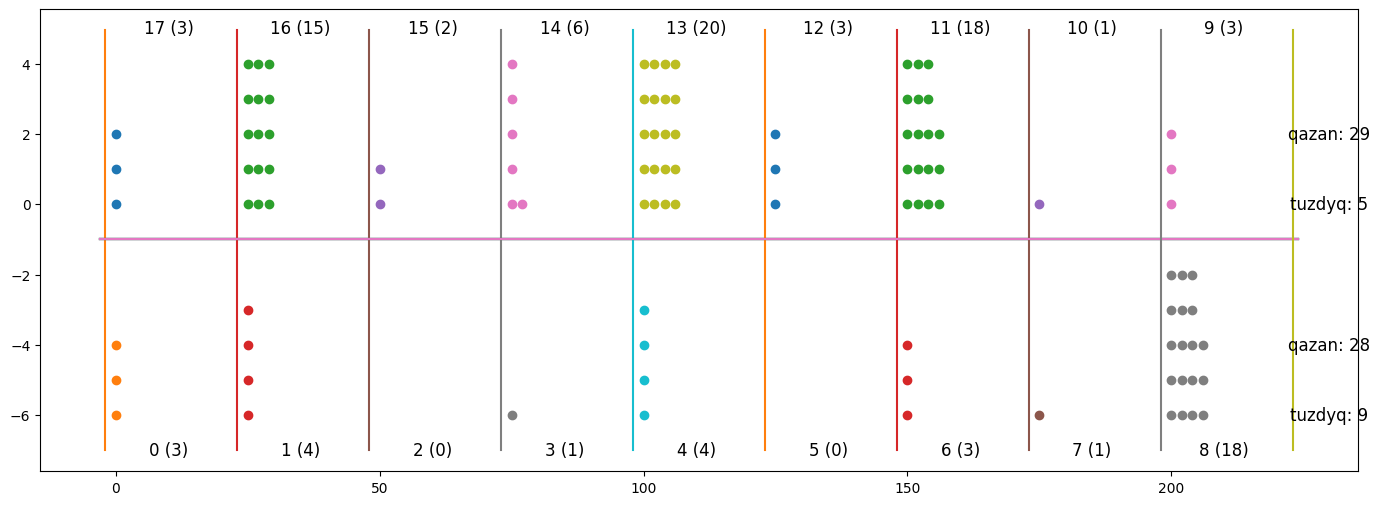

In [ ]:
action = Action()

actions = [1, 10, 5, 15, 7, 12, 4, 14, 6, 10, 7, 12, 2, 9, 2, 12, 3, 10, 7]

env.reset()
for i in range(len(actions)):
    action.update_action(start=actions[i], env=env, player=i%2)
    env.step(action=action)
    env.render()
    time.sleep(2)
    clear_output(True)

In [ ]:
def get_sample_action(player, state):
    opponent = (player + 1) % 2
    samples = []
    for idx, i in enumerate(state.otaular[player * 9: (player + 1) * 9]):

        if i > 0 and idx + player * 9 != state.tuzdyq[opponent]:
            samples.append(idx + player * 9)

    if len(samples) > 0:
        random.shuffle(samples)
        return samples[0]
    else:
        return -1

In [ ]:
get_sample_action(0, env.state)

3

## Play with sample policies

#55 --> Player 0 make action 5


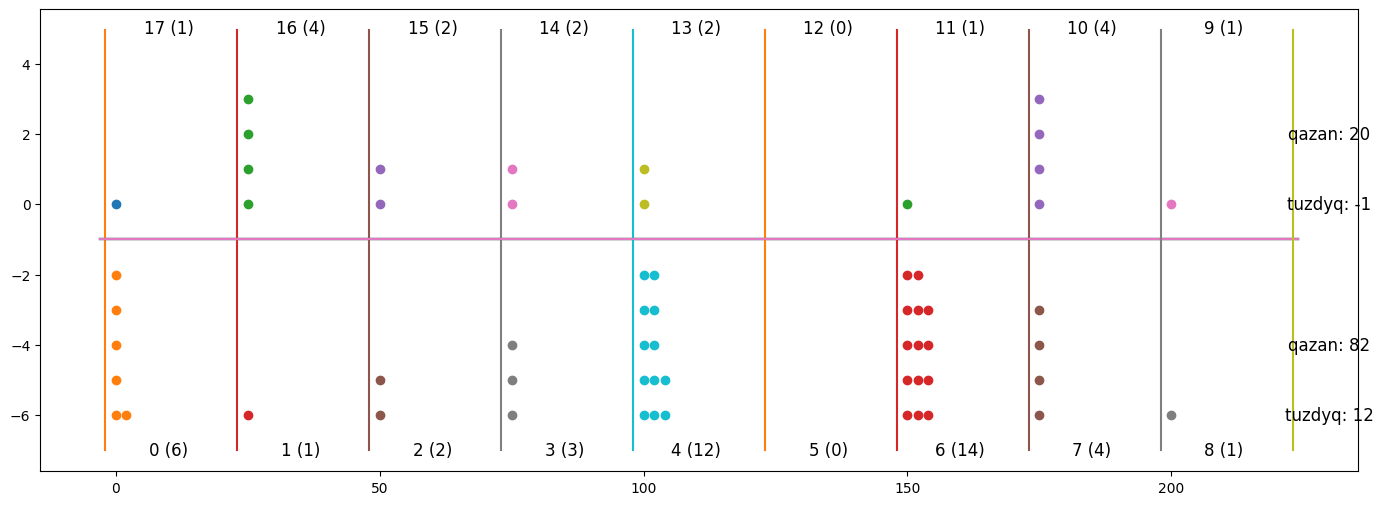

Game over!


In [ ]:
action = Action()


env.reset()
for i in range(150):
    player = i % 2
    new_action = get_sample_action(player, env.state)
    print(f'#{i + 1} --> Player {player} make action {new_action}')
    action.update_action(start=new_action, env=env, player=player)
    new_state, reward, terminated = env.step(action=action)
    env.render()
    if terminated:
        print(f'Game over!')
        break
    #time.sleep(2)
    clear_output(True)

## DQN

In [ ]:
import torch
%matplotlib inline
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [ ]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.network = nn.Sequential(
            nn.Linear(18 + 2 + 2, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, self.n_actions)
        )

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        """
        # Use your network to compute qvalues for given state
        qvalues = self.network(state_t)
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == self.n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        state_flatten = np.array([state.otaular + state.tuzdyq + state.qazandar for state in states])
        state_t = torch.tensor(state_flatten, device=model_device, dtype=torch.float)
        qvalues = self.forward(state_t)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, states, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        player = 0
        opponent = 1
        random_actions = []
        qvalues_selected = []
        best_actions = []
        for n, state in enumerate(states):
            samples = []
            for idx, i in enumerate(state.otaular[player * 9: (player + 1) * 9]):
                if i > 0 and idx + player * 9 != state.tuzdyq[opponent]:
                    samples.append(idx + player * 9)
            if len(samples) > 0:
                random_actions.append(np.random.choice(samples))
                qvalues_selected = qvalues[n][np.array(samples) - player * 9]
                best_actions.append(samples[qvalues_selected.argmax(axis=-1)])
            else:
                random_actions.append(-1)
                best_actions.append(-1)

        random_actions = np.array(random_actions)
        best_actions = np.array(best_actions)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [ ]:
state_shape = (22,)
n_actions = 9
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)
action = Action()

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            start = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions([s], qvalues)[0]

            action.update_action(start=start, env=env, player=0)
            print(f'Player 0 make action {start}')
            env.render()
            inter_s, r, terminated = env.step(action)
            reward += r
            if terminated:
                break

            new_start = get_sample_action(1, inter_s)
            action.update_action(start=new_start, env=env, player=1)
            print(f'Player 1 make action {new_start}')
            env.render()
            s, r_env, terminated = env.step(action)
            if terminated:
                break
            reward += r - r_env
            print(f'Player 0 wins {r - r_env}.')
        rewards.append(reward)
    env.render()
    return np.mean(rewards)

Player 0 make action 1


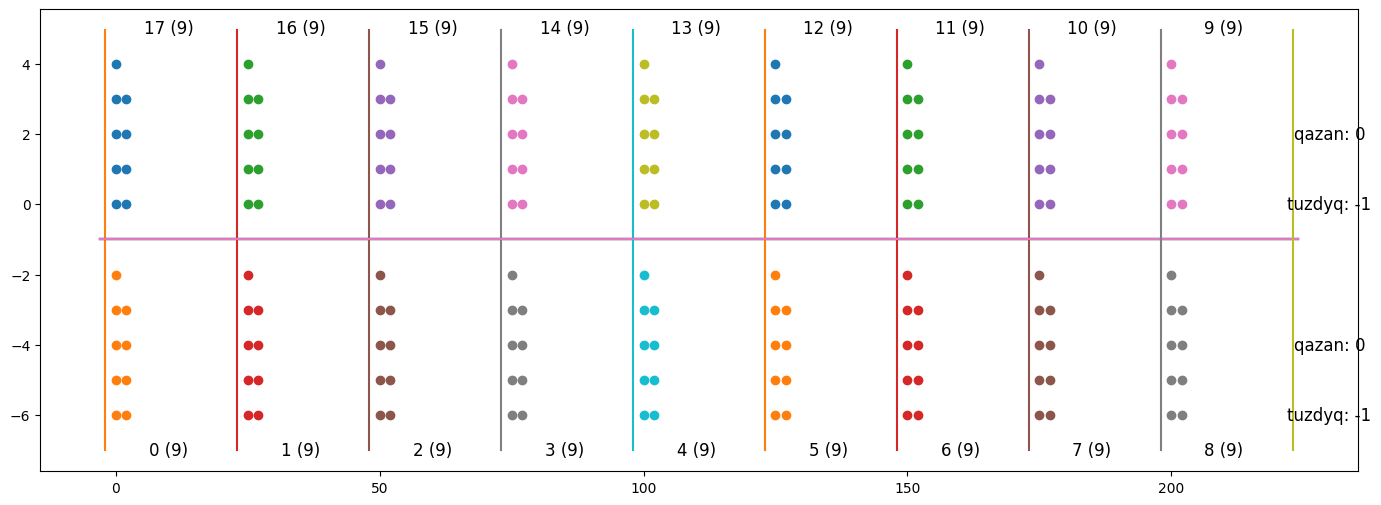

Player 1 make action 11


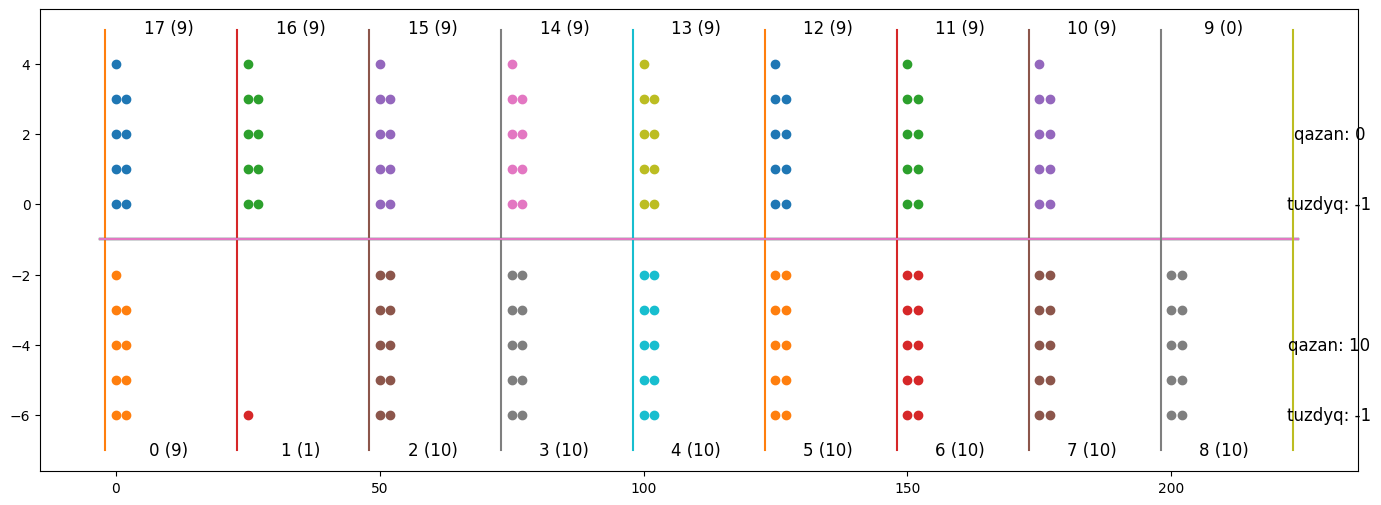

Player 0 wins 8.
Player 0 make action 5


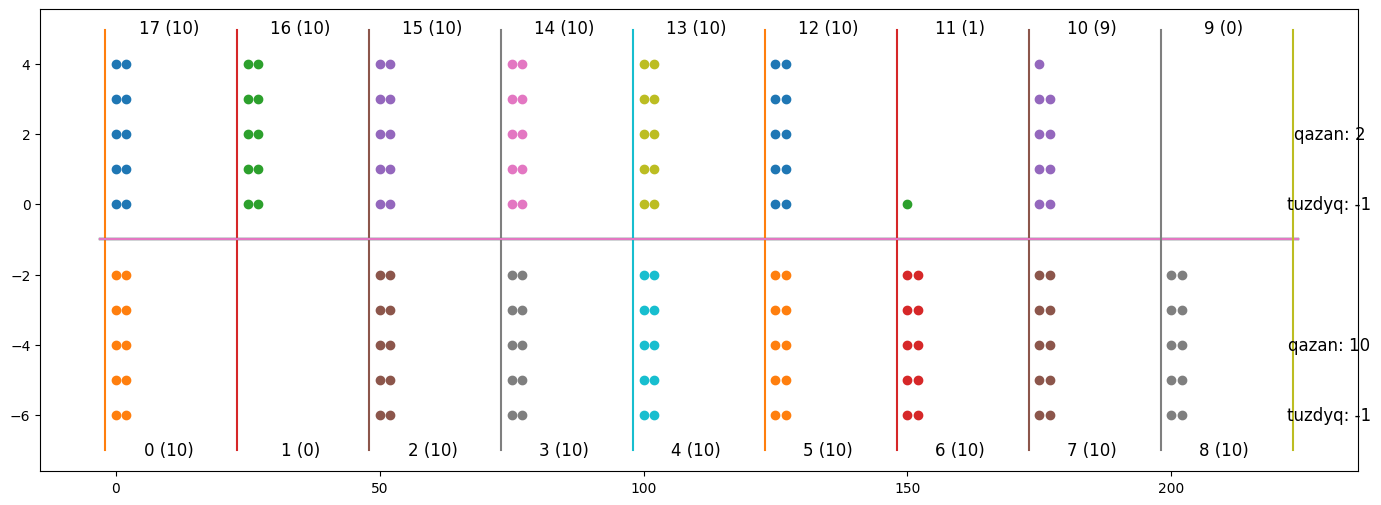

Player 1 make action 15


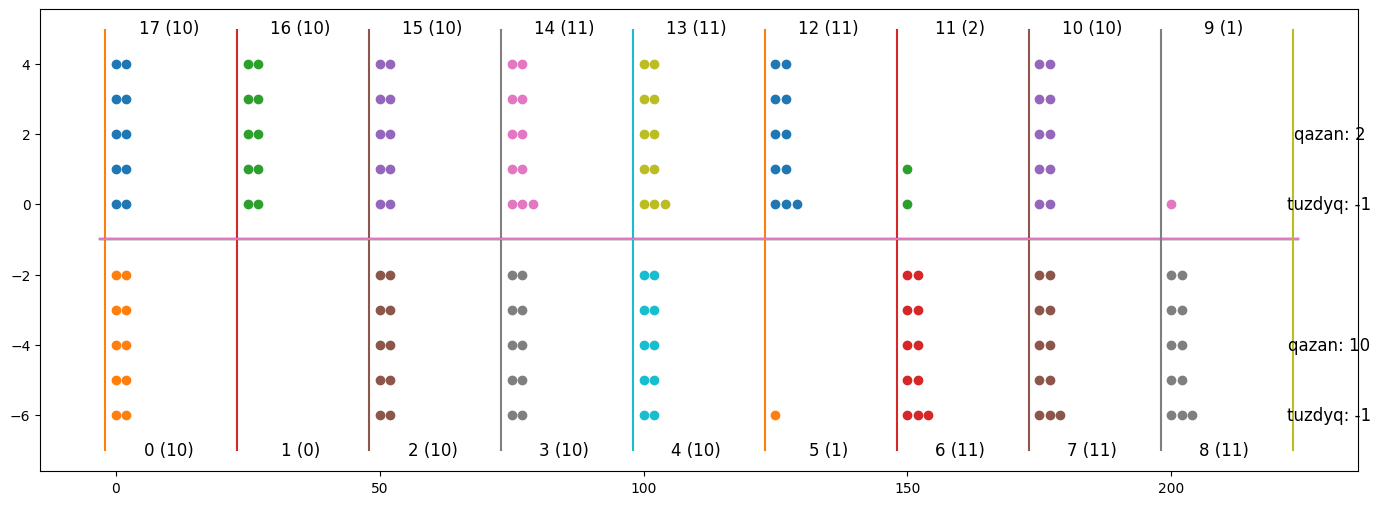

Player 0 wins -12.
Player 0 make action 1


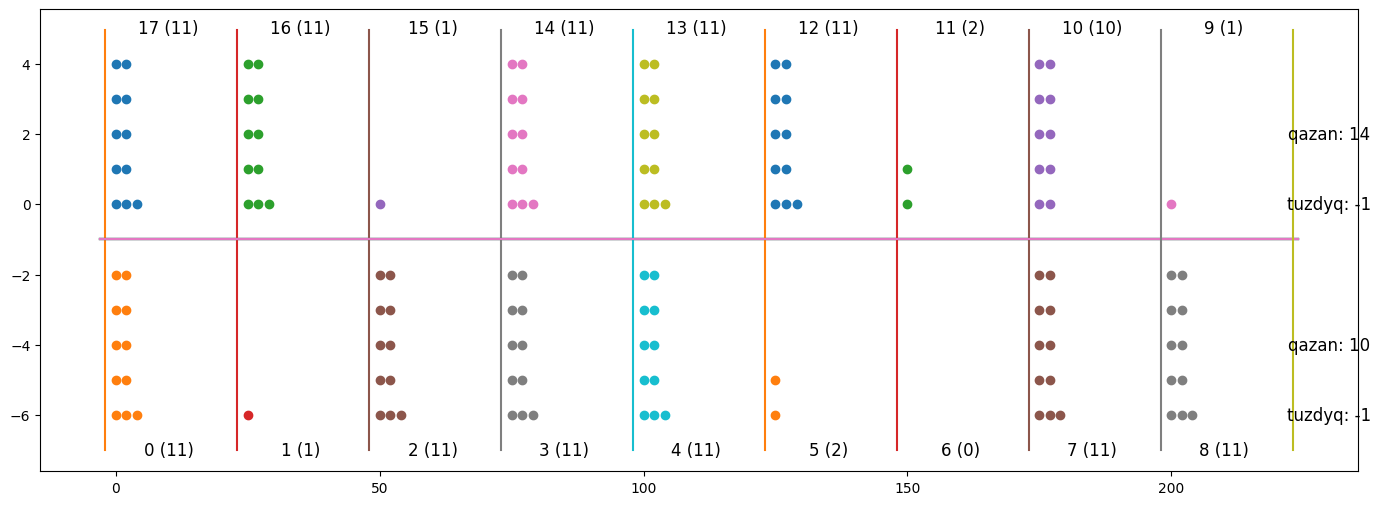

Player 1 make action 10


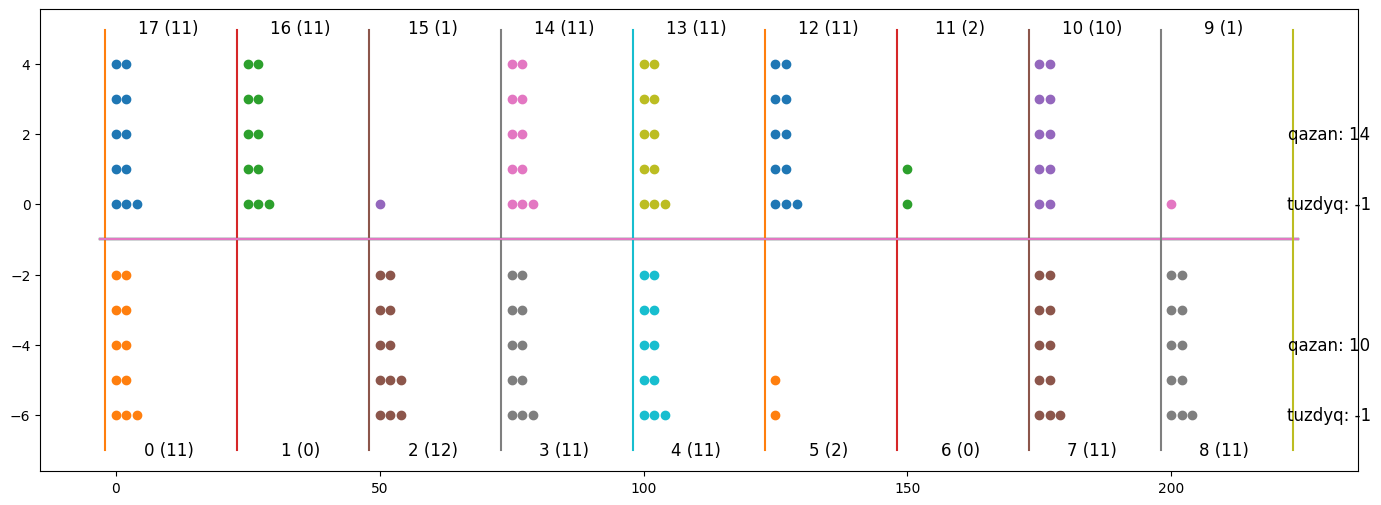

Player 0 wins 0.
Player 0 make action 3


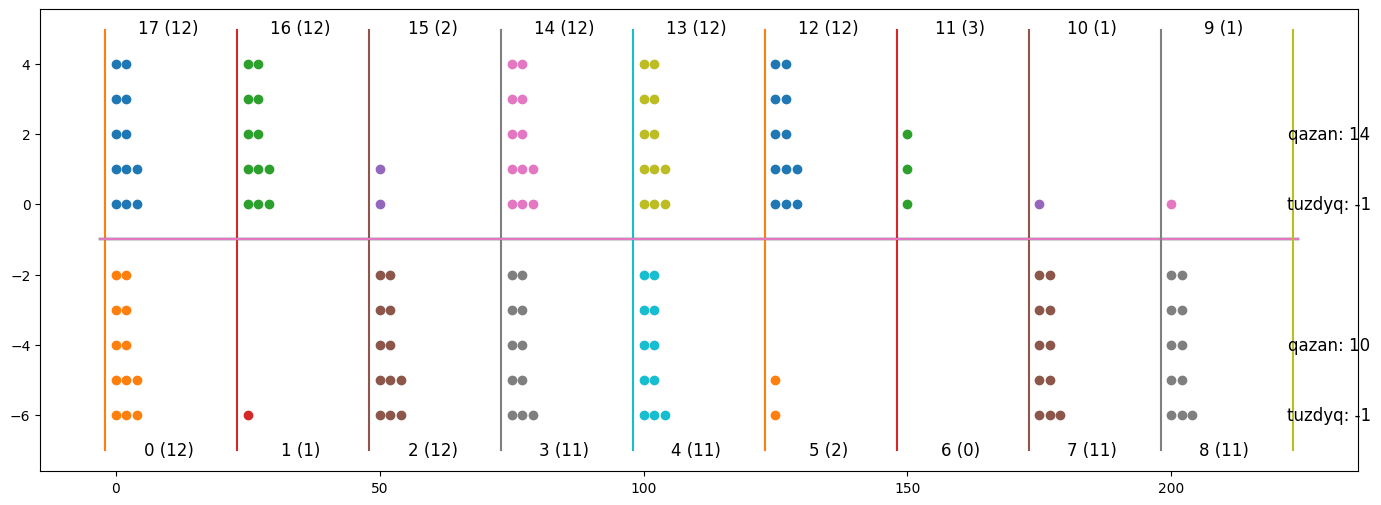

Player 1 make action 12


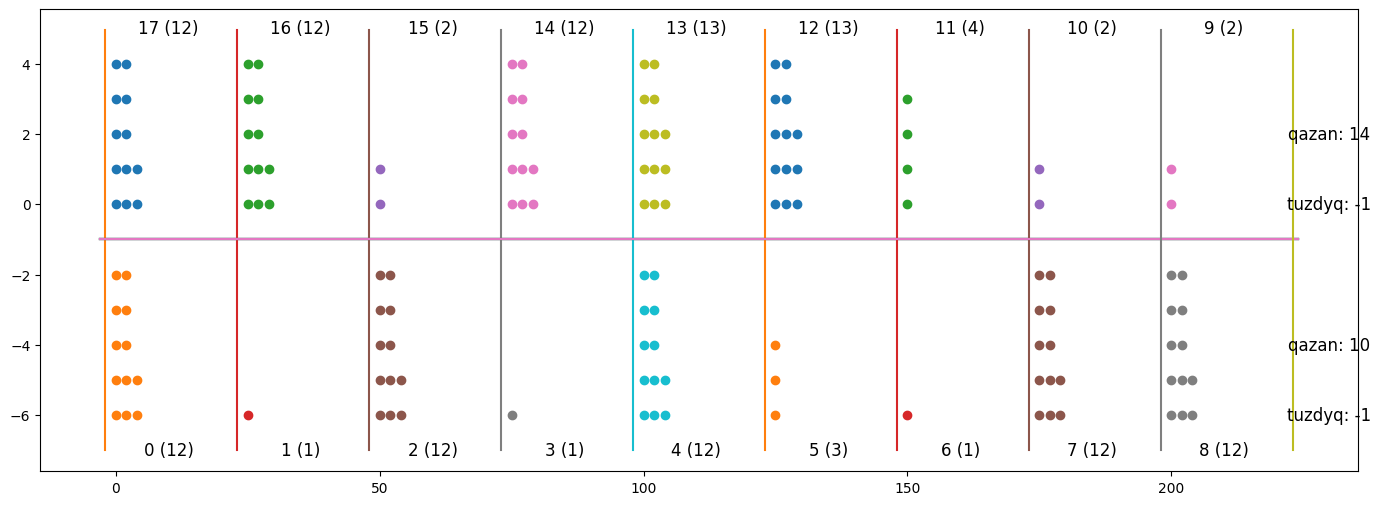

Player 0 wins -2.
Player 0 make action 4


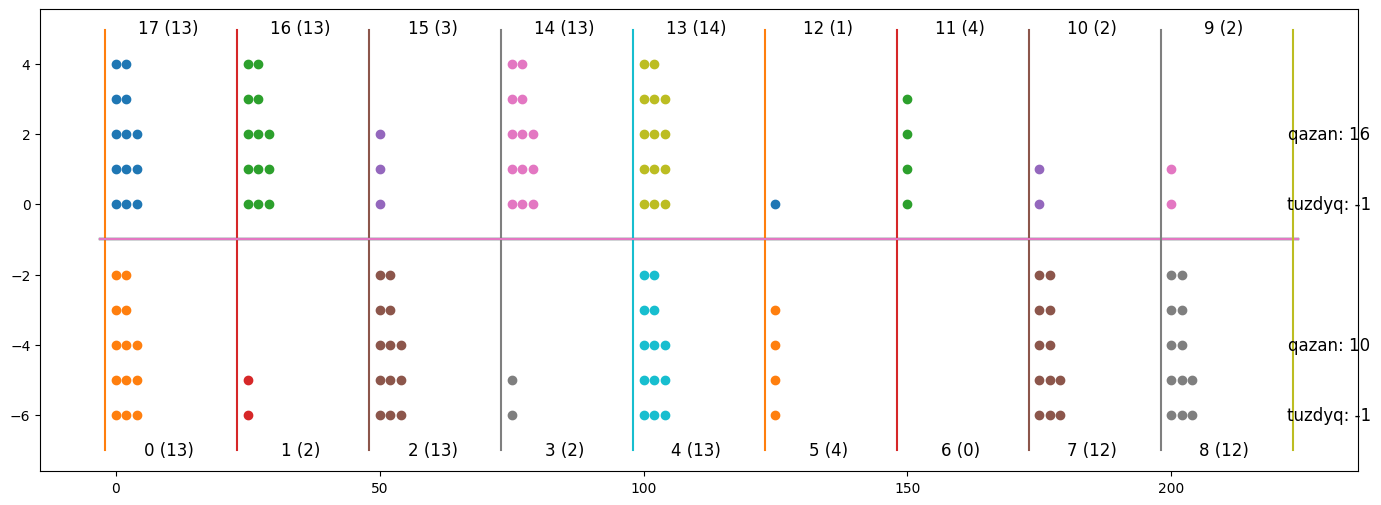

Player 1 make action 11


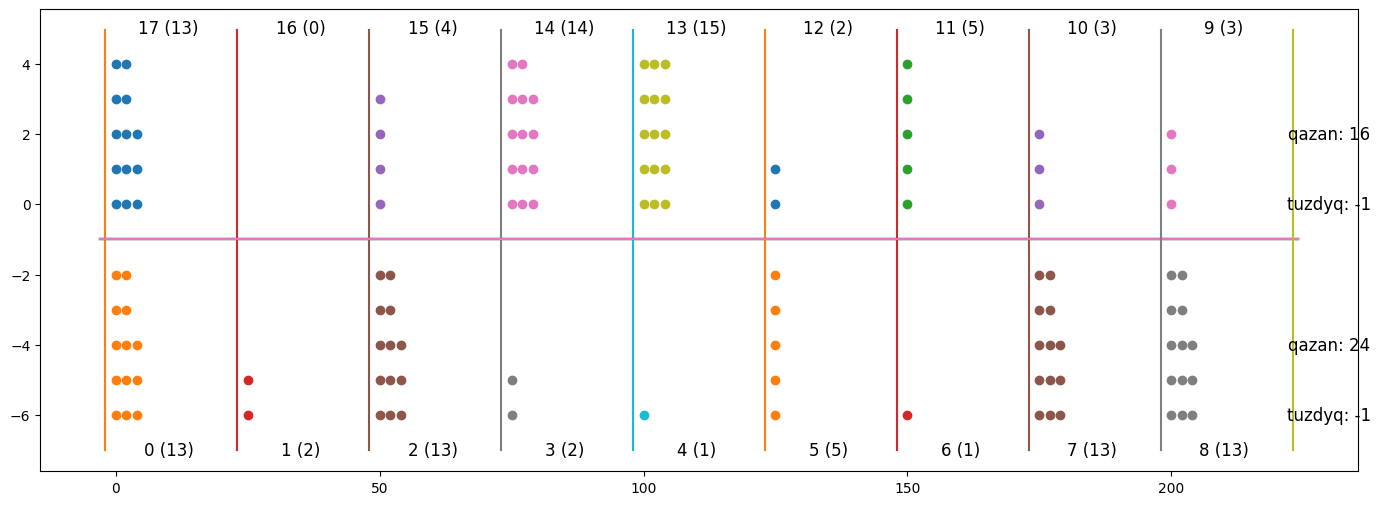

Player 0 wins 14.
Player 0 make action 1


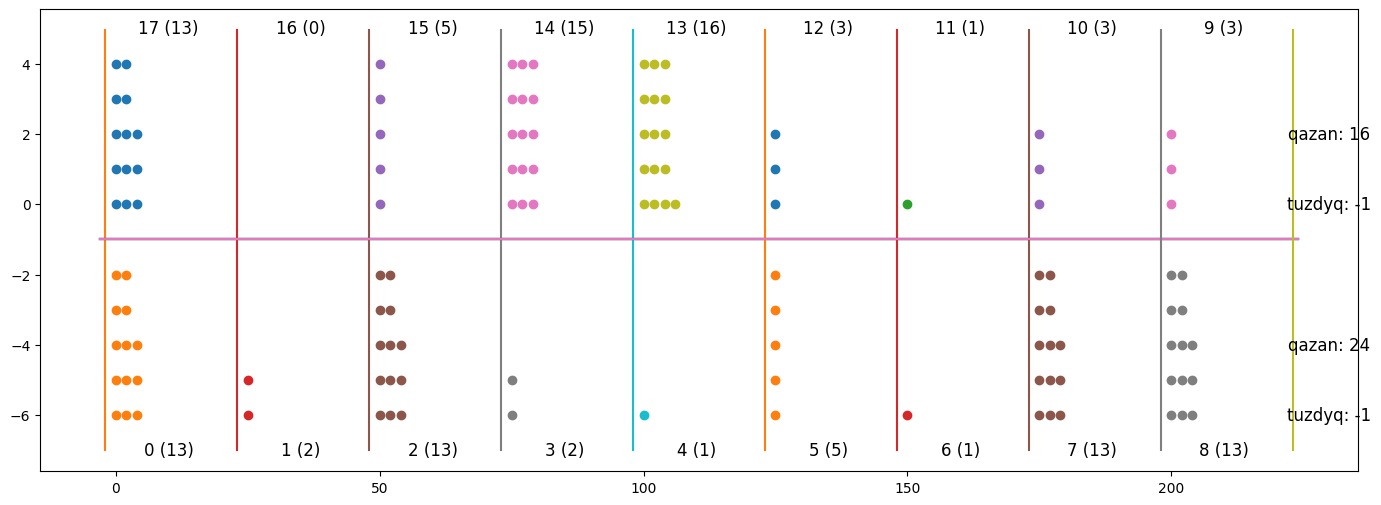

Player 1 make action 11


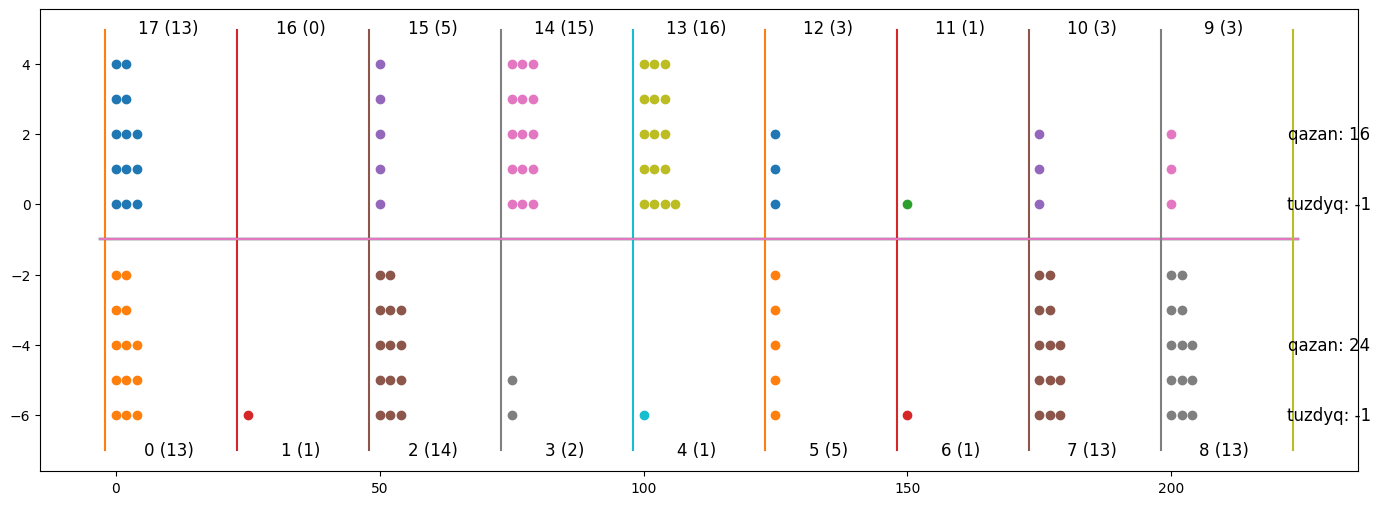

Player 0 wins 0.
Player 0 make action 1


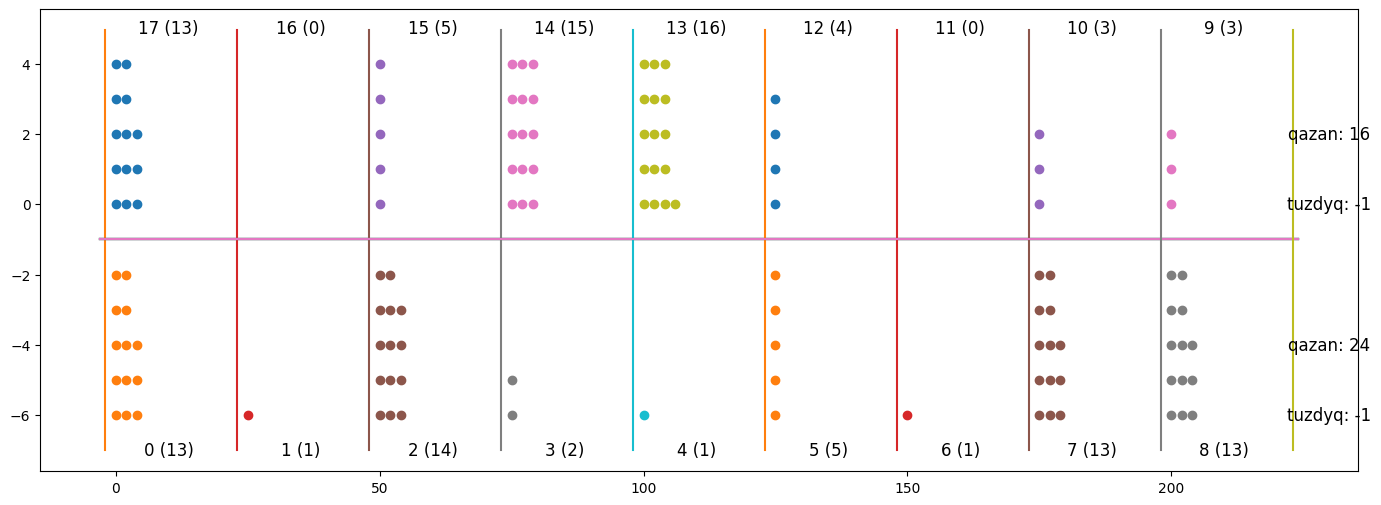

Player 1 make action 9


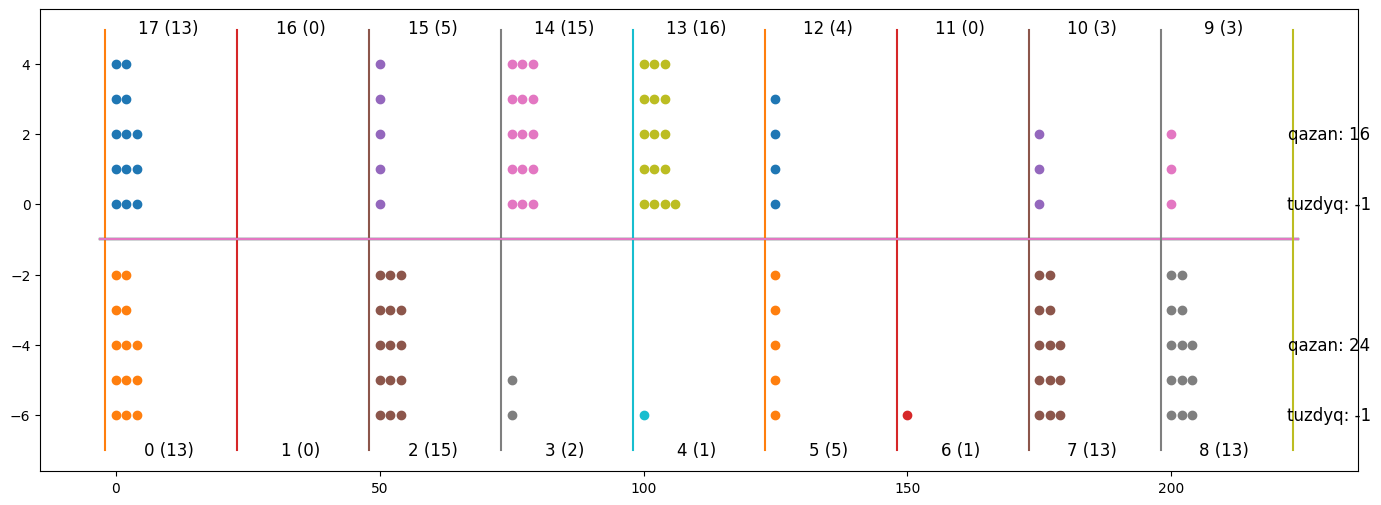

Player 0 wins 0.
Player 0 make action 5


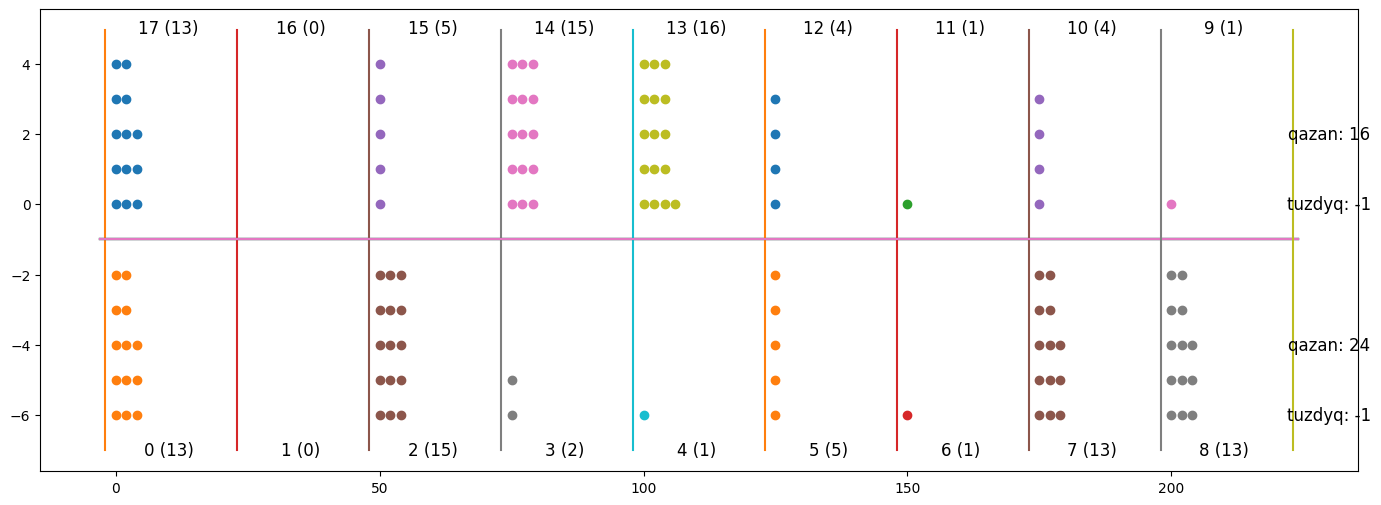

Player 1 make action 15


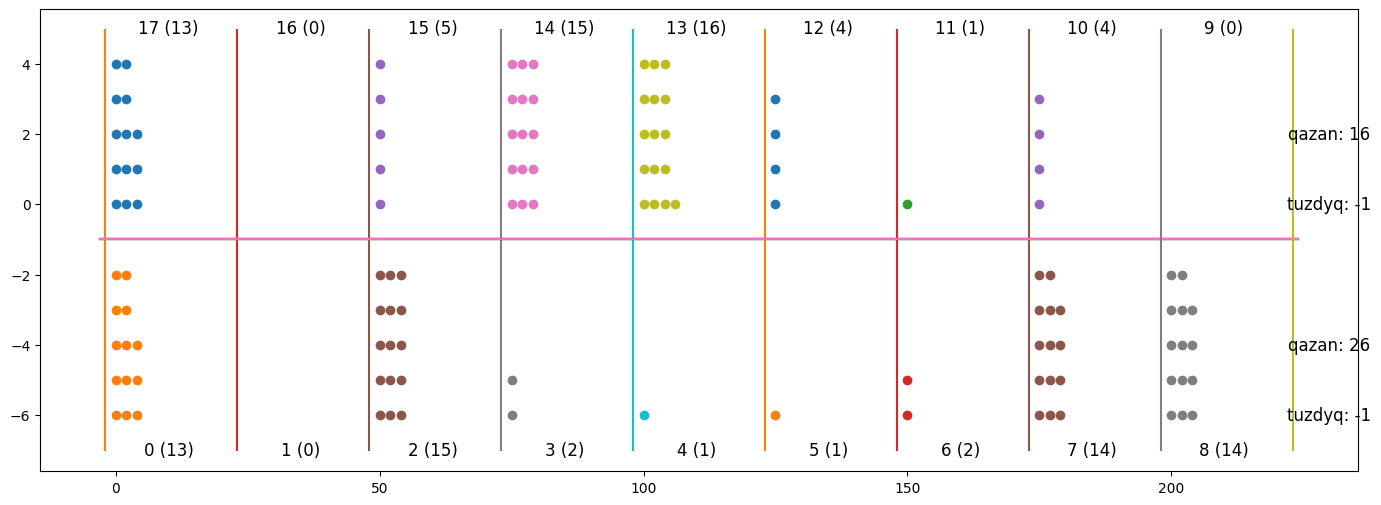

Player 0 wins 2.
Player 0 make action 1


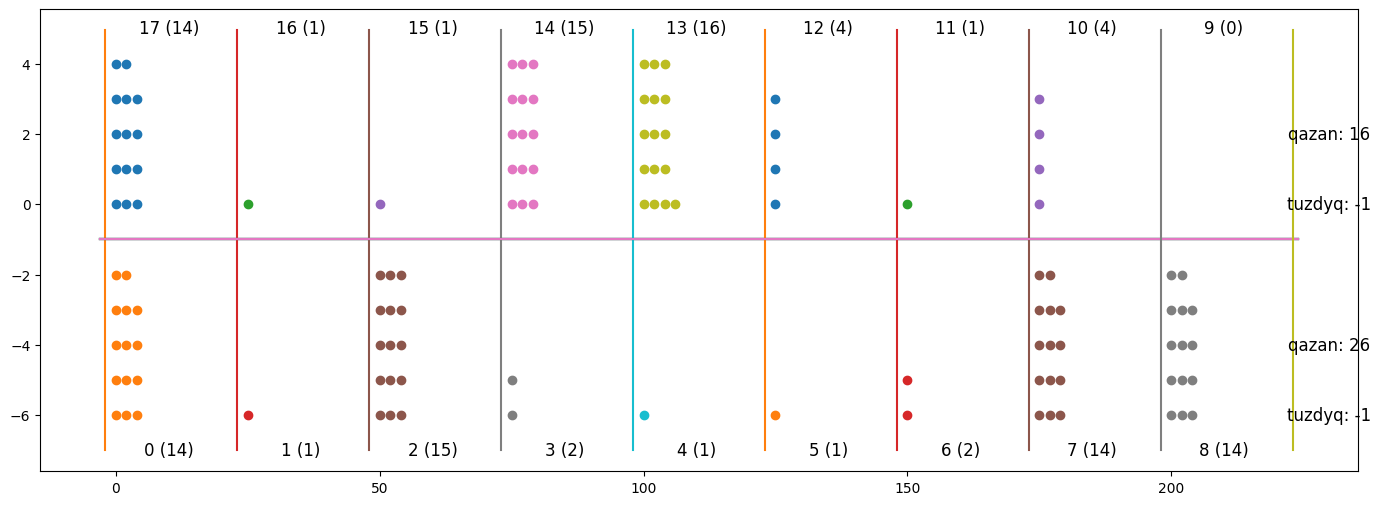

Player 1 make action 10


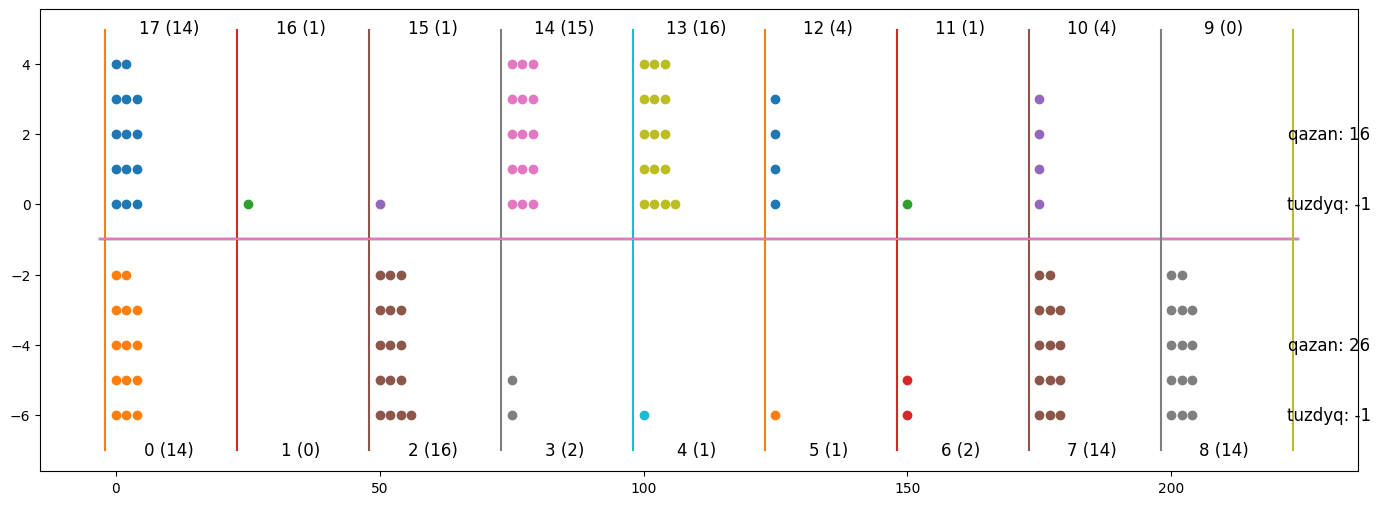

Player 0 wins 0.
Player 0 make action 2


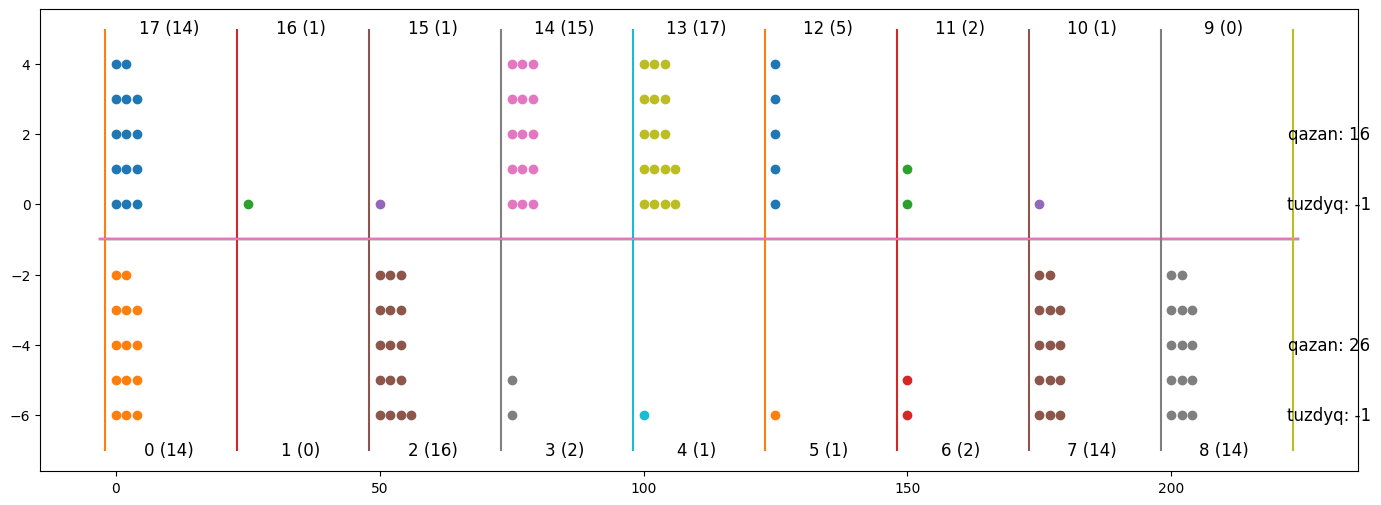

Player 1 make action 14


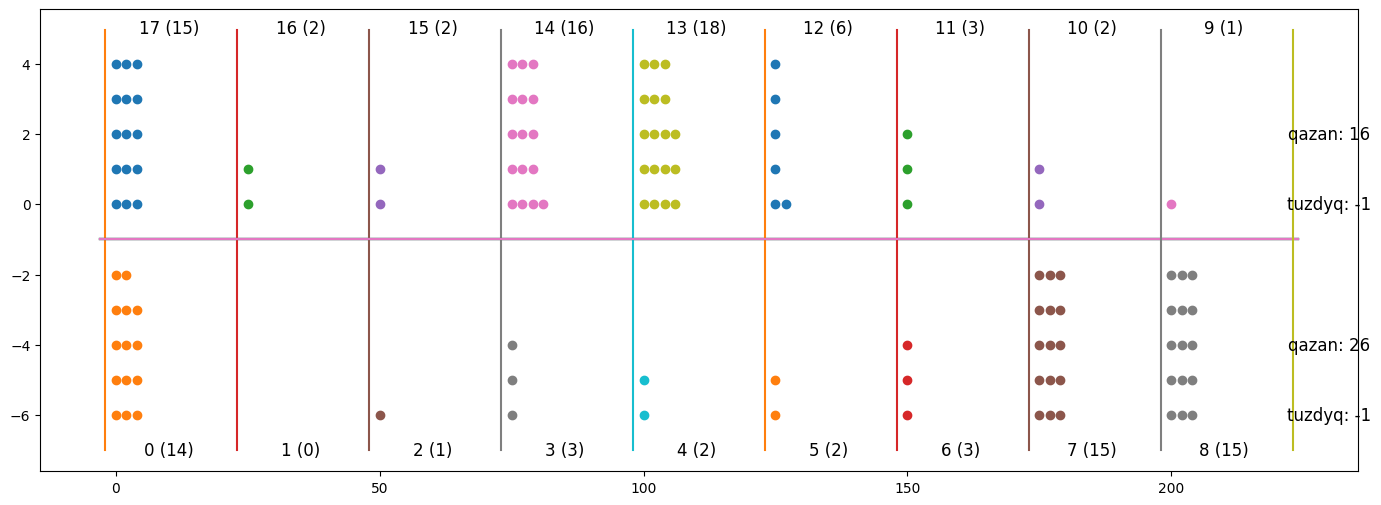

Player 0 wins 0.
Player 0 make action 4


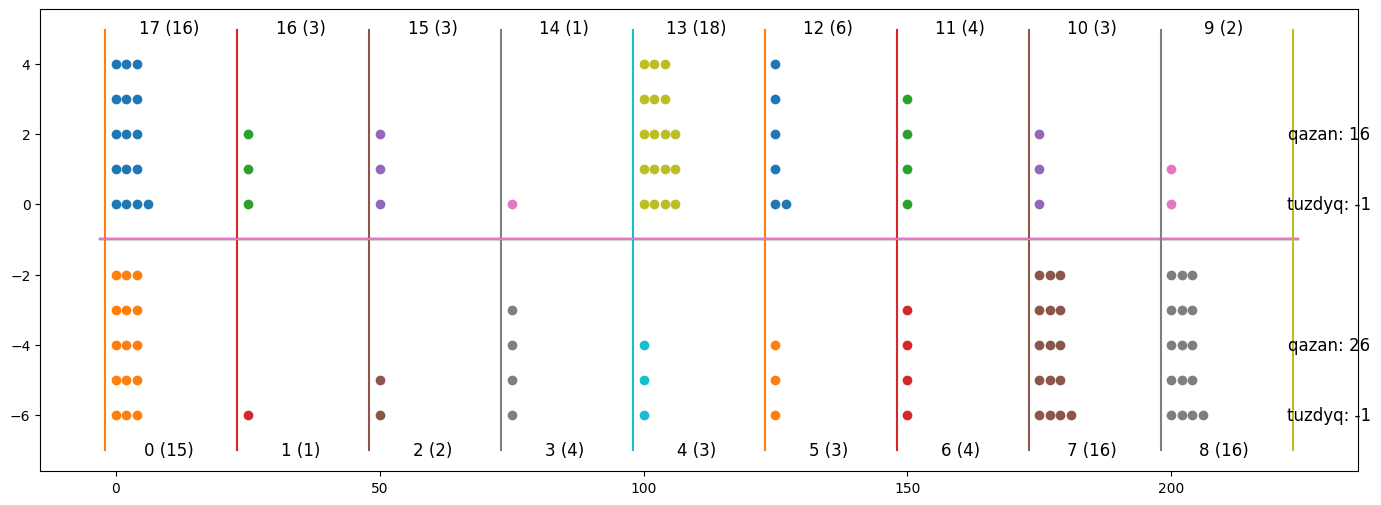

Player 1 make action 11


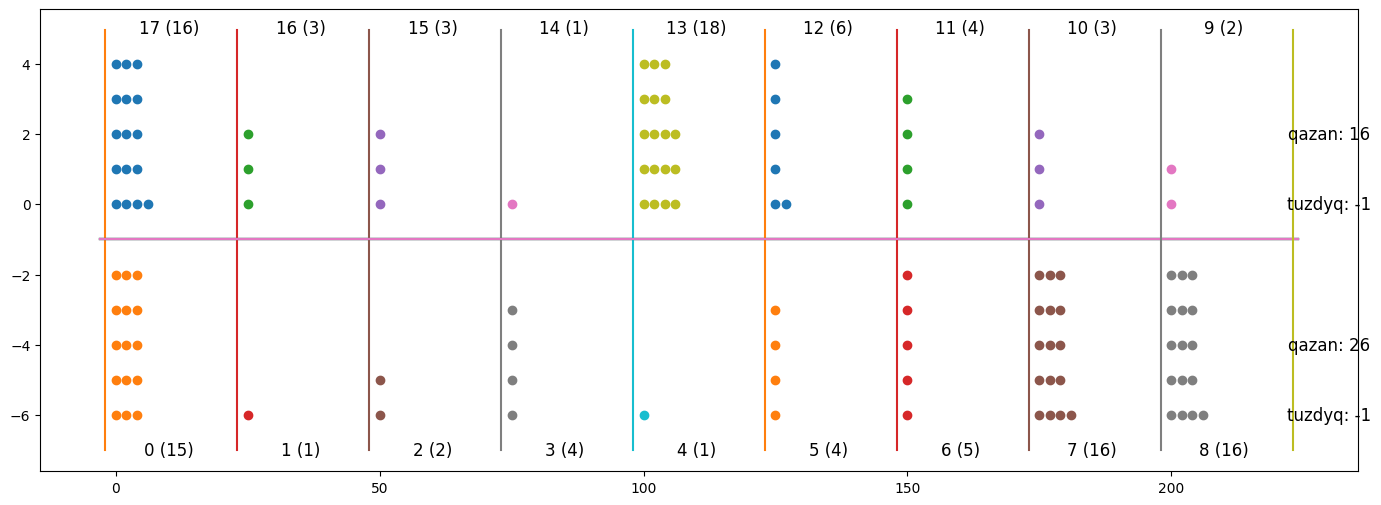

Player 0 wins 0.
Player 0 make action 5


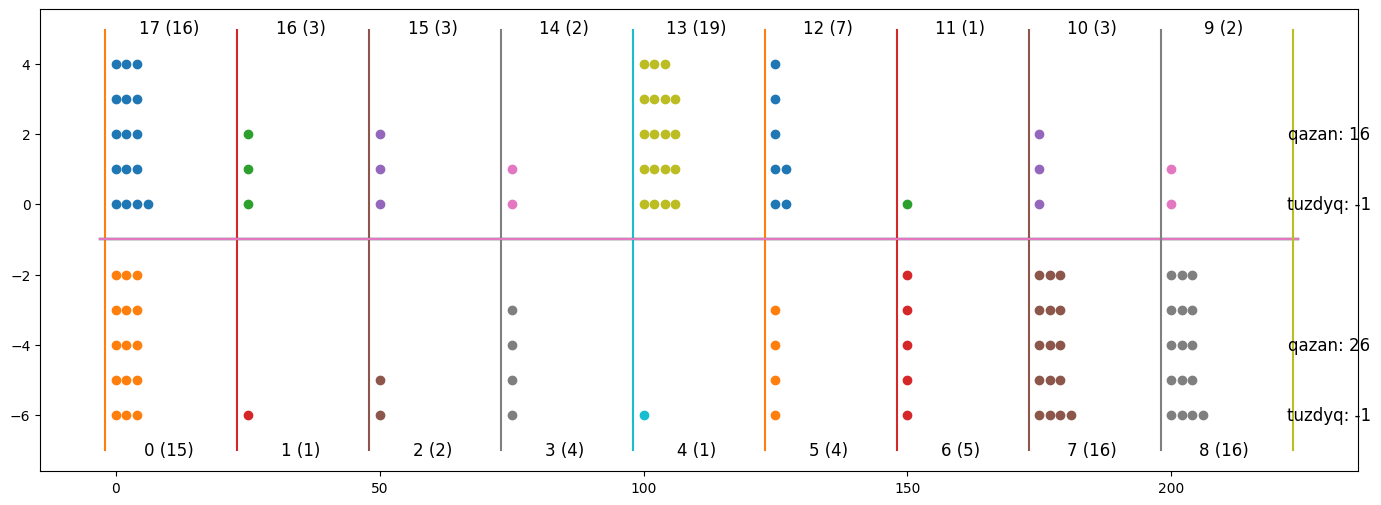

Player 1 make action 17


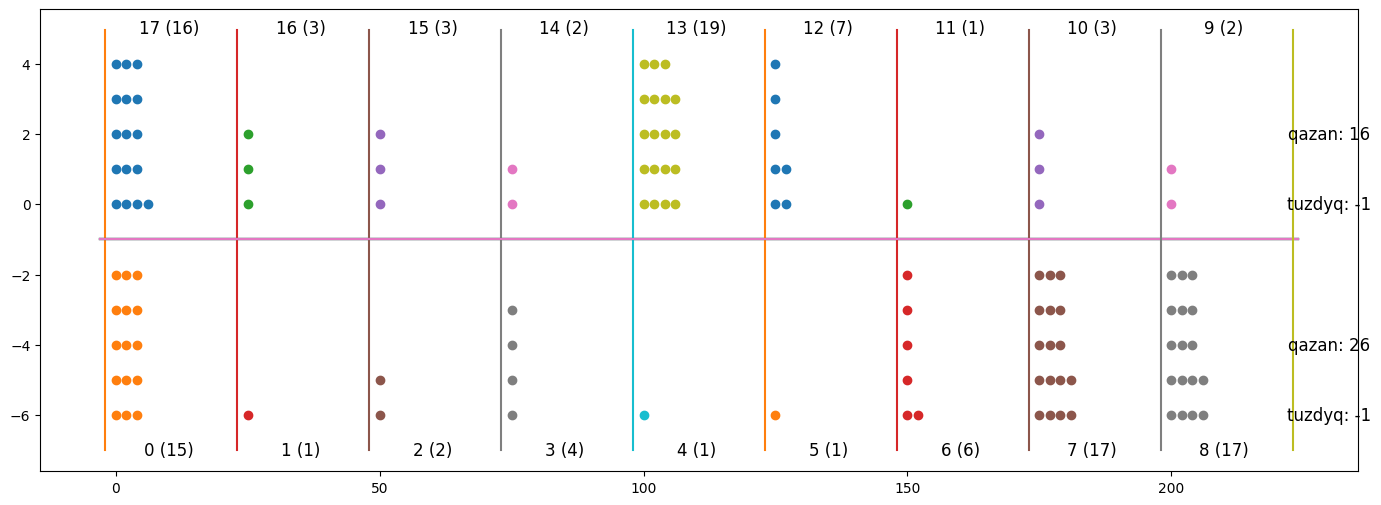

Player 0 wins 0.
Player 0 make action 0


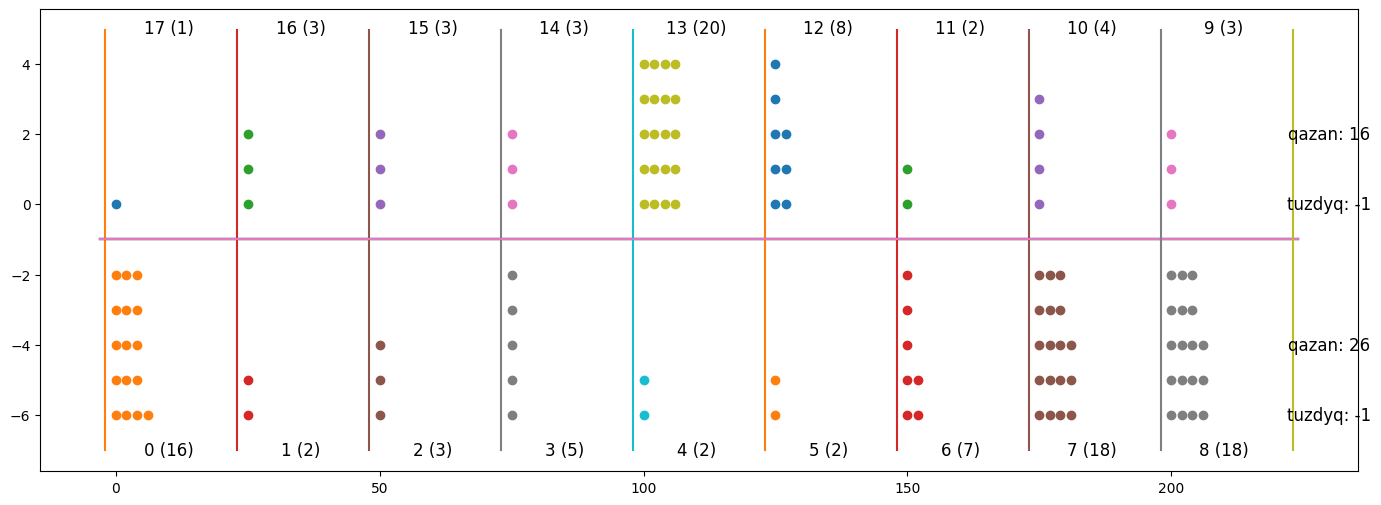

Player 1 make action 10


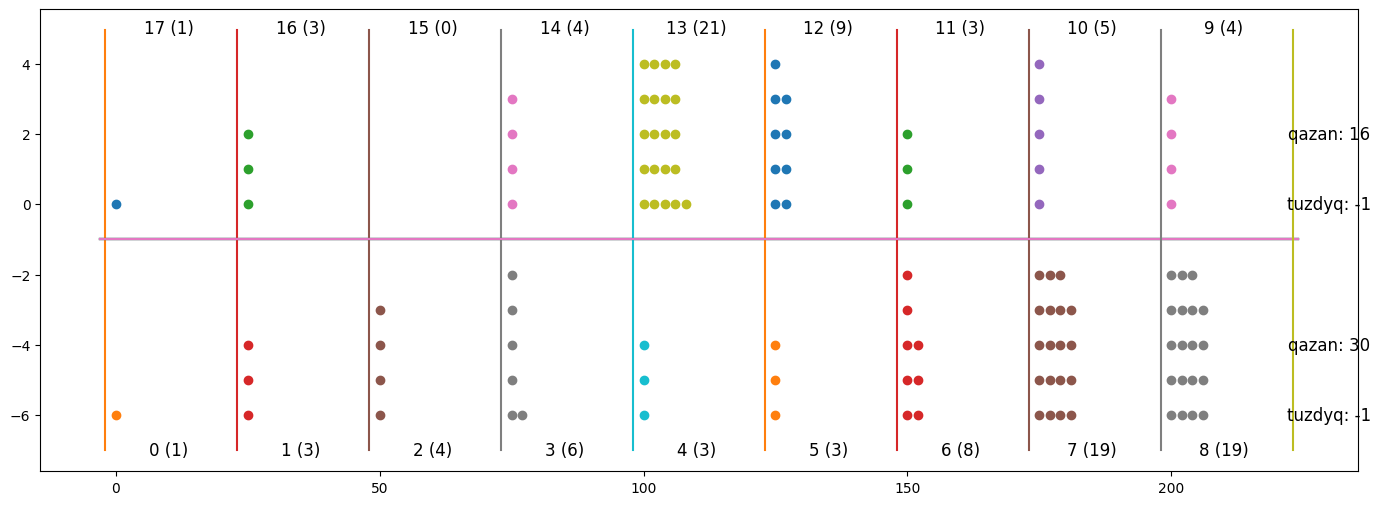

Player 0 wins 4.
Player 0 make action 0


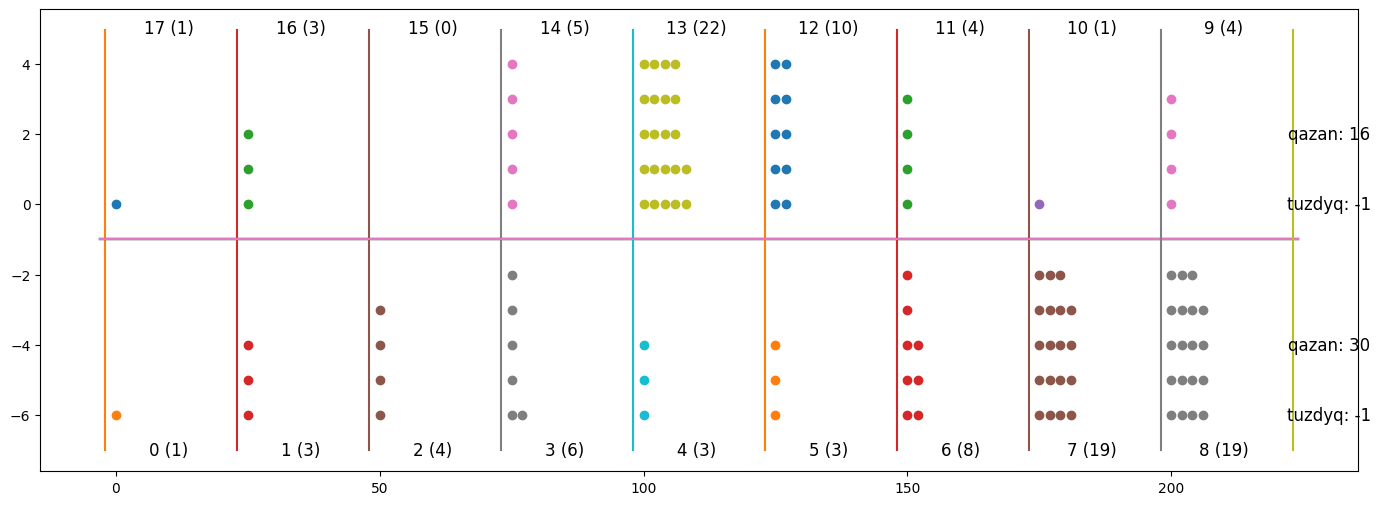

Player 1 make action 13


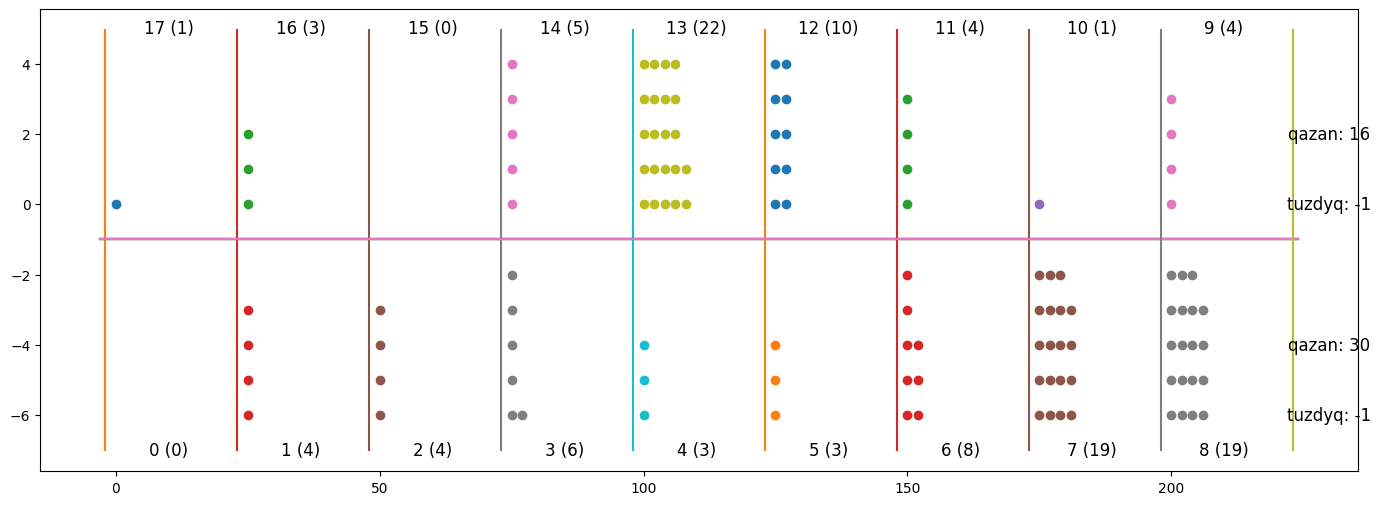

Player 0 wins 0.
Player 0 make action 4


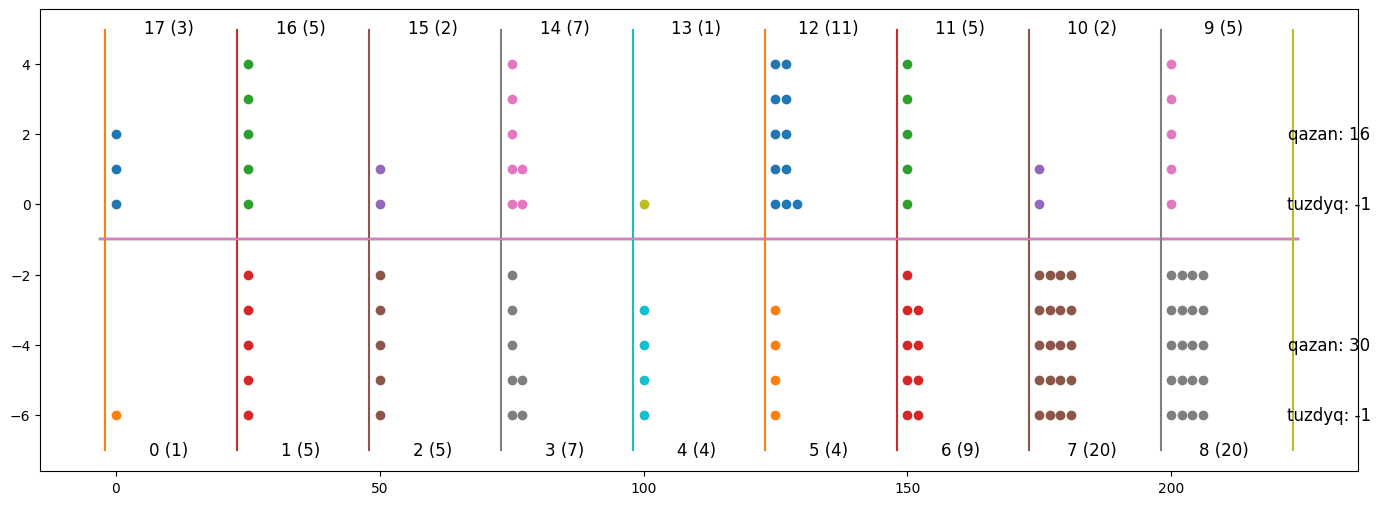

Player 1 make action 17


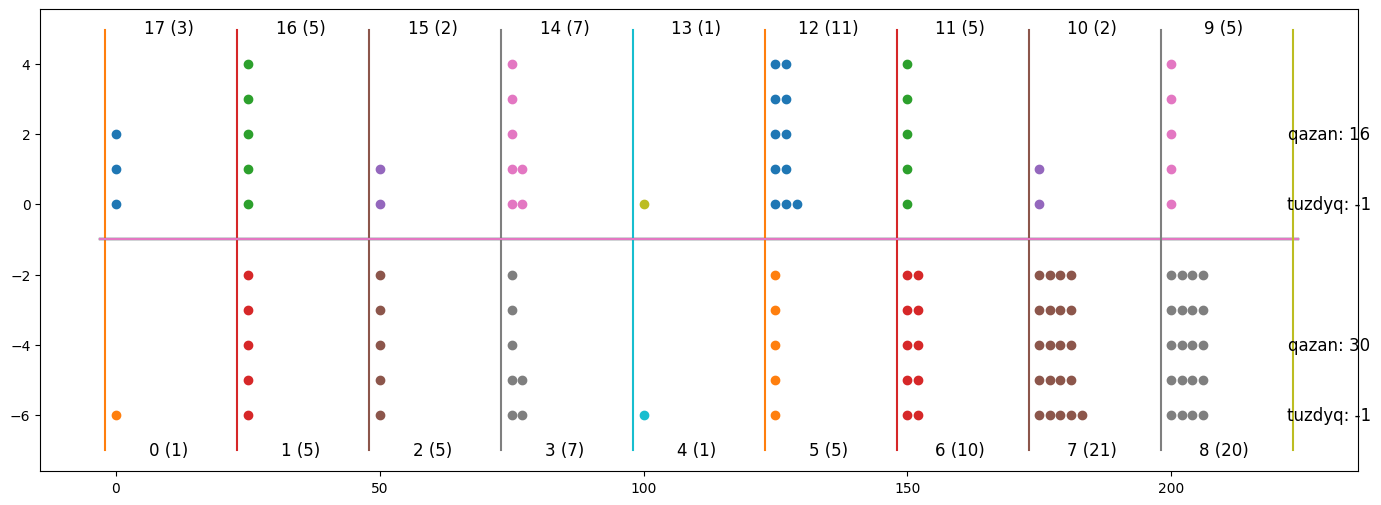

Player 0 wins -6.
Player 0 make action 5


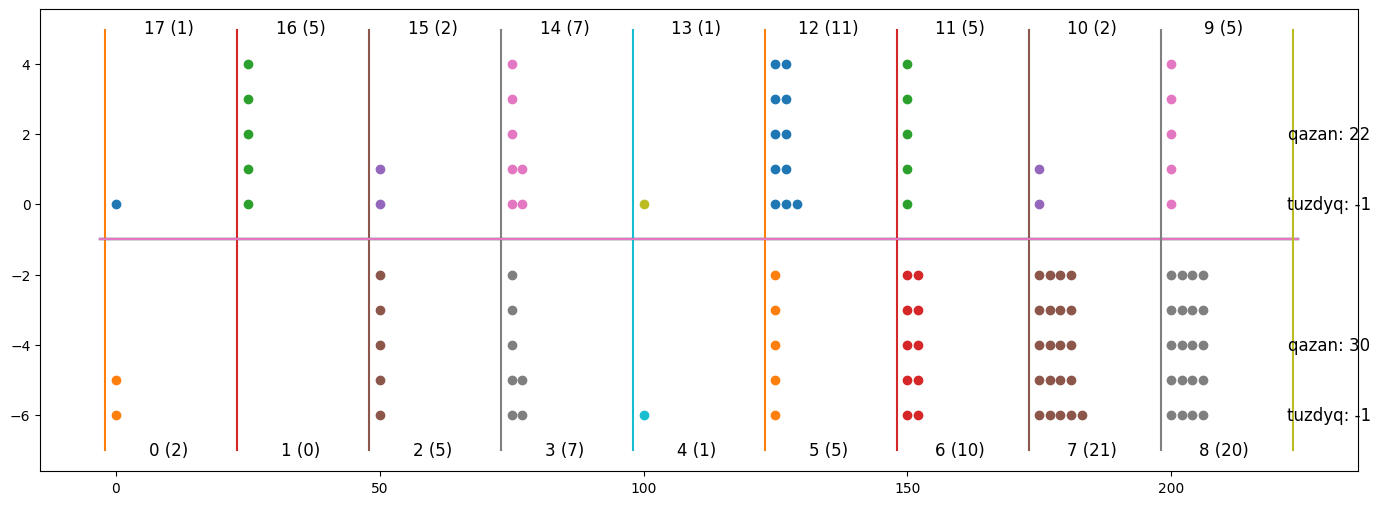

Player 1 make action 15


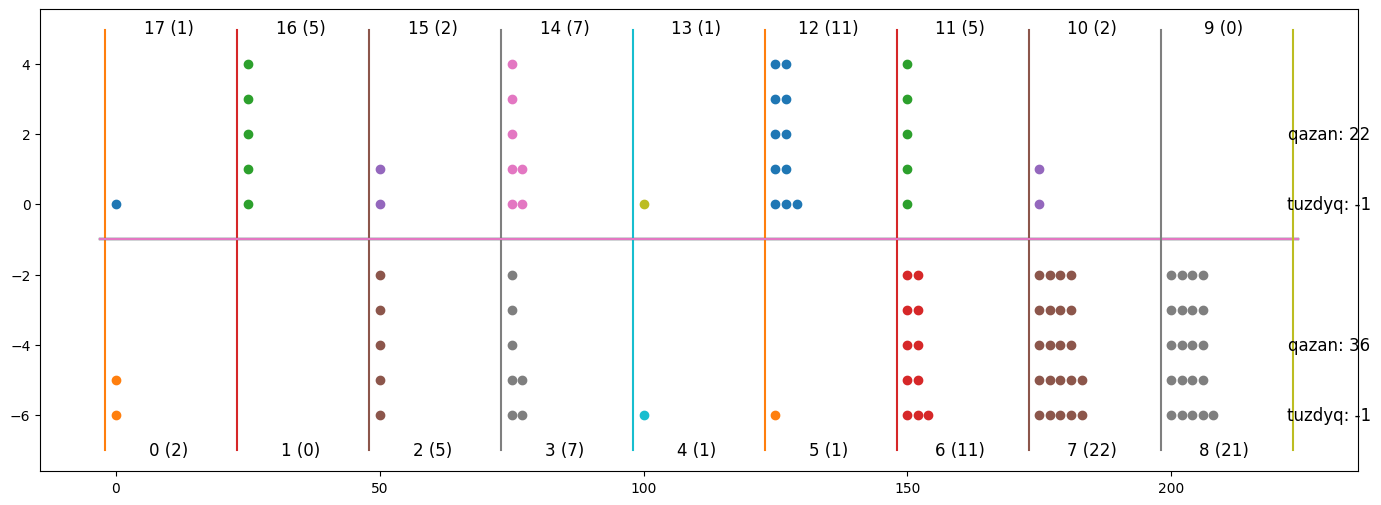

Player 0 wins 6.
Player 0 make action 0


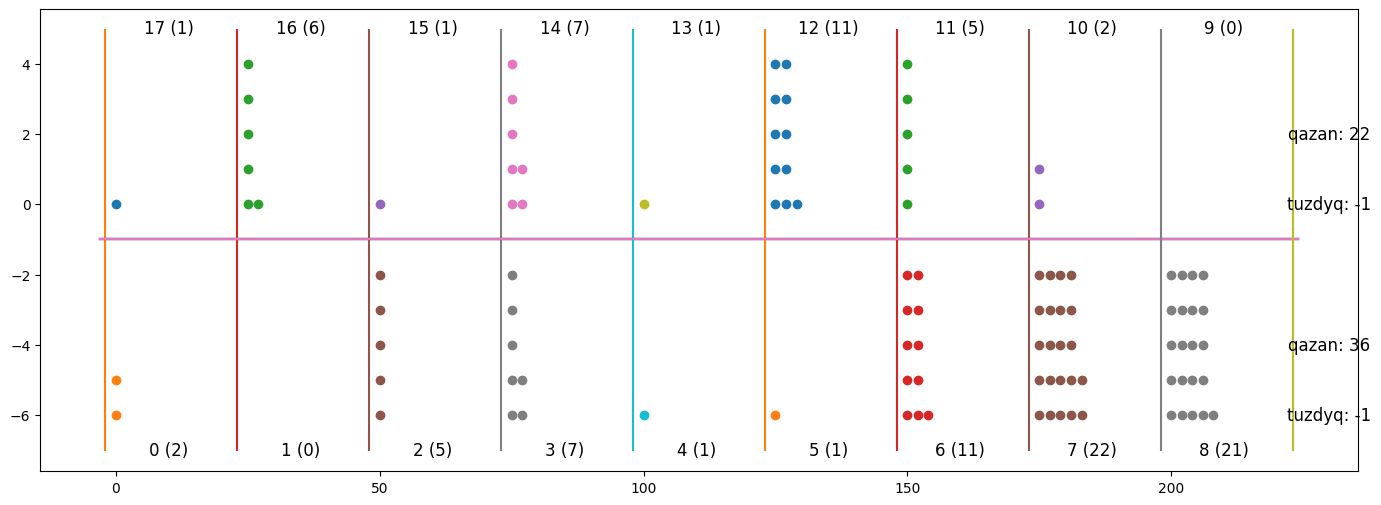

Player 1 make action 17


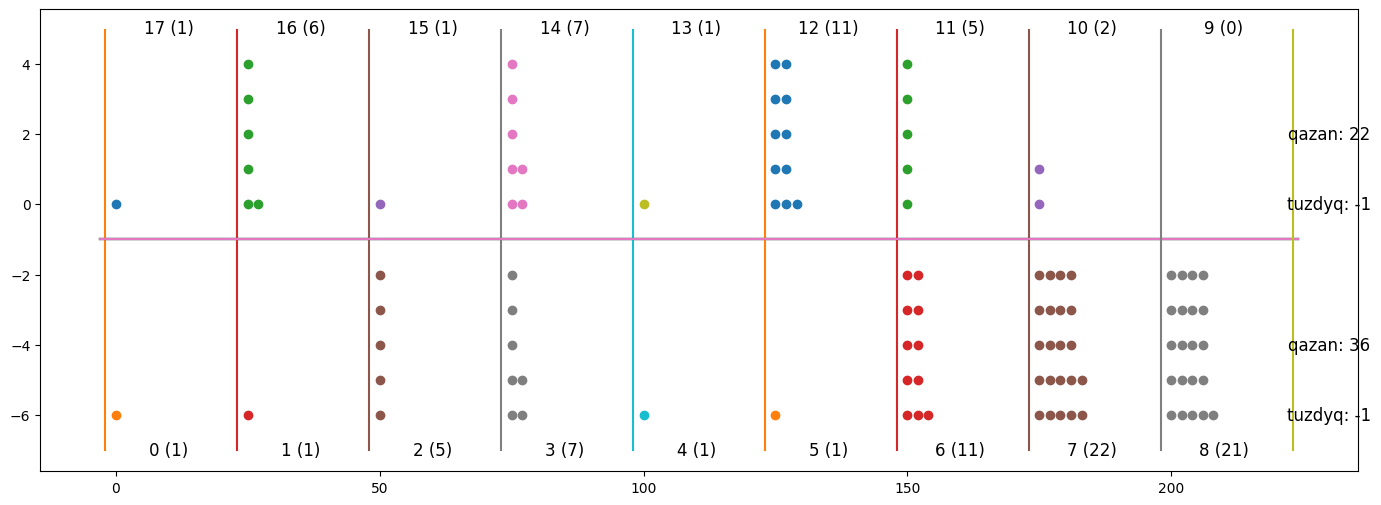

Player 0 wins -2.
Player 0 make action 6


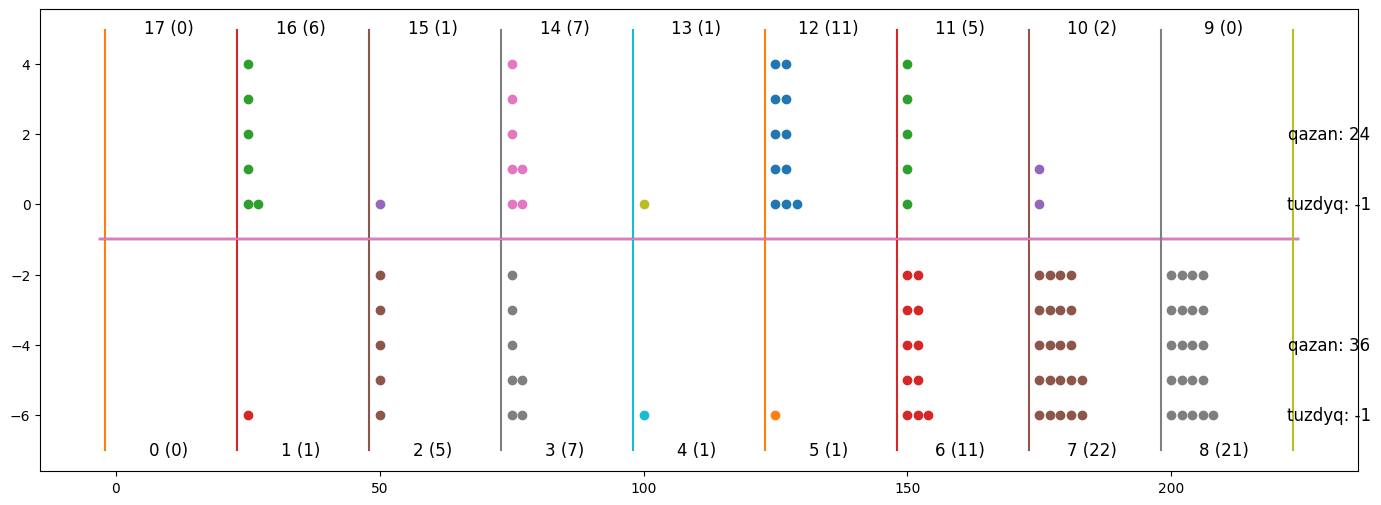

Player 1 make action 16


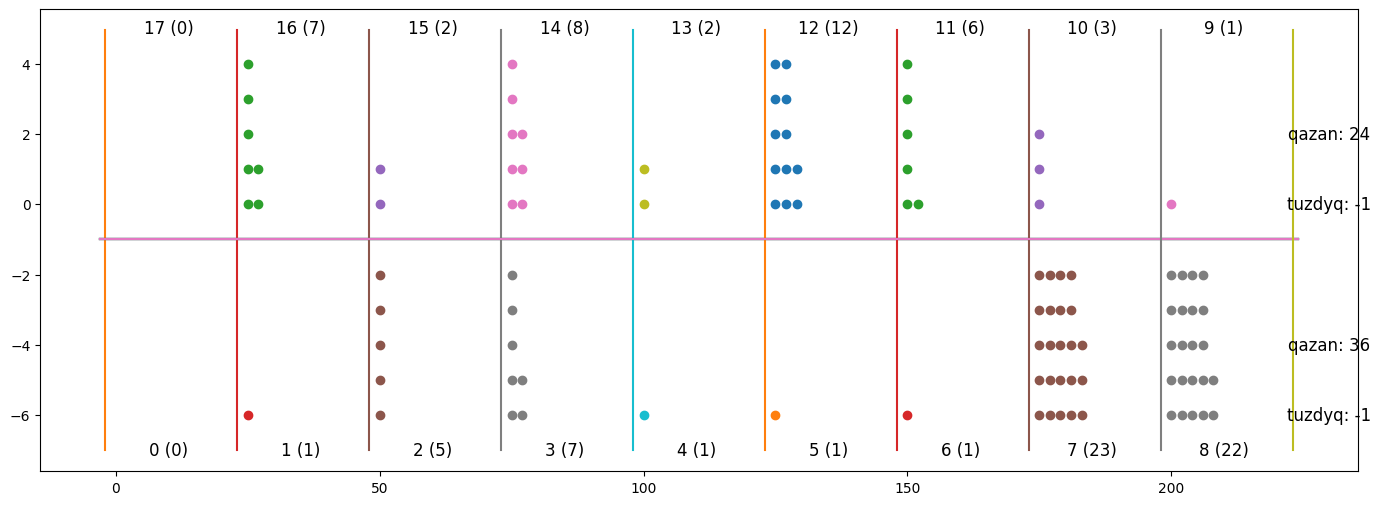

Player 0 wins -2.
Player 0 make action 0


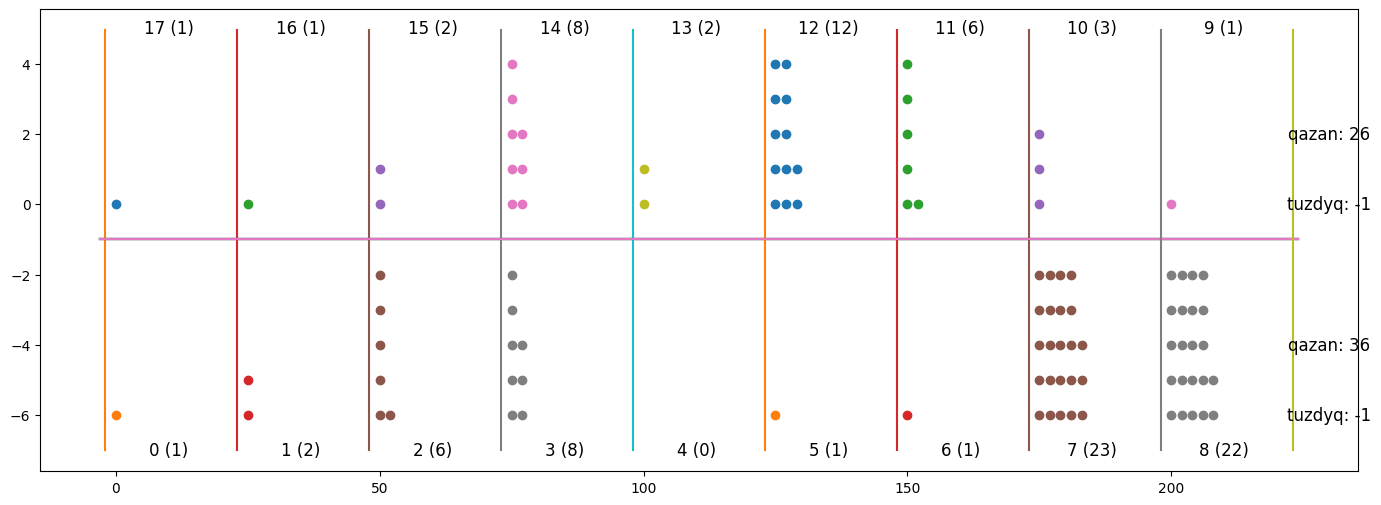

Player 1 make action 15


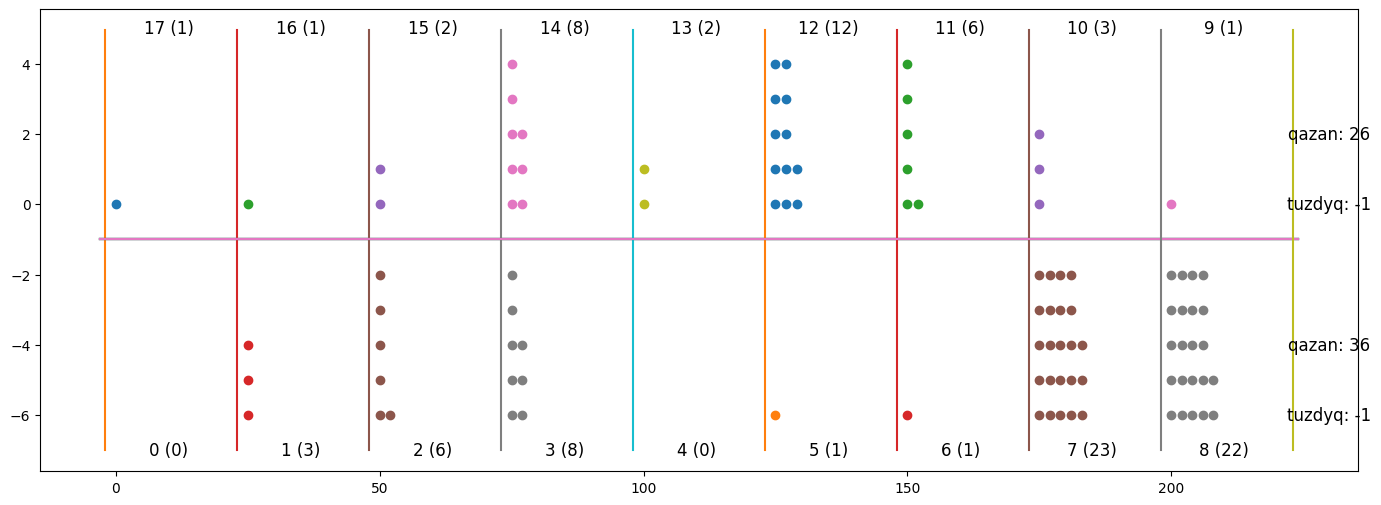

Player 0 wins 0.
Player 0 make action 6


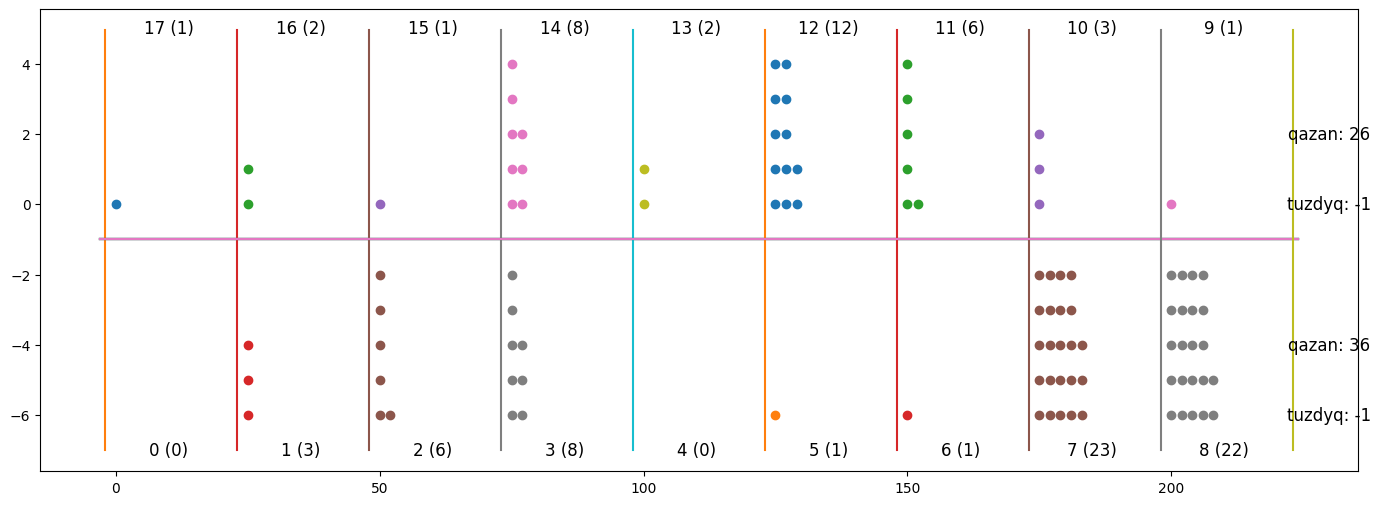

Player 1 make action 14


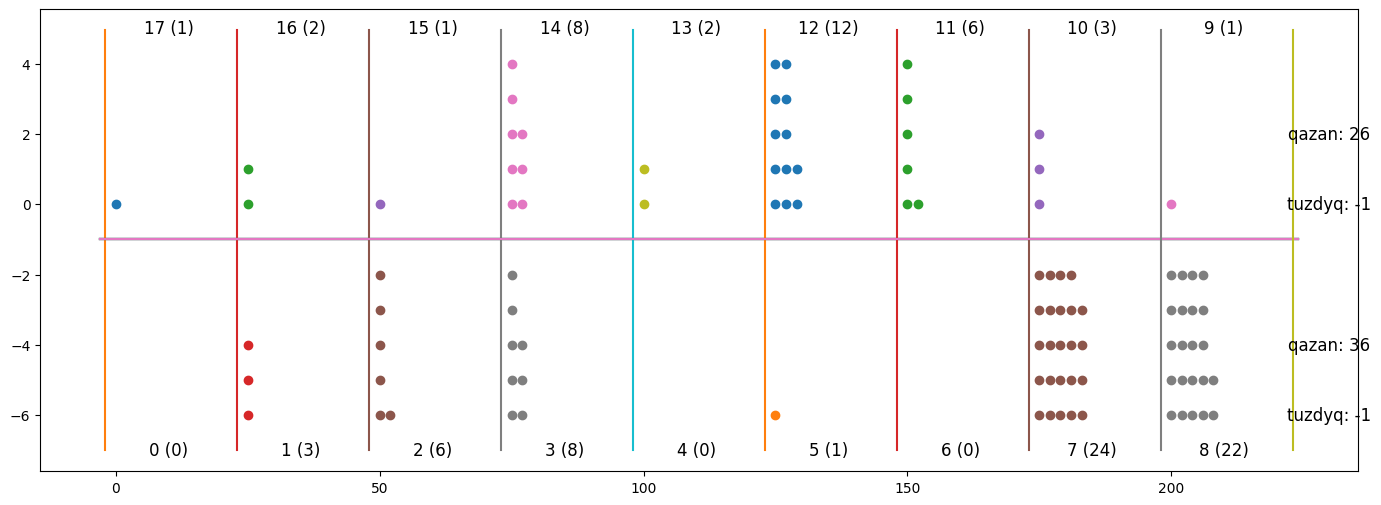

Player 0 wins 0.
Player 0 make action 0


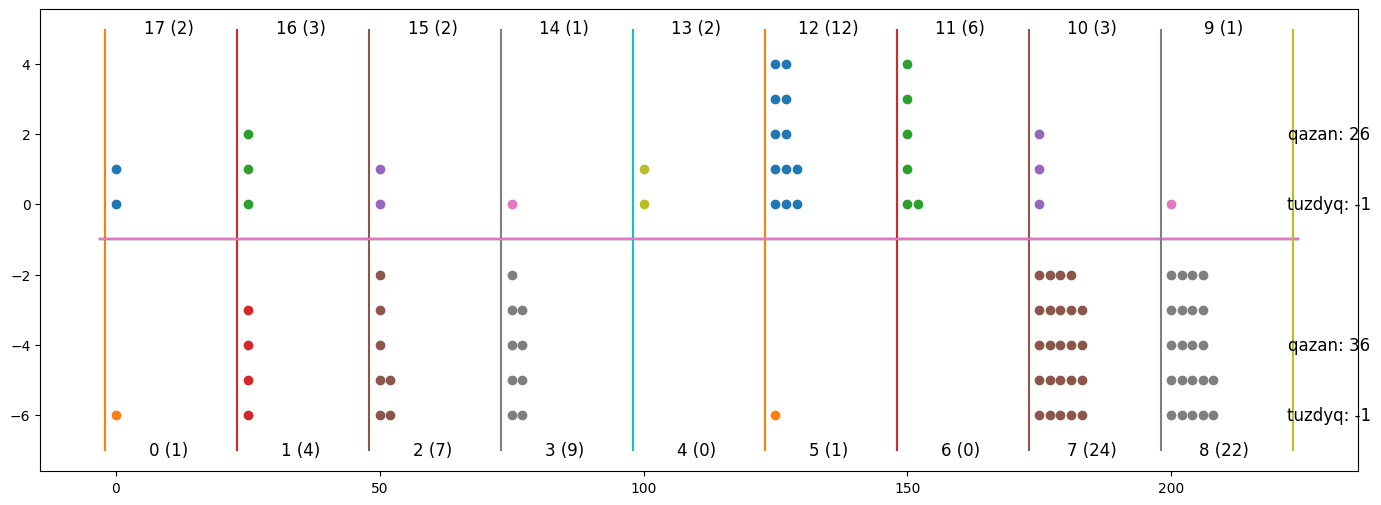

Player 1 make action 15


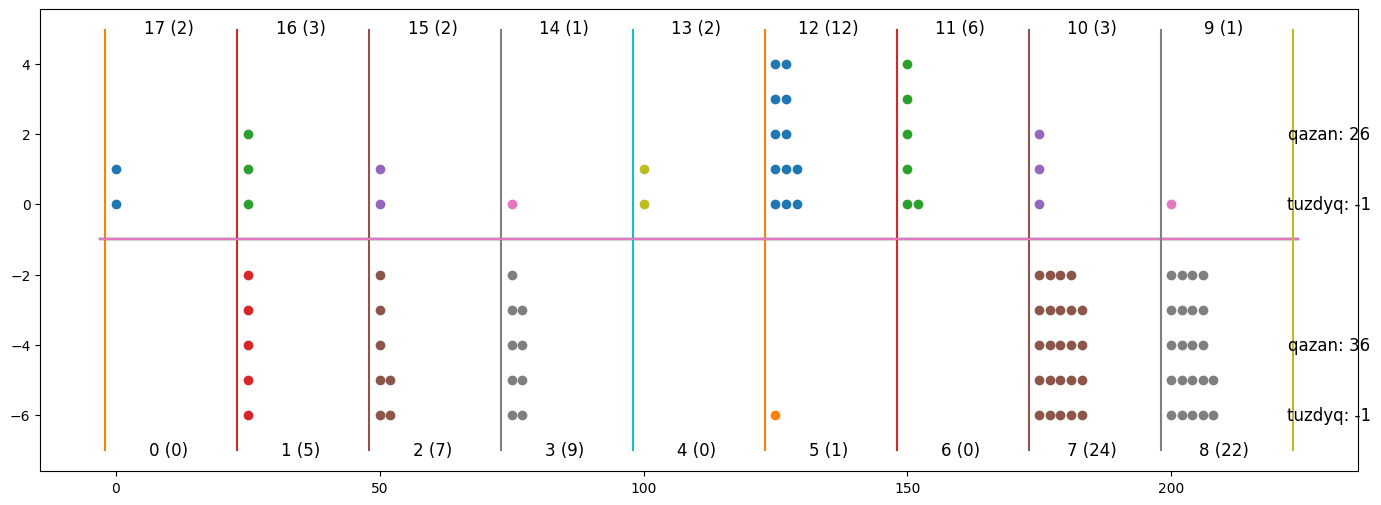

Player 0 wins 0.
Player 0 make action 1


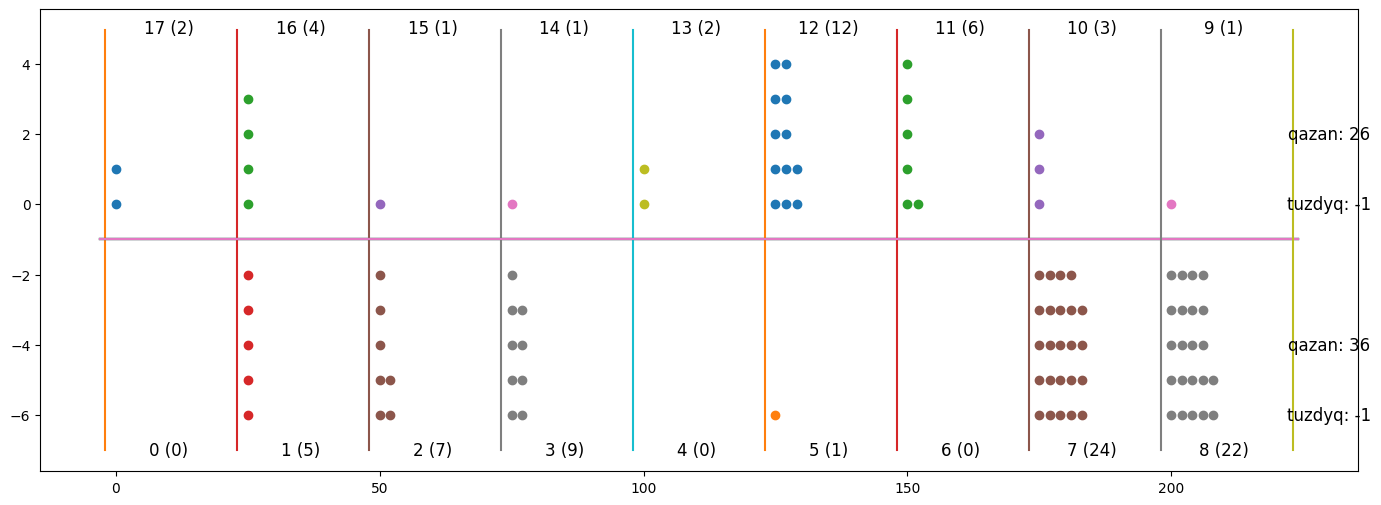

Player 1 make action 10


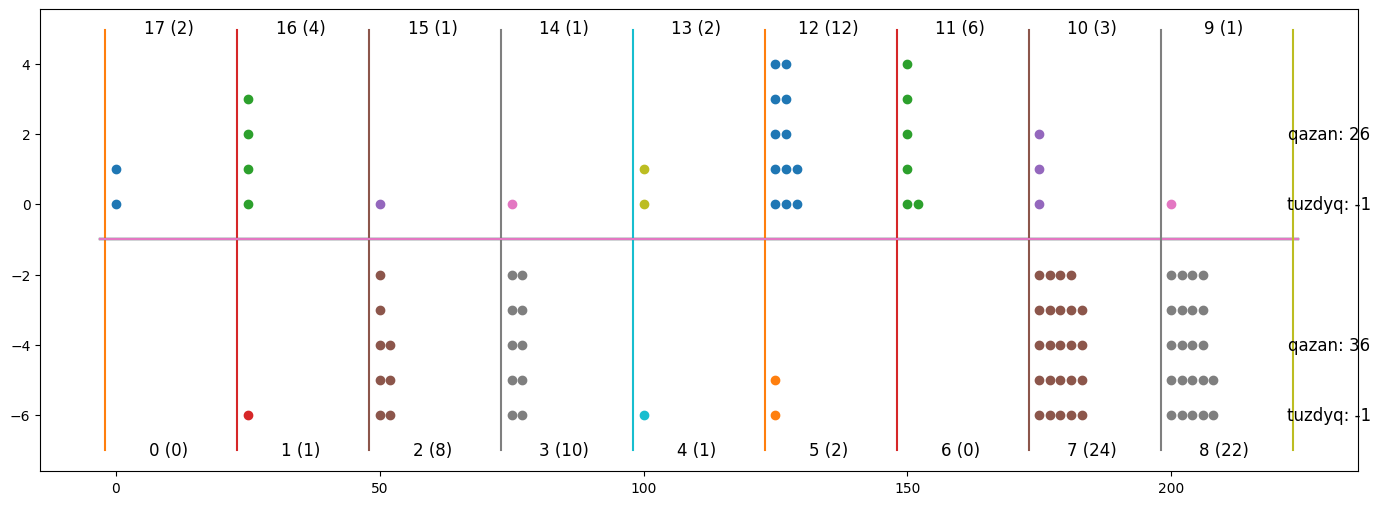

Player 0 wins 0.
Player 0 make action 7


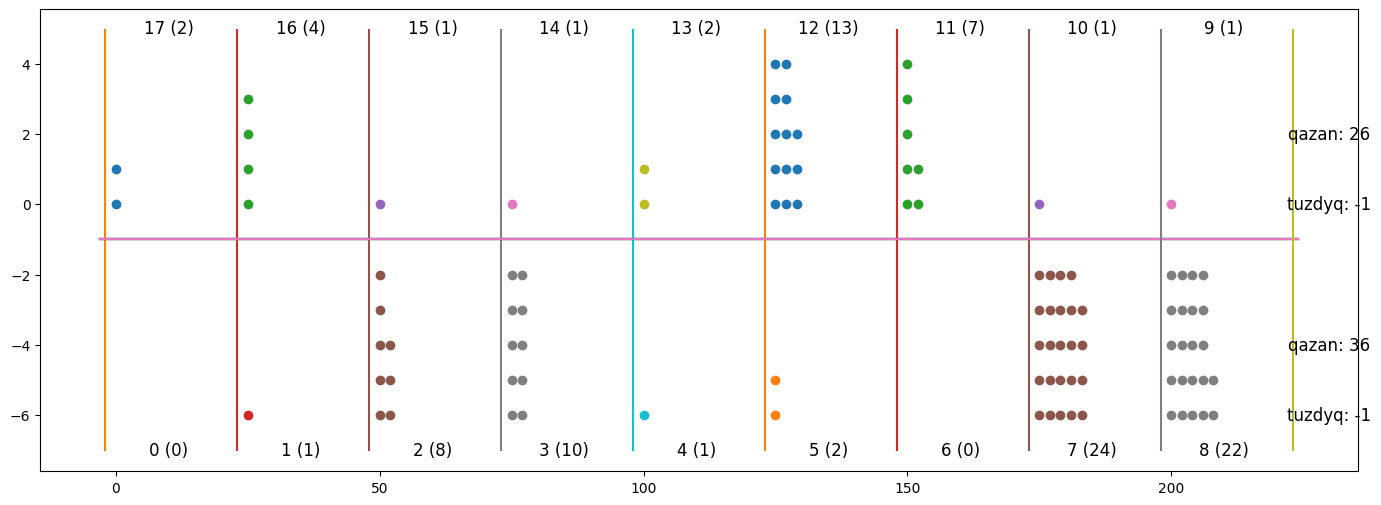

Player 1 make action 11


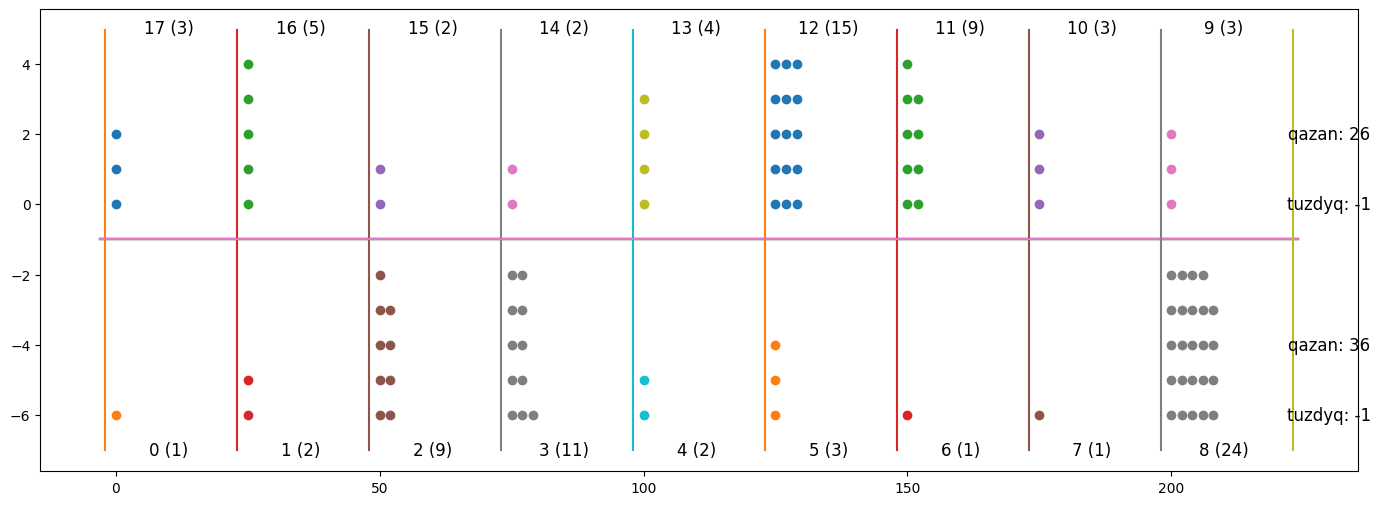

Player 0 wins 0.
Player 0 make action 0


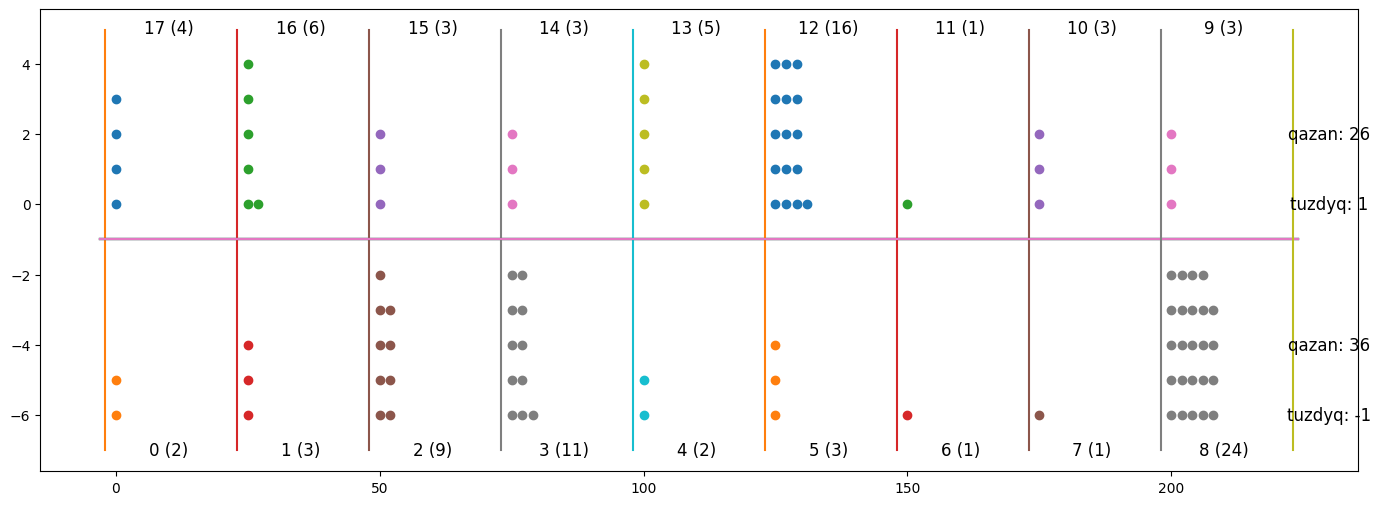

Player 1 make action 17


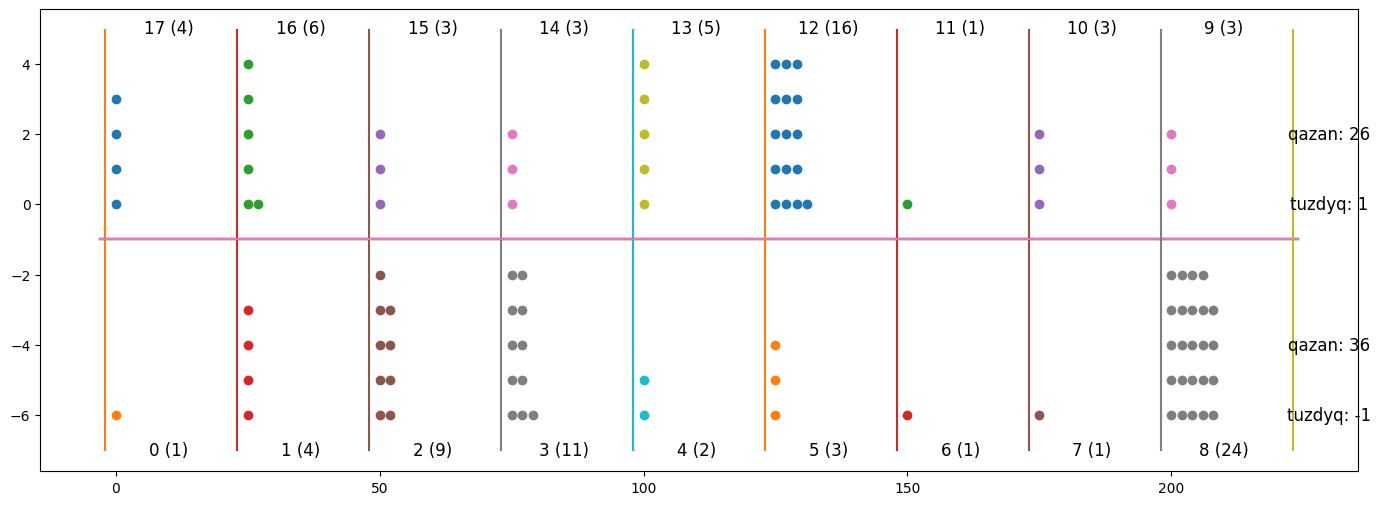

Player 0 wins -15.
Player 0 make action 0


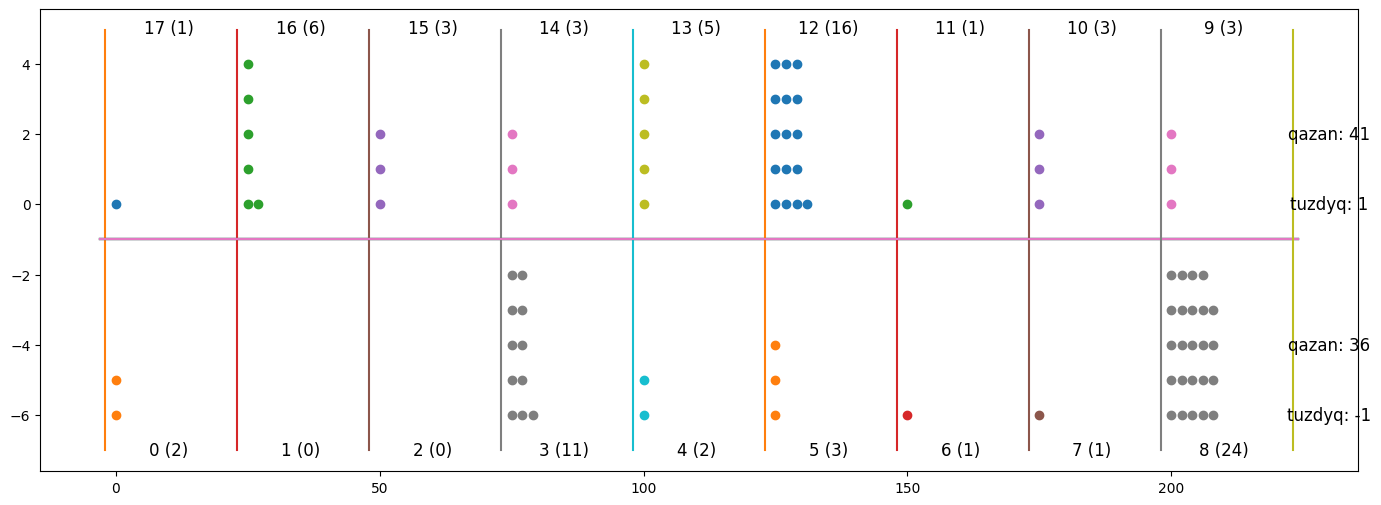

Player 1 make action 15


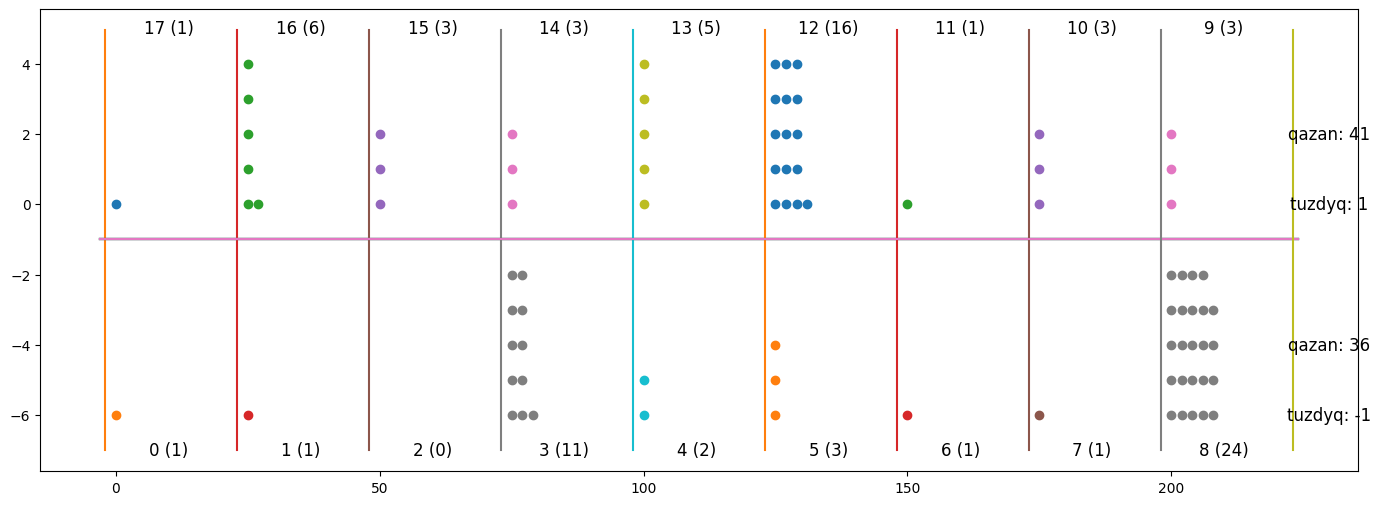

Player 0 wins -1.
Player 0 make action 0


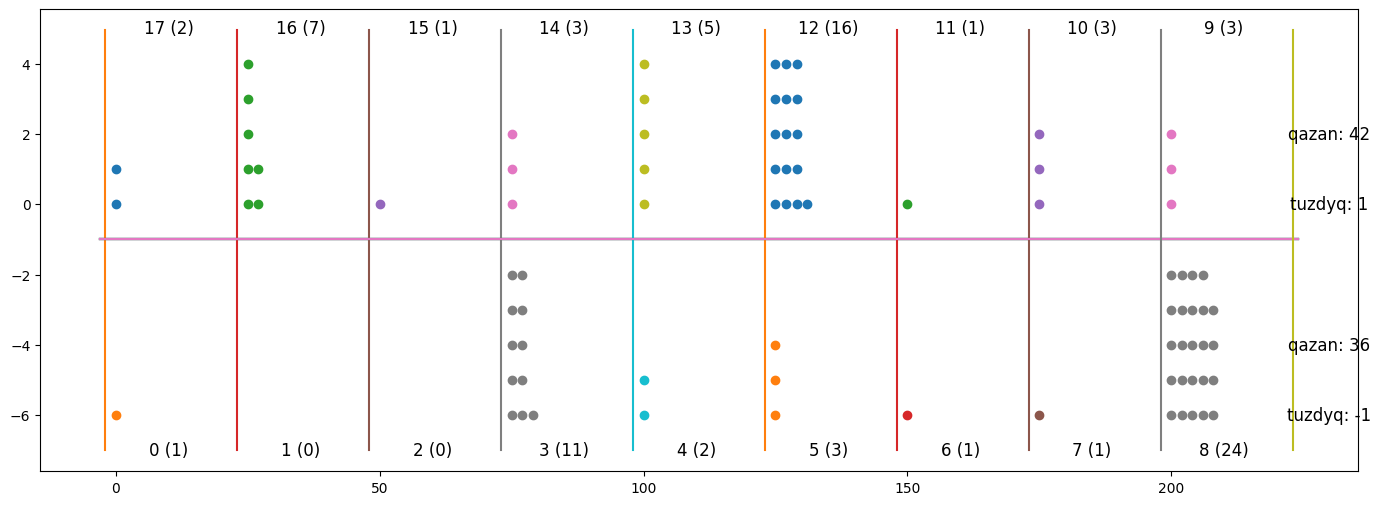

Player 1 make action 15


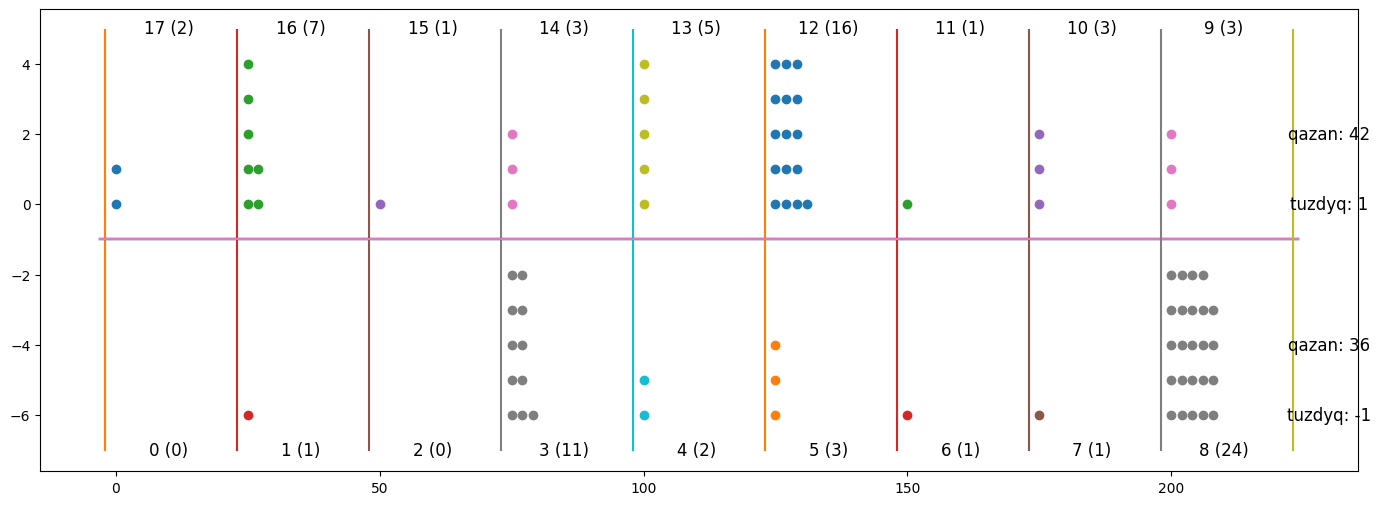

Player 0 wins -1.
Player 0 make action 5


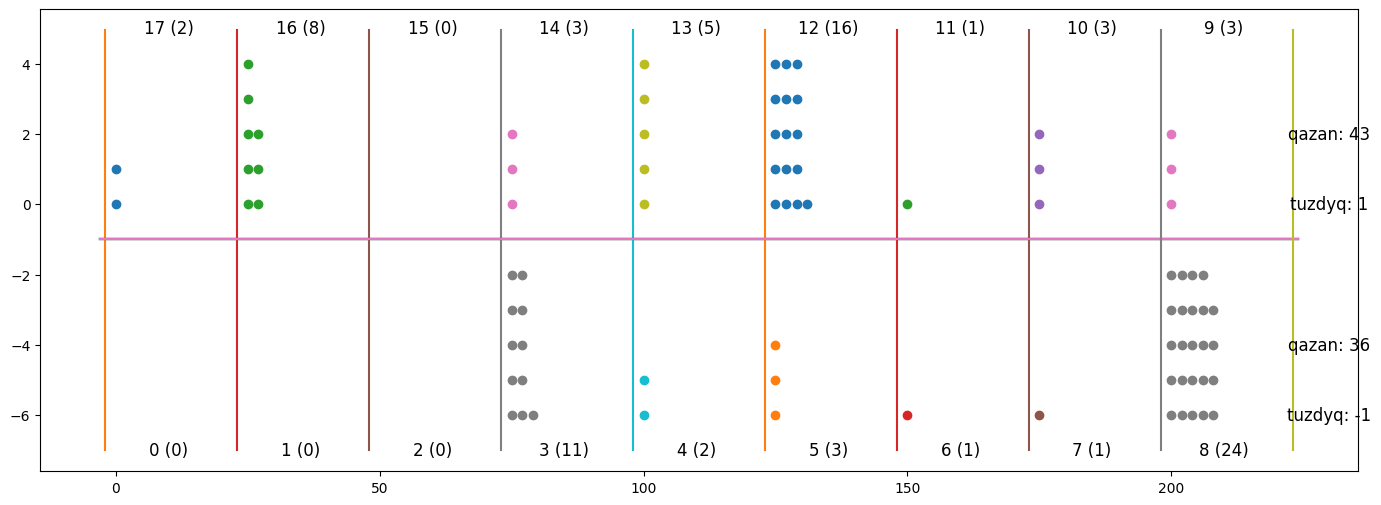

Player 1 make action 11


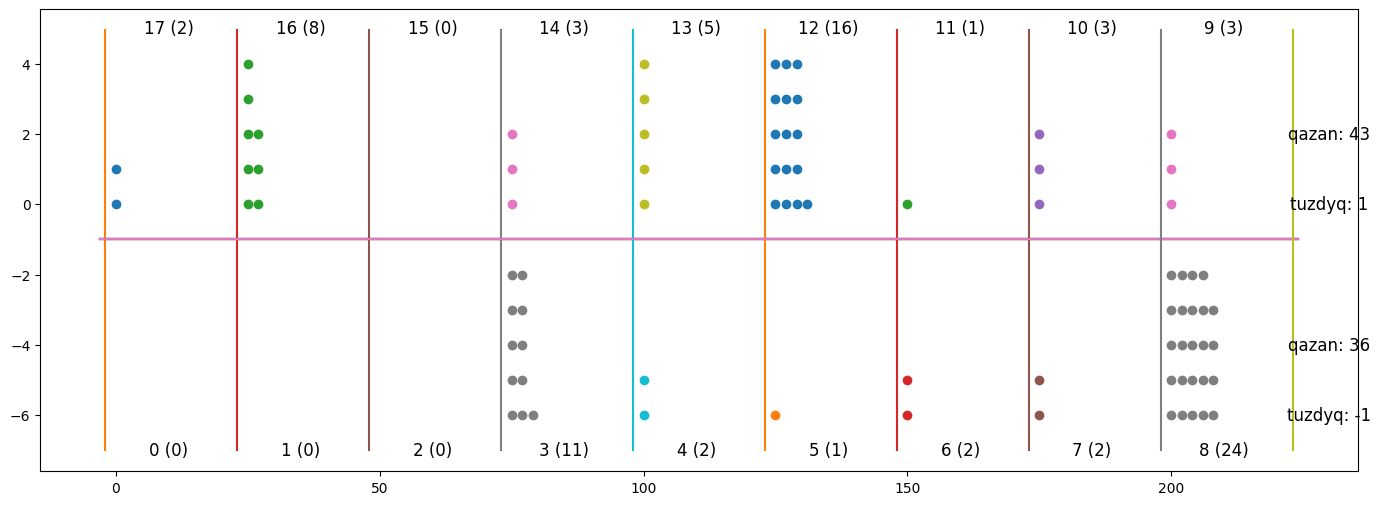

Player 0 wins 0.
Player 0 make action 5


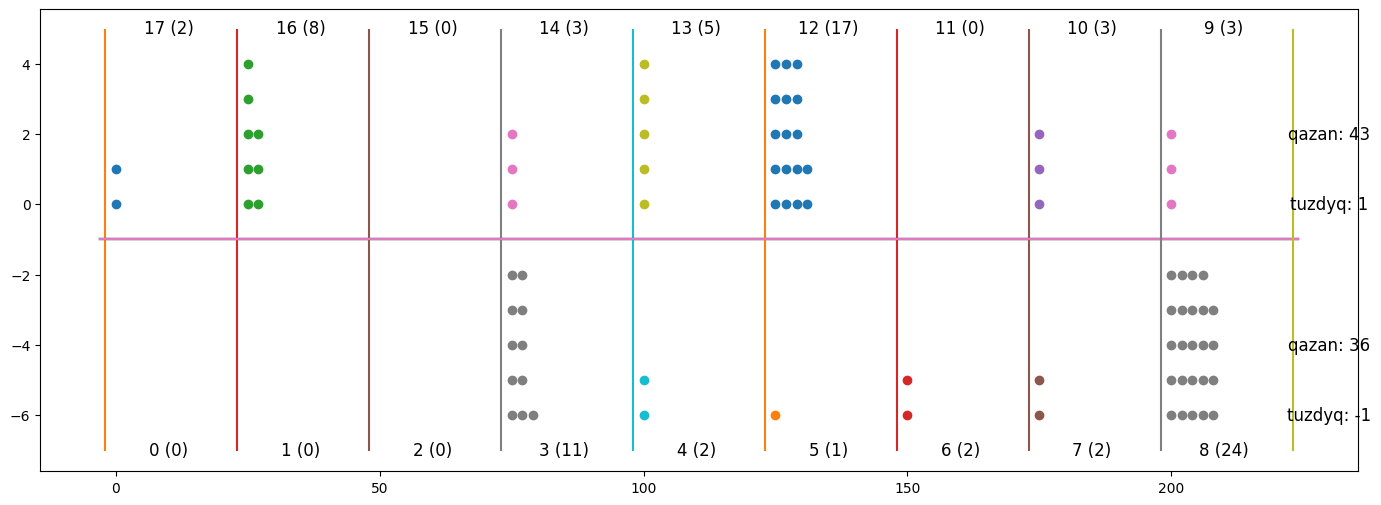

Player 1 make action 16


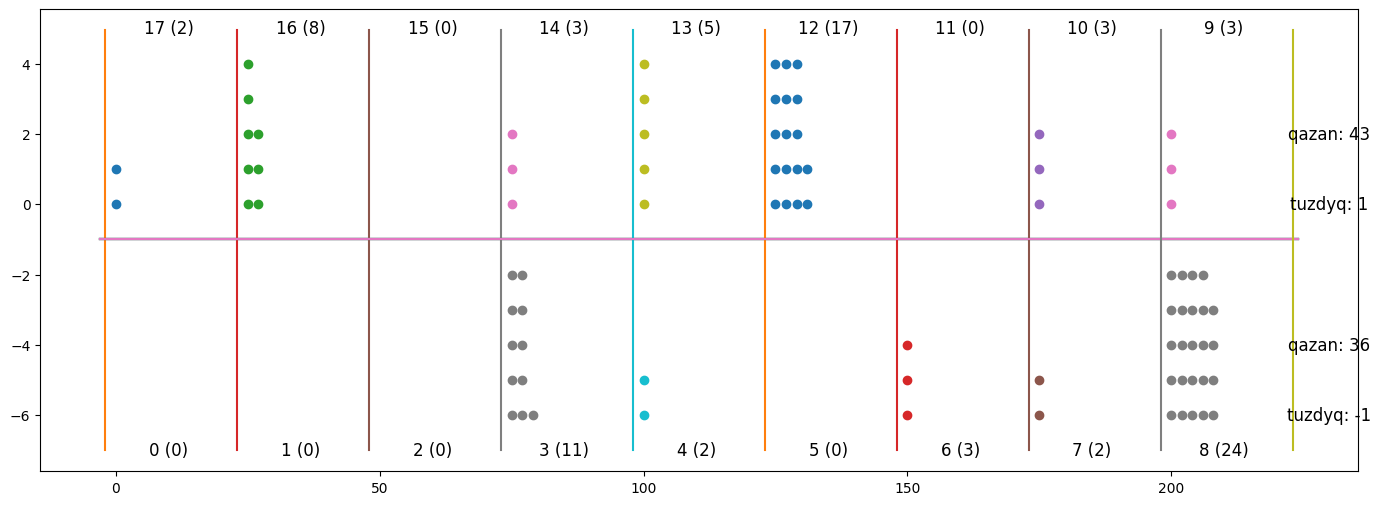

Player 0 wins -1.
Player 0 make action 3


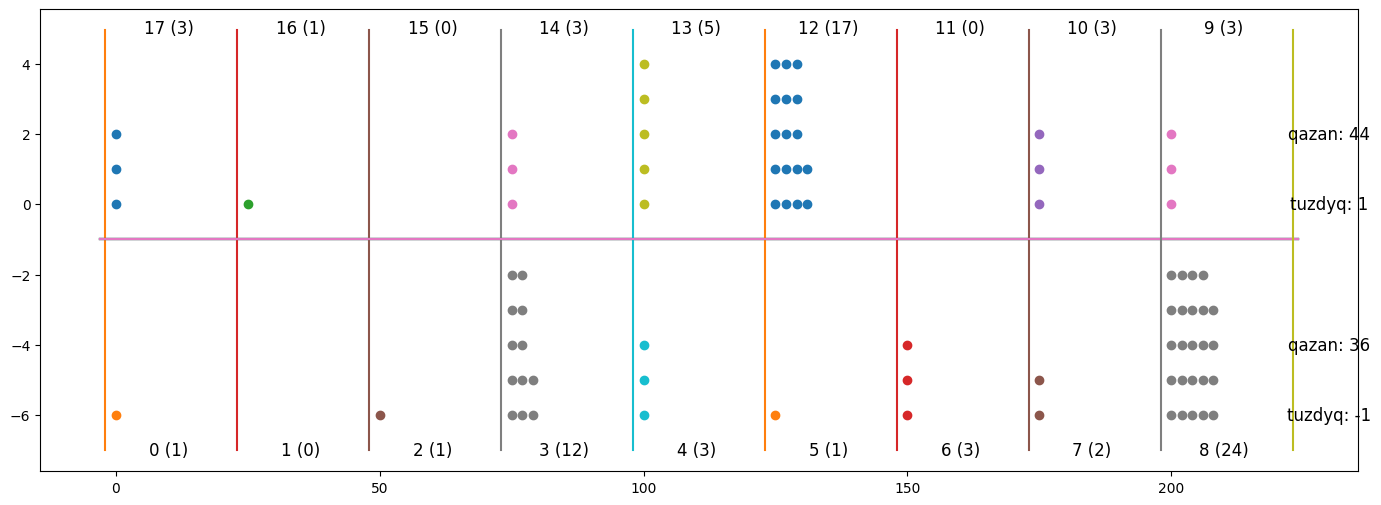

Player 1 make action 17


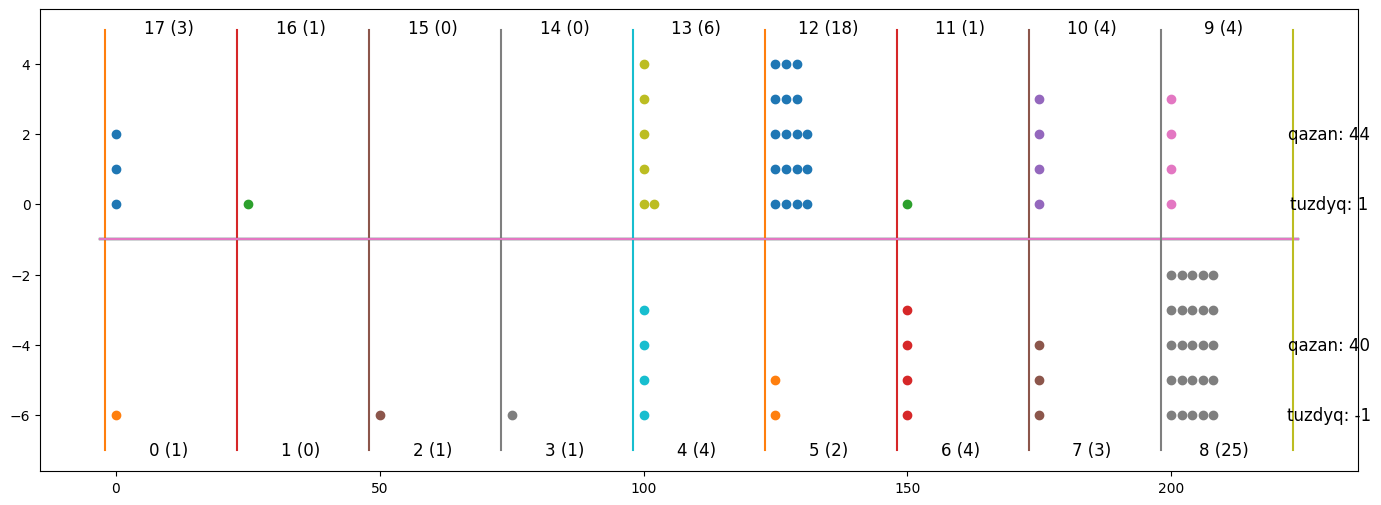

Player 0 wins 3.
Player 0 make action 0


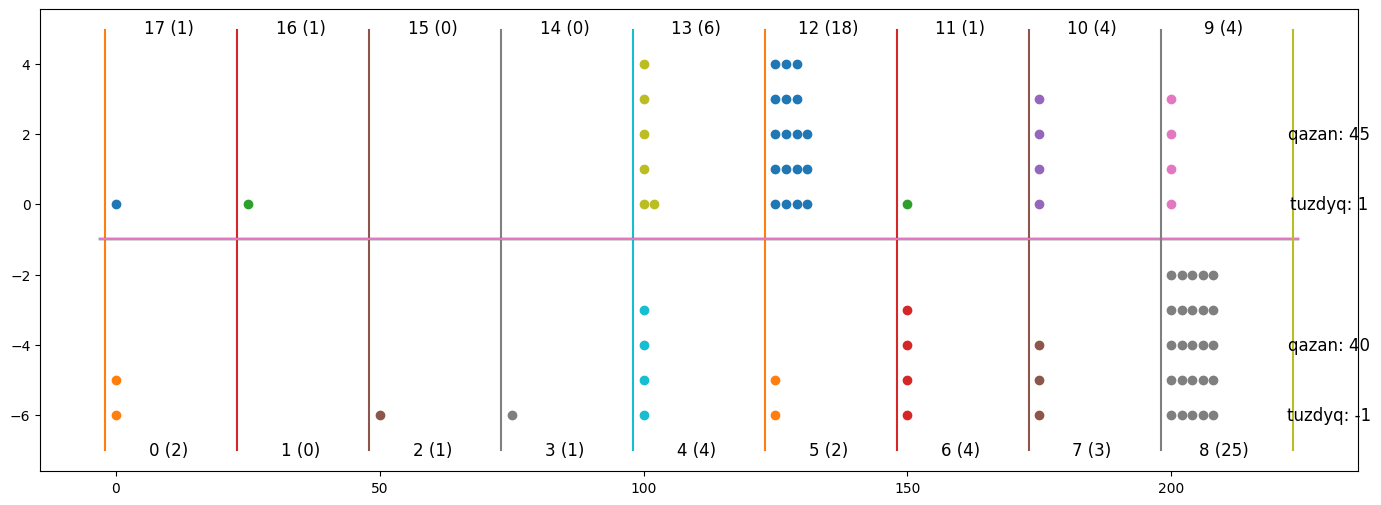

Player 1 make action 10


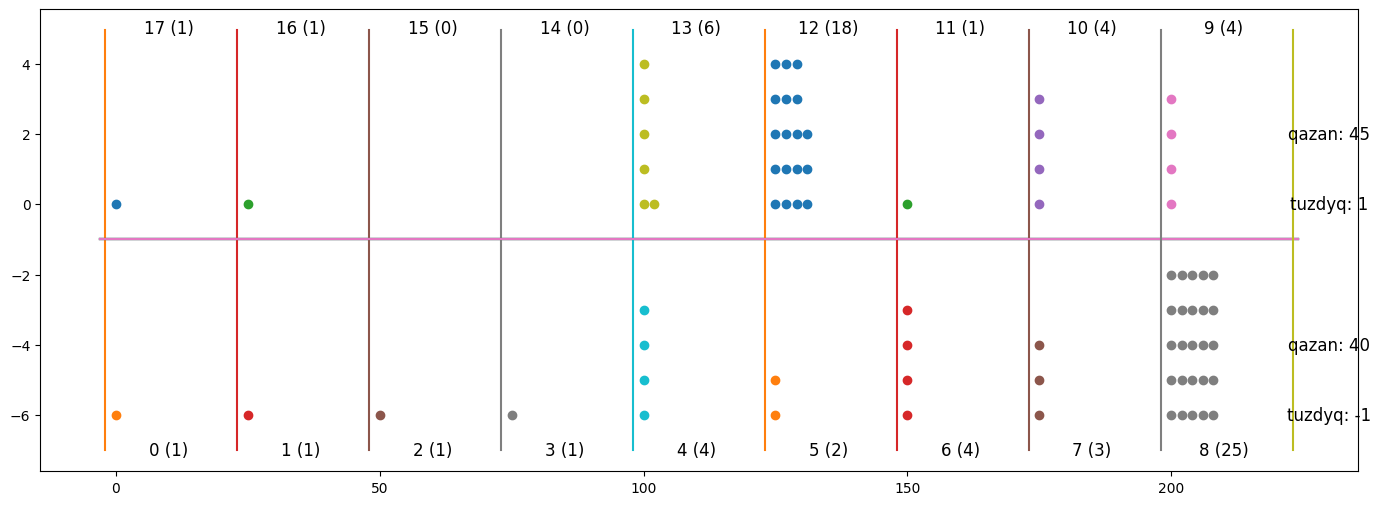

Player 0 wins -1.
Player 0 make action 0


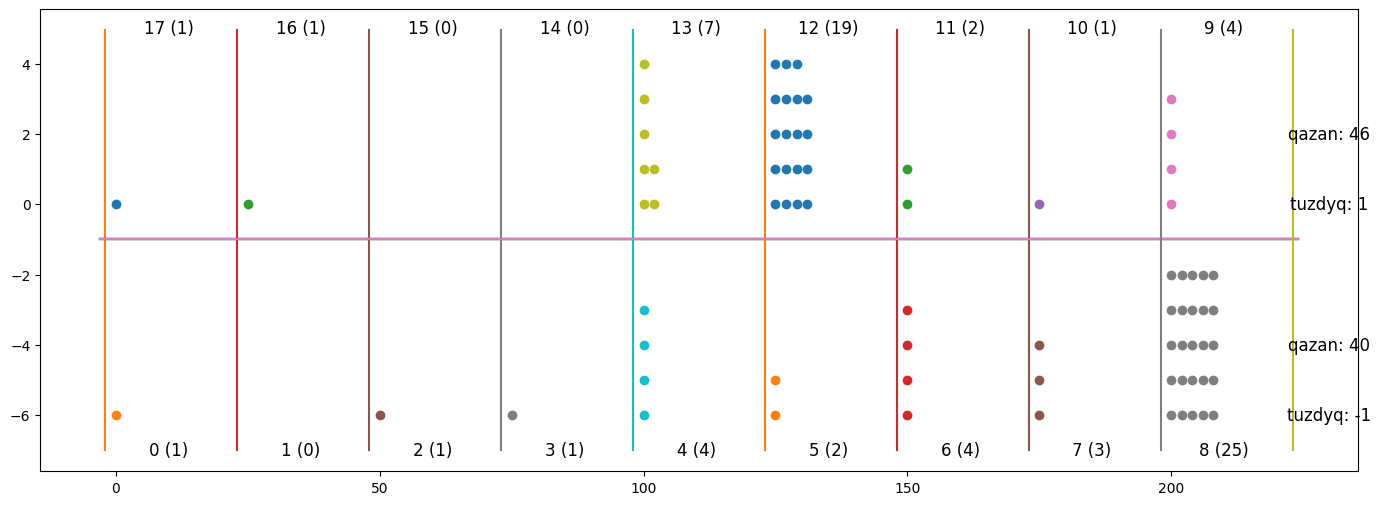

Player 1 make action 13


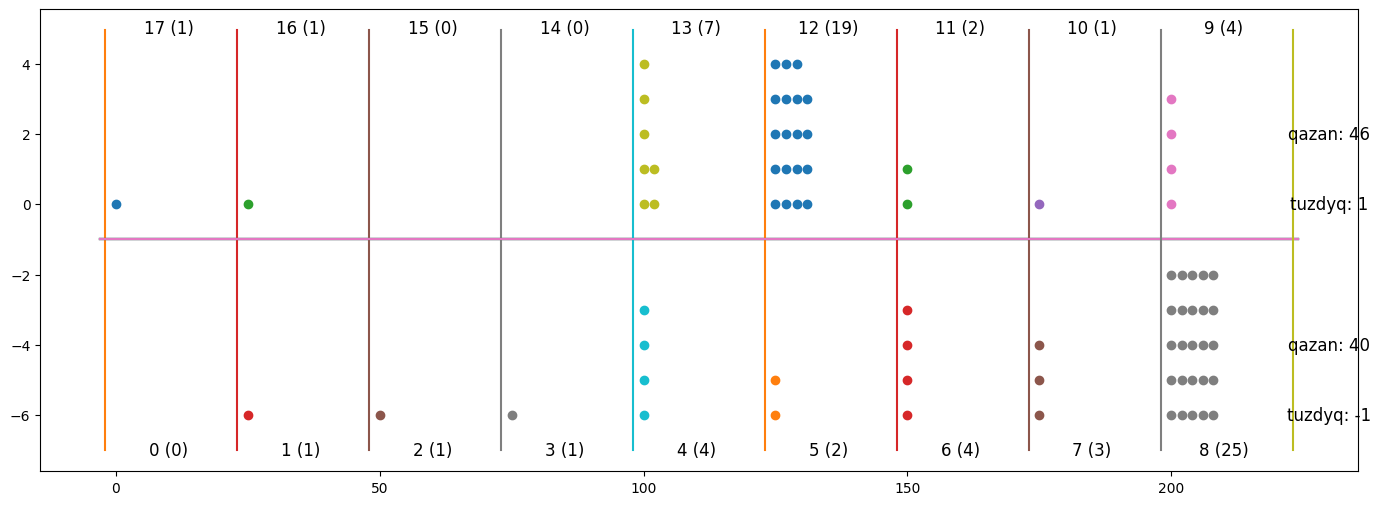

Player 0 wins -2.
Player 0 make action 0


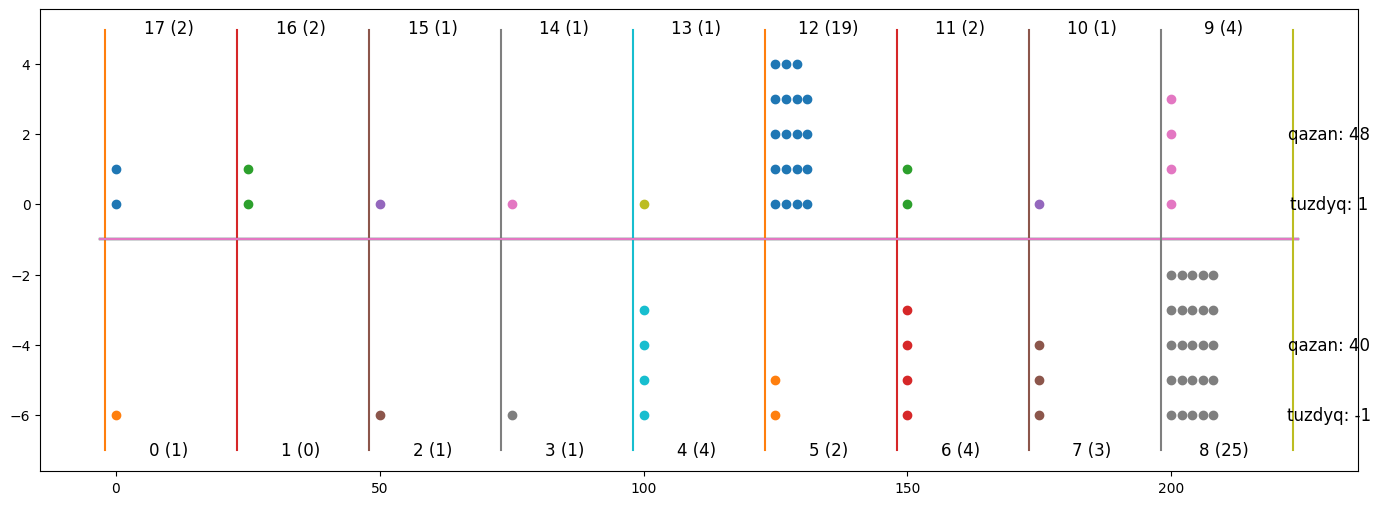

Player 1 make action 12


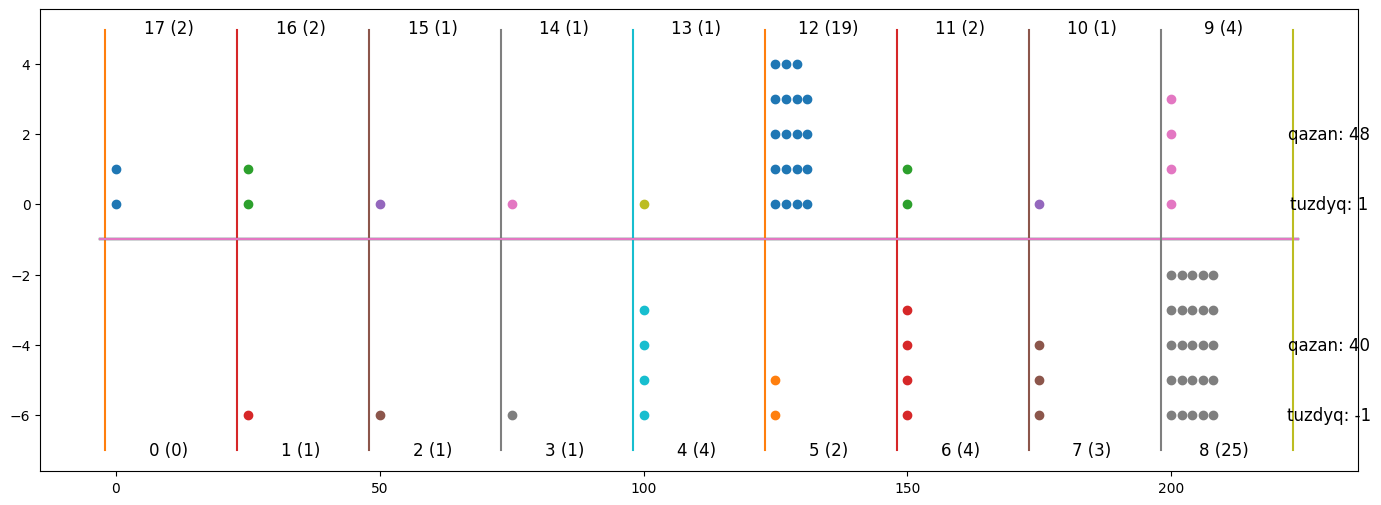

Player 0 wins -2.
Player 0 make action 0


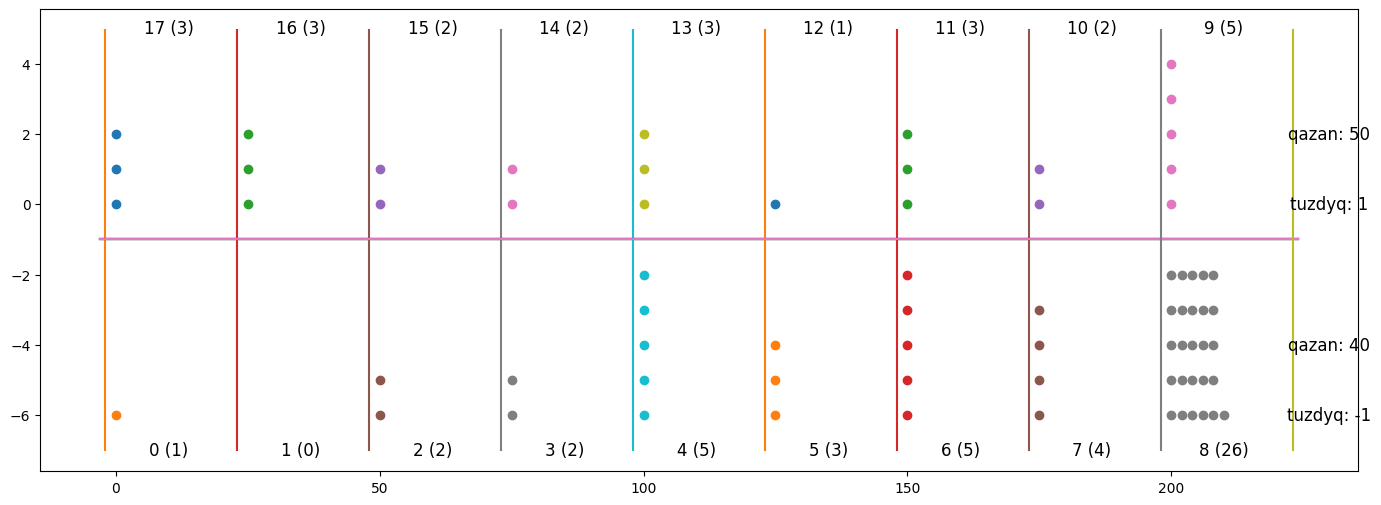

Player 1 make action 9


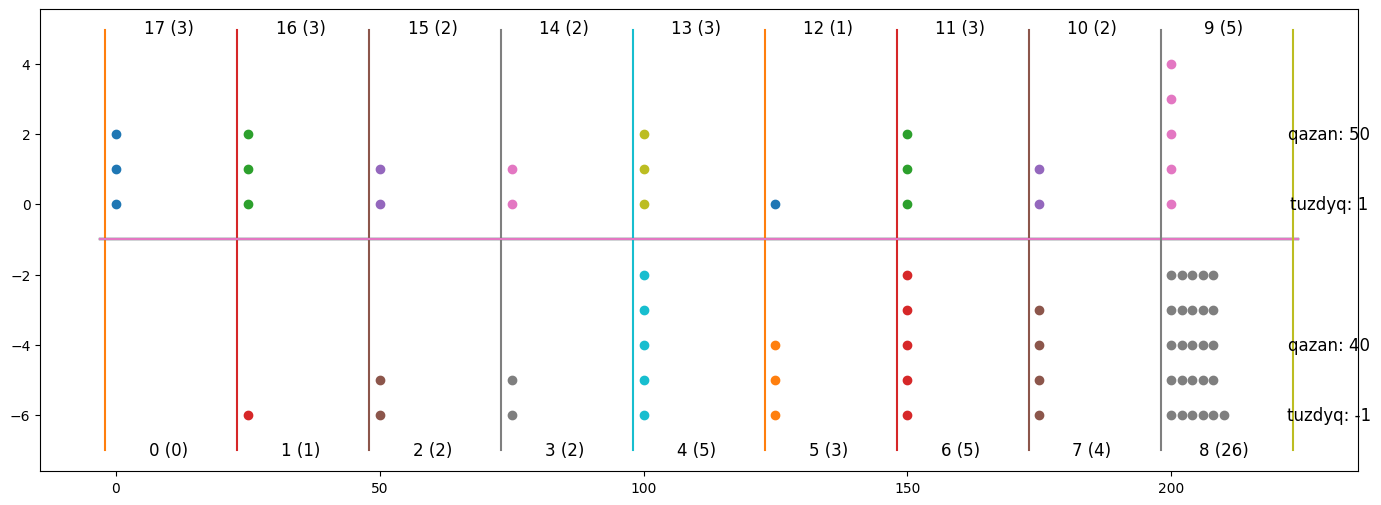

Player 0 wins -1.
Player 0 make action 8


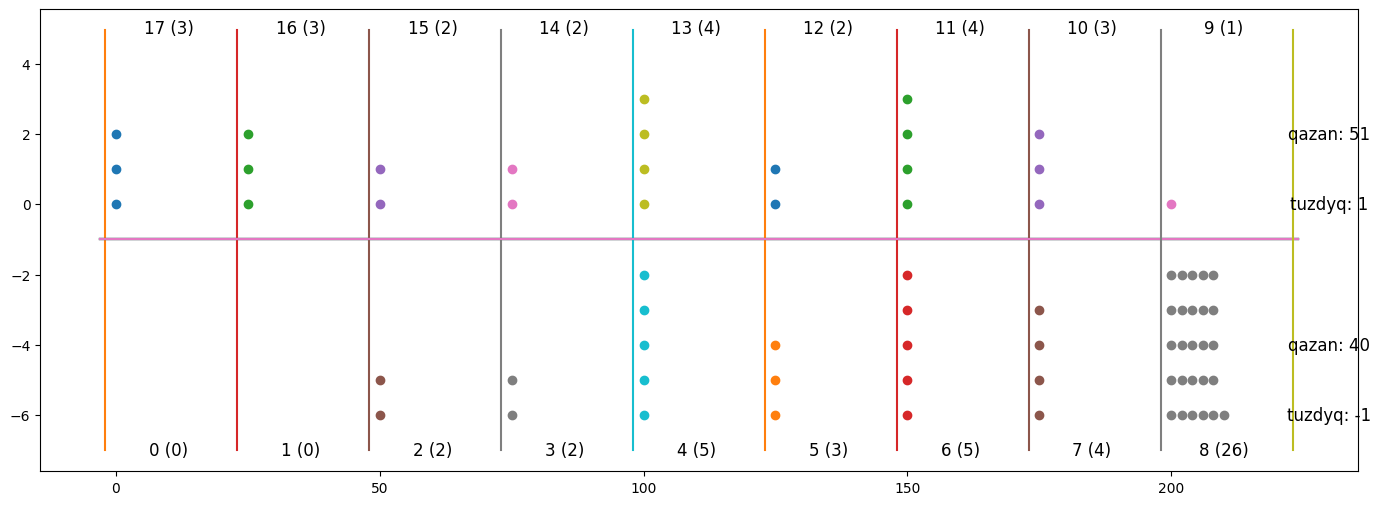

Player 1 make action 13


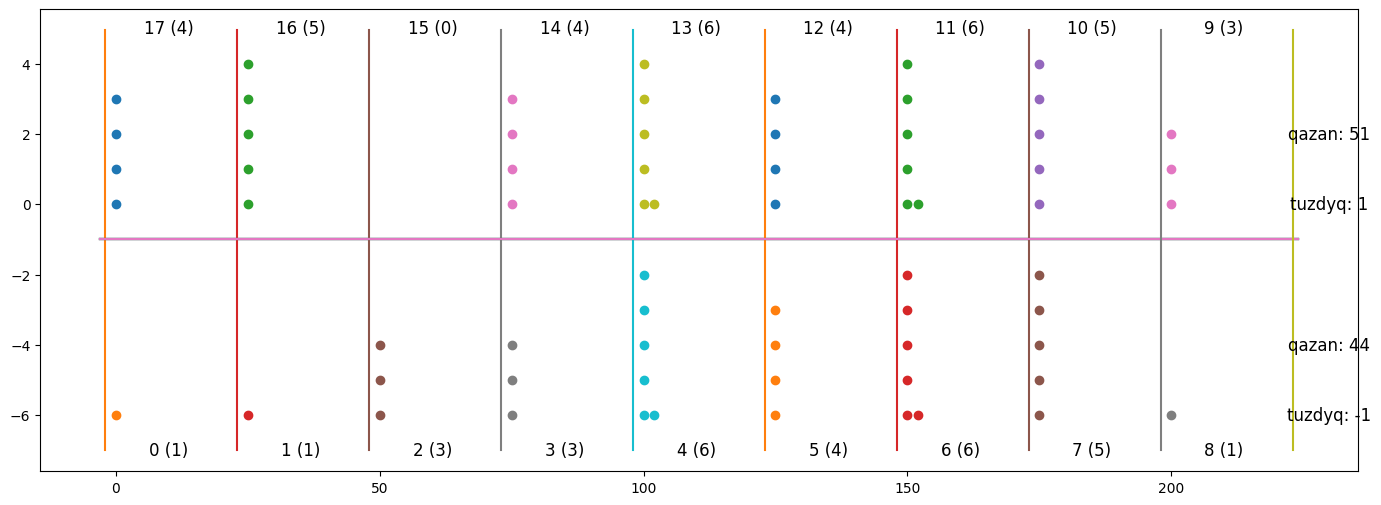

Player 0 wins 1.
Player 0 make action 6


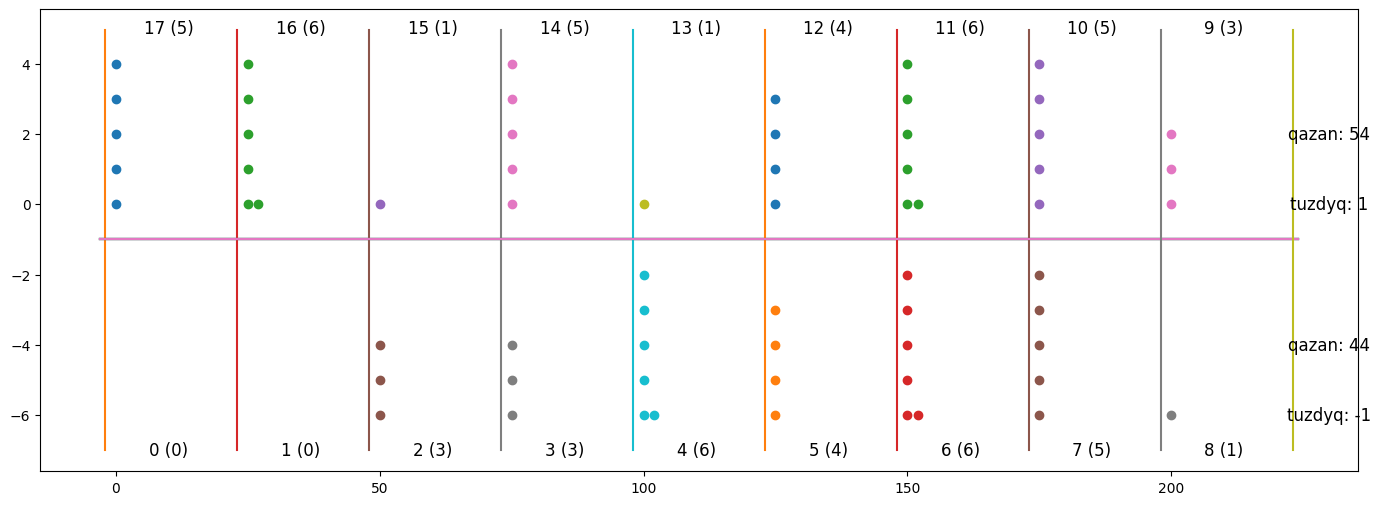

Player 1 make action 17


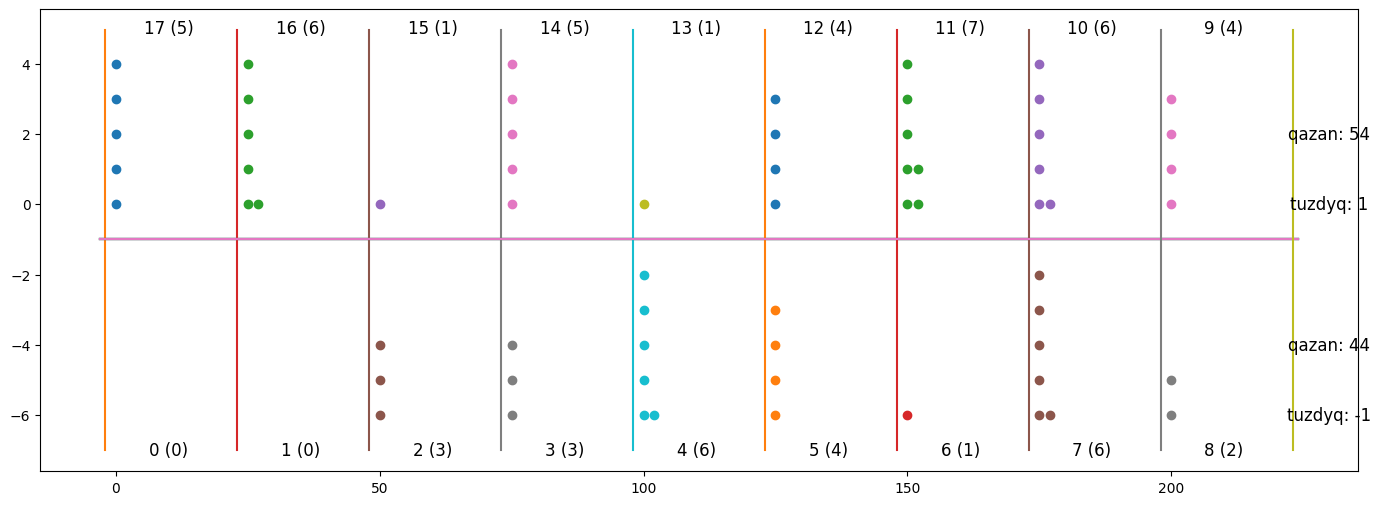

Player 0 wins -5.
Player 0 make action 2


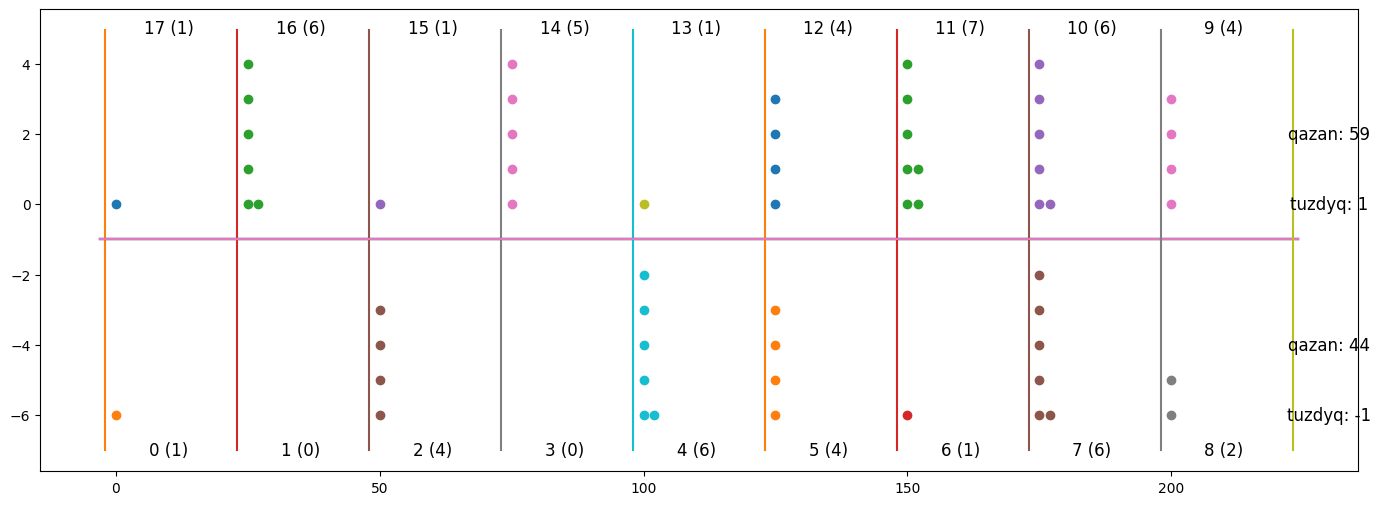

Player 1 make action 9


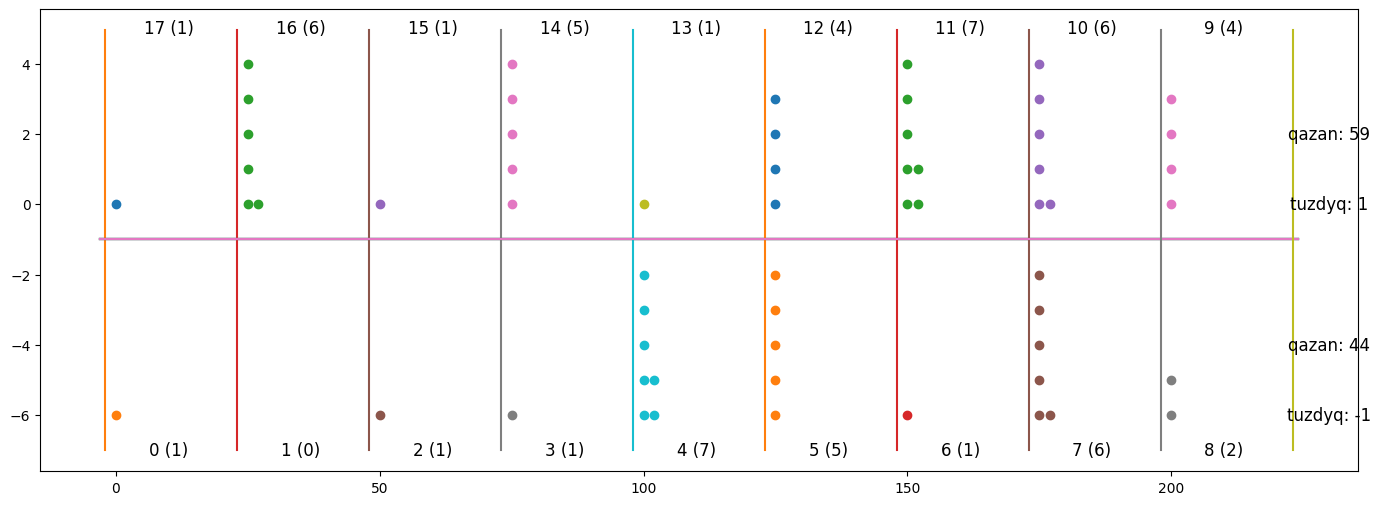

Player 0 wins 0.
Player 0 make action 0


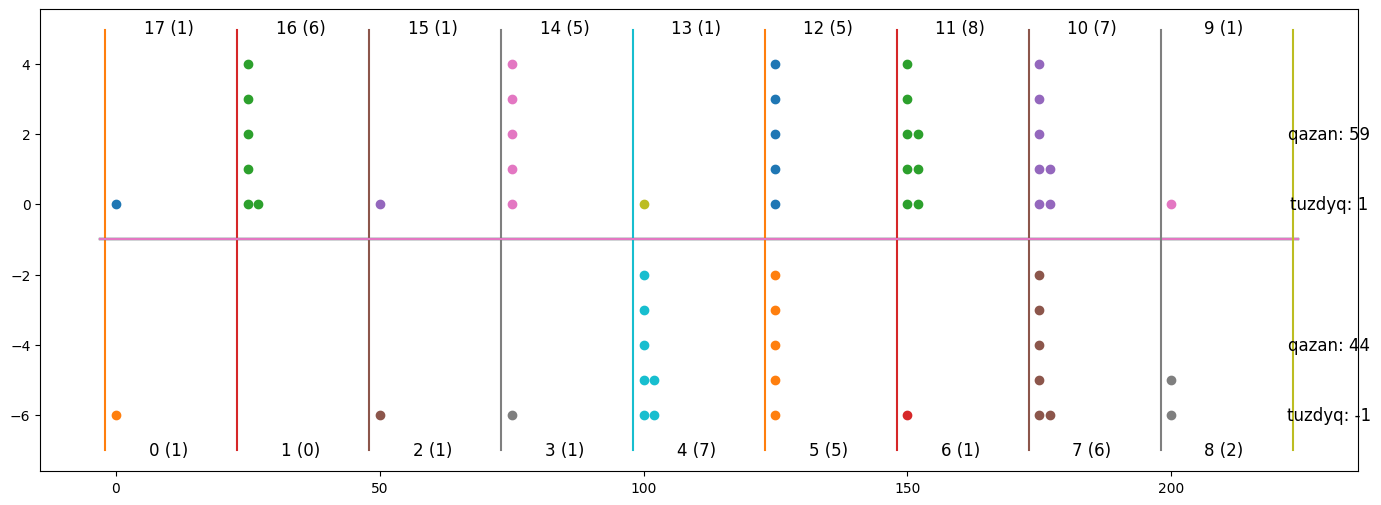

Player 1 make action 11


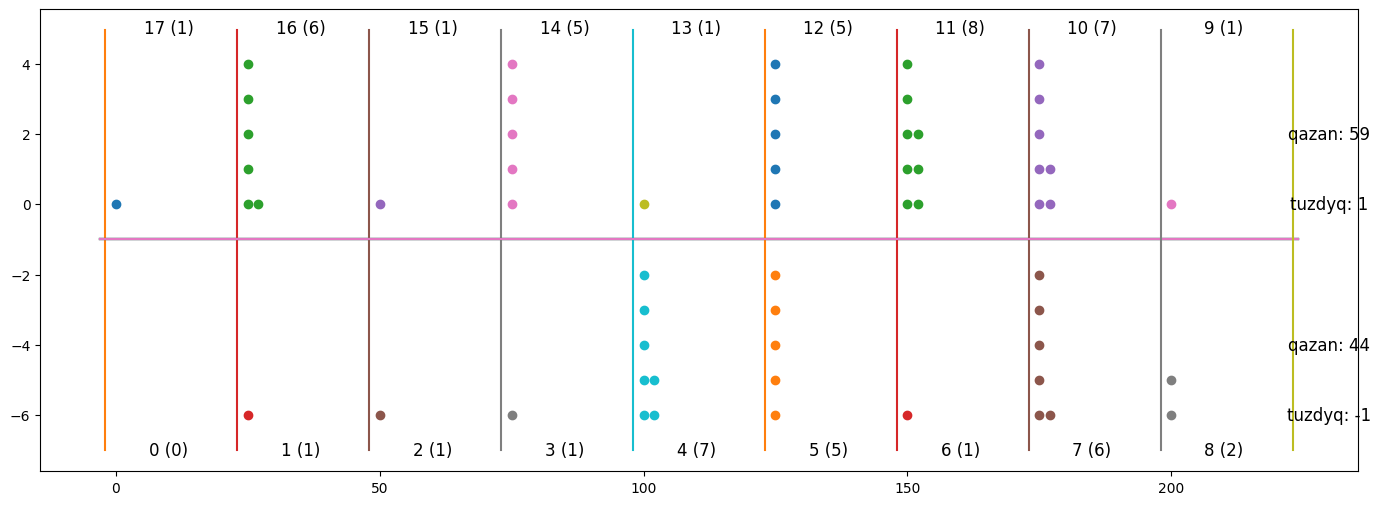

Player 0 wins -1.
Player 0 make action 0


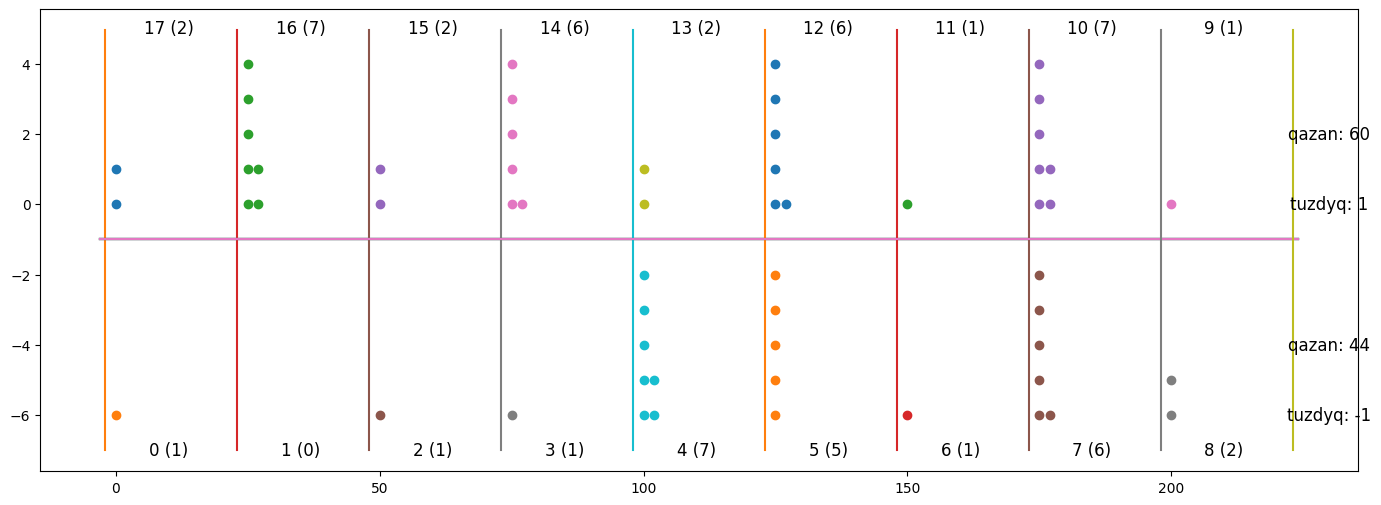

Player 1 make action 17


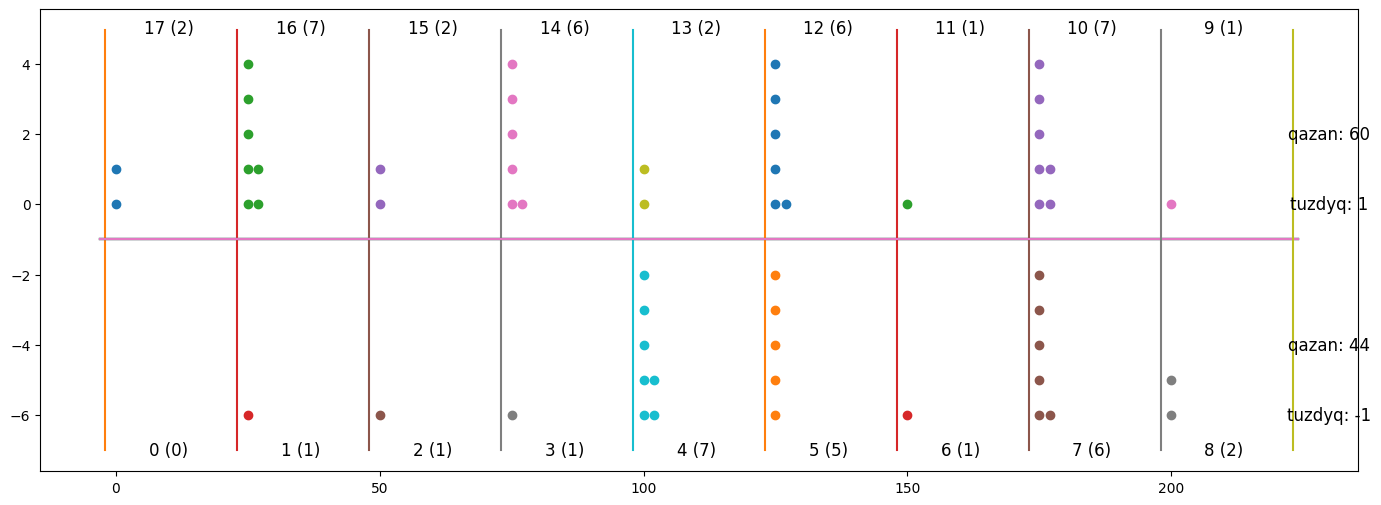

Player 0 wins -1.
Player 0 make action 5


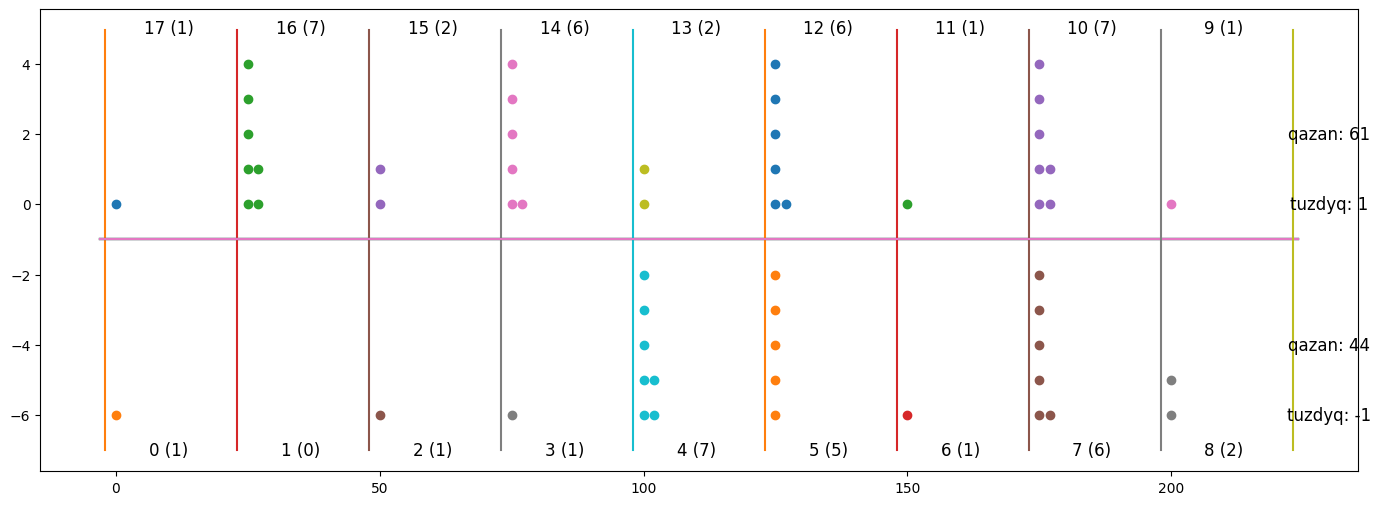

Player 1 make action 14


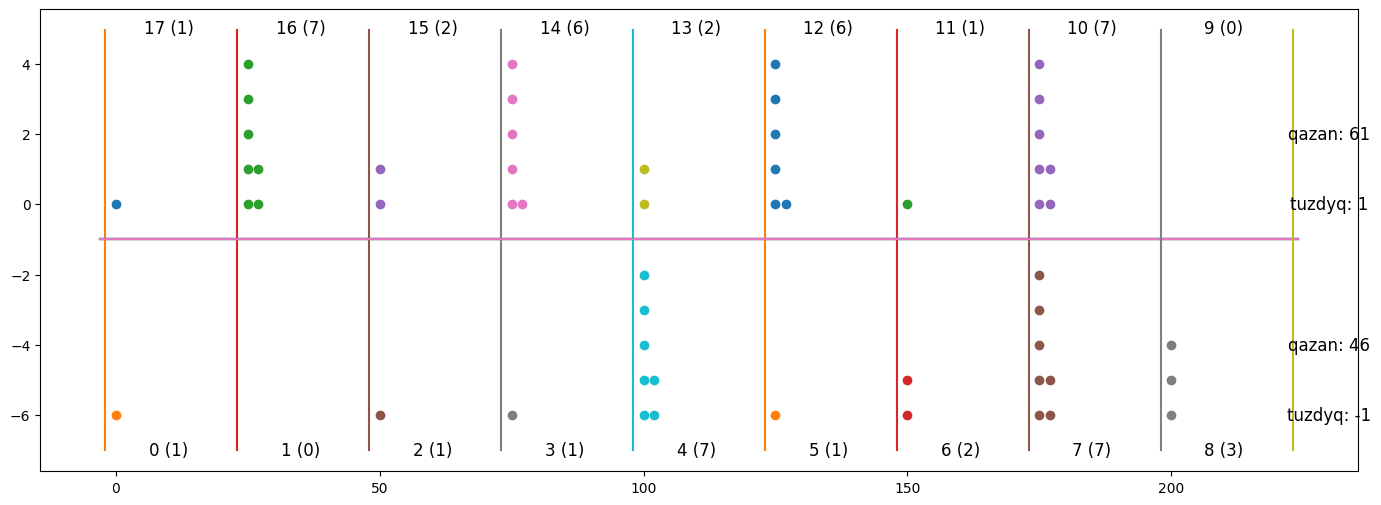

Player 0 wins 1.
Player 0 make action 0


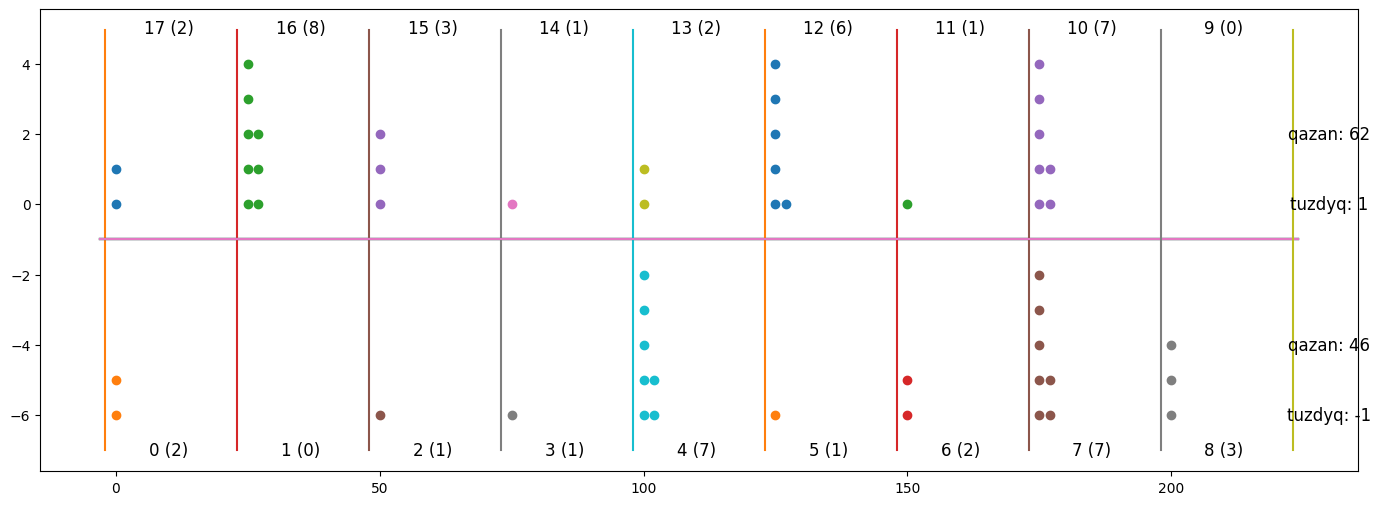

Player 1 make action 11


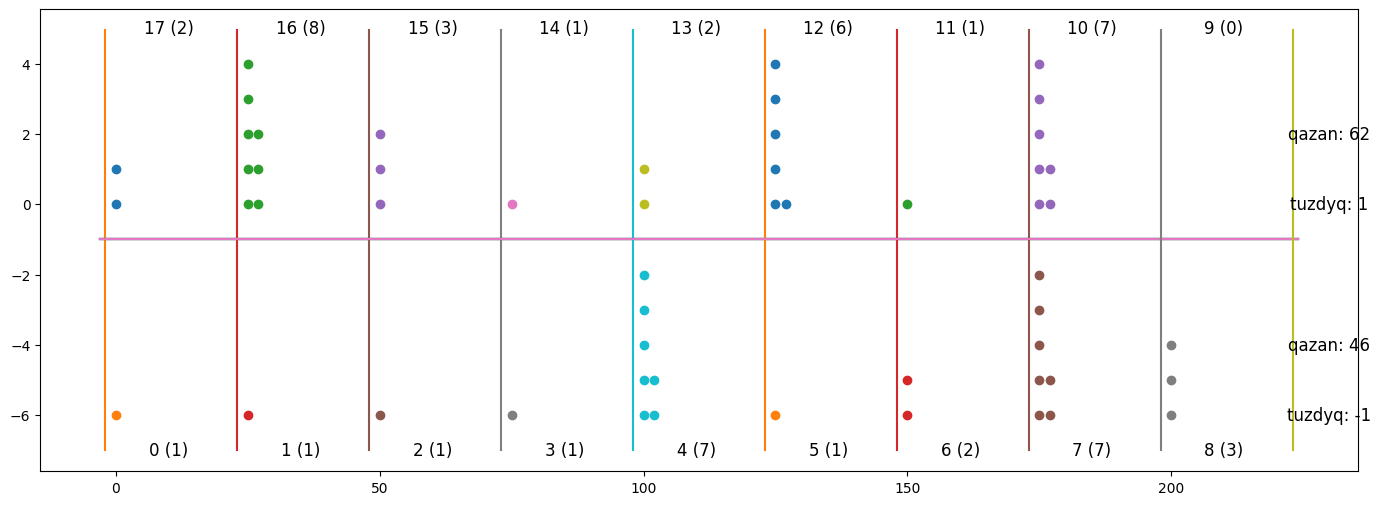

Player 0 wins -1.
Player 0 make action 0


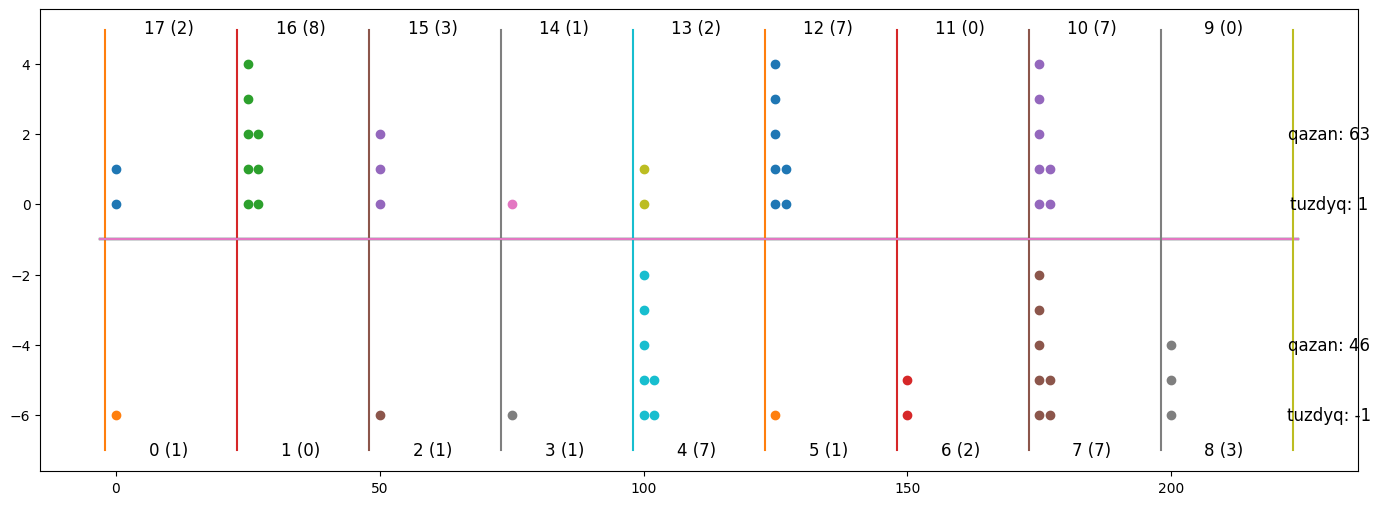

Player 1 make action 17


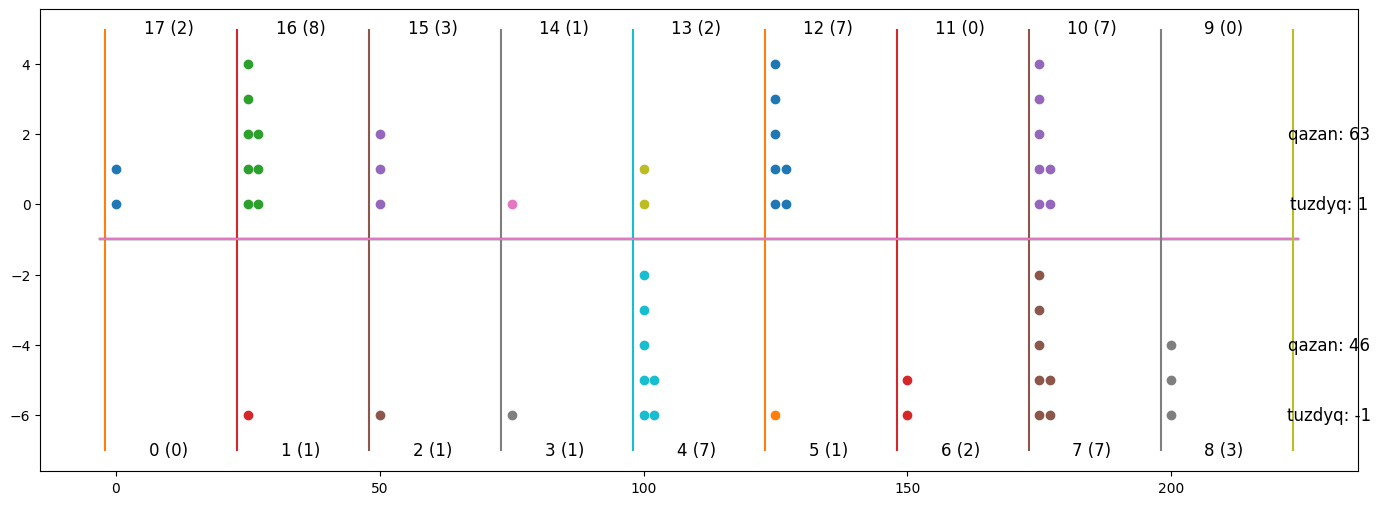

Player 0 wins -1.
Player 0 make action 0


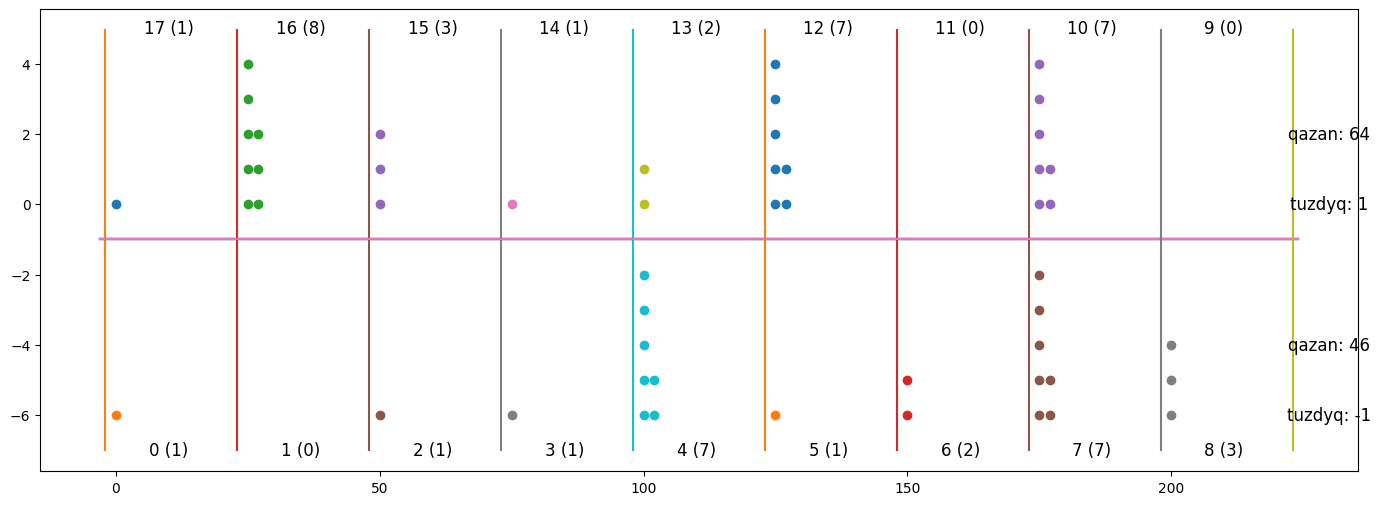

Player 1 make action 15


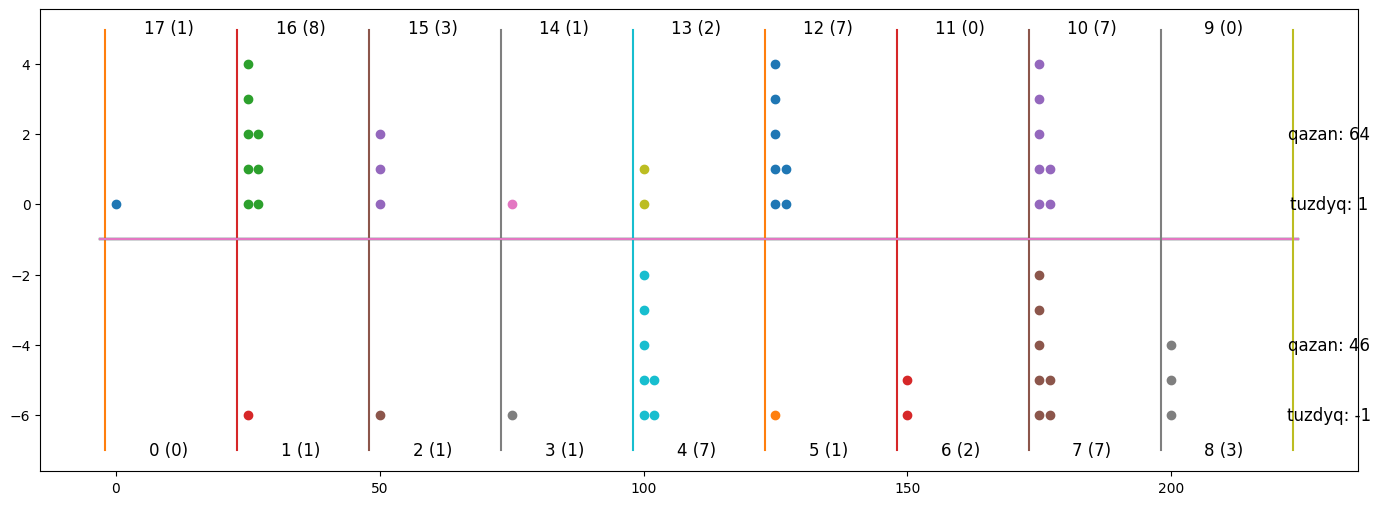

Player 0 wins -1.
Player 0 make action 7


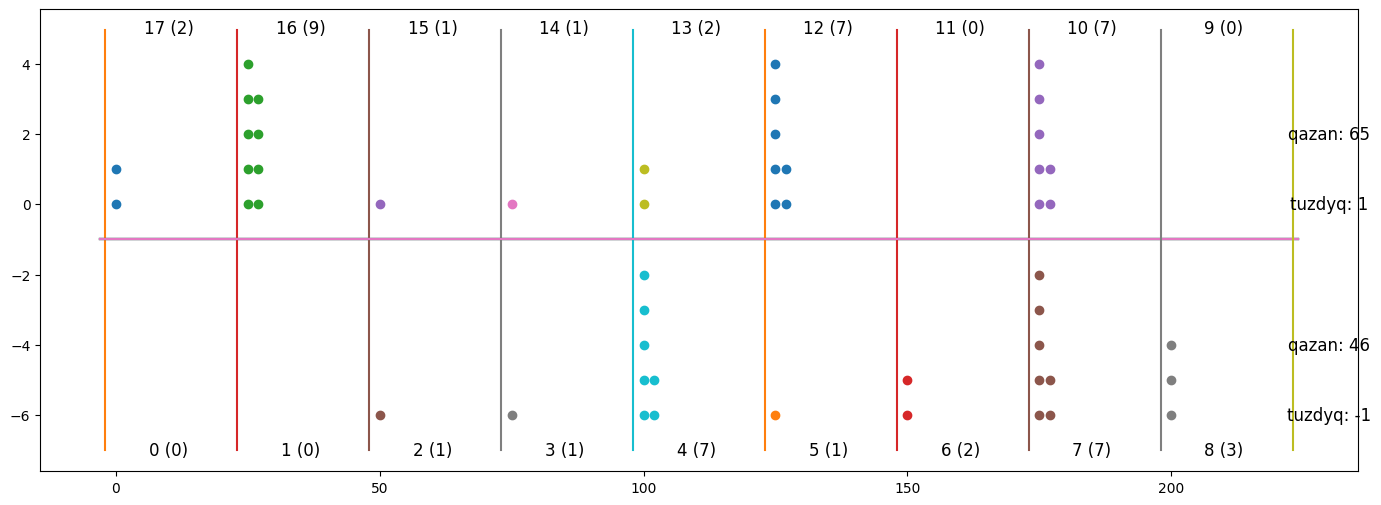

Player 1 make action 17


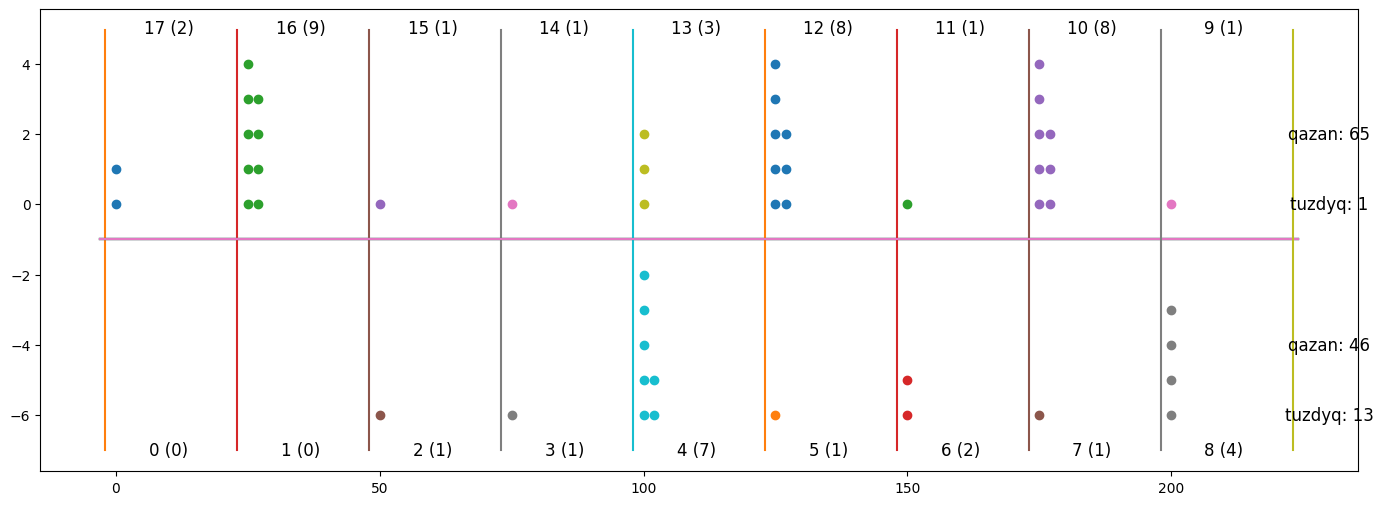

Player 0 wins 0.
Player 0 make action 0


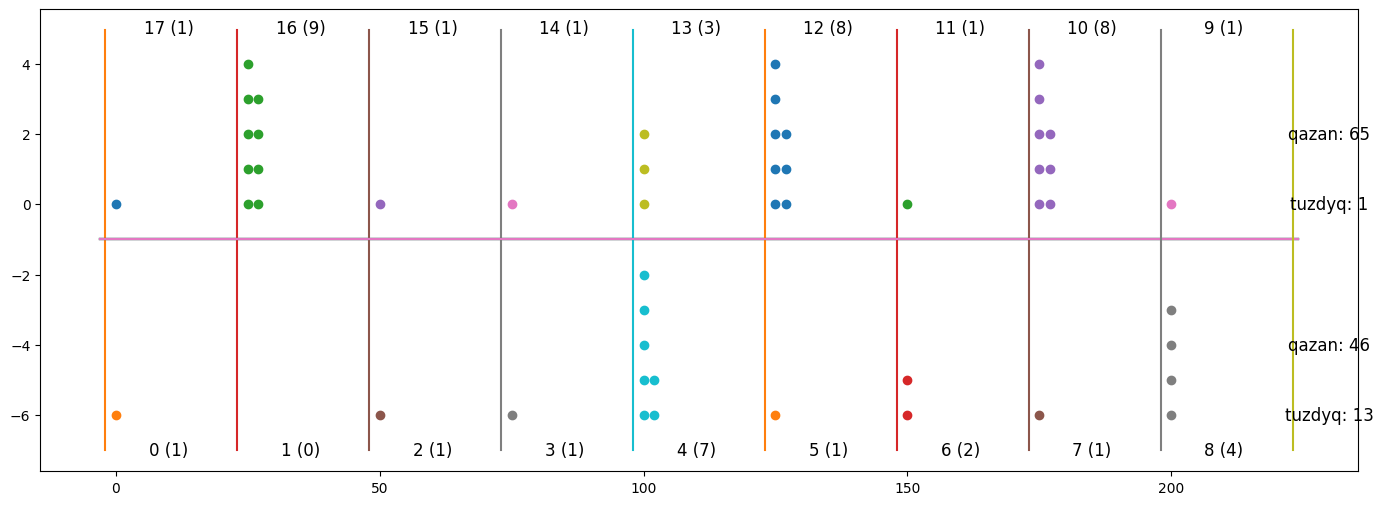

Player 1 make action 14


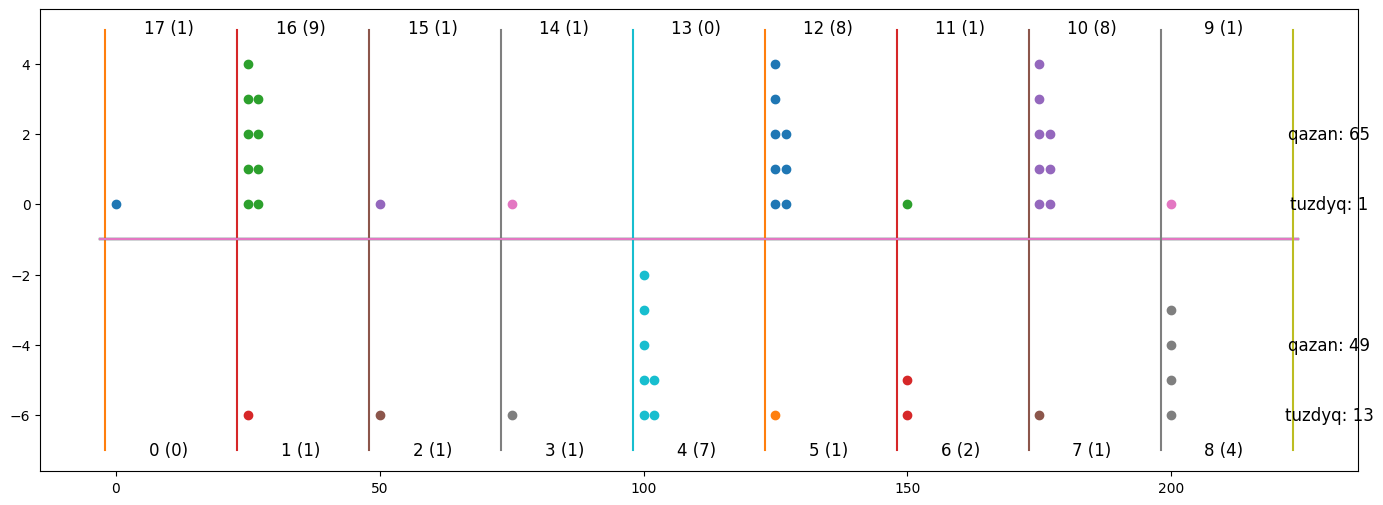

Player 0 wins 2.
Player 0 make action 7


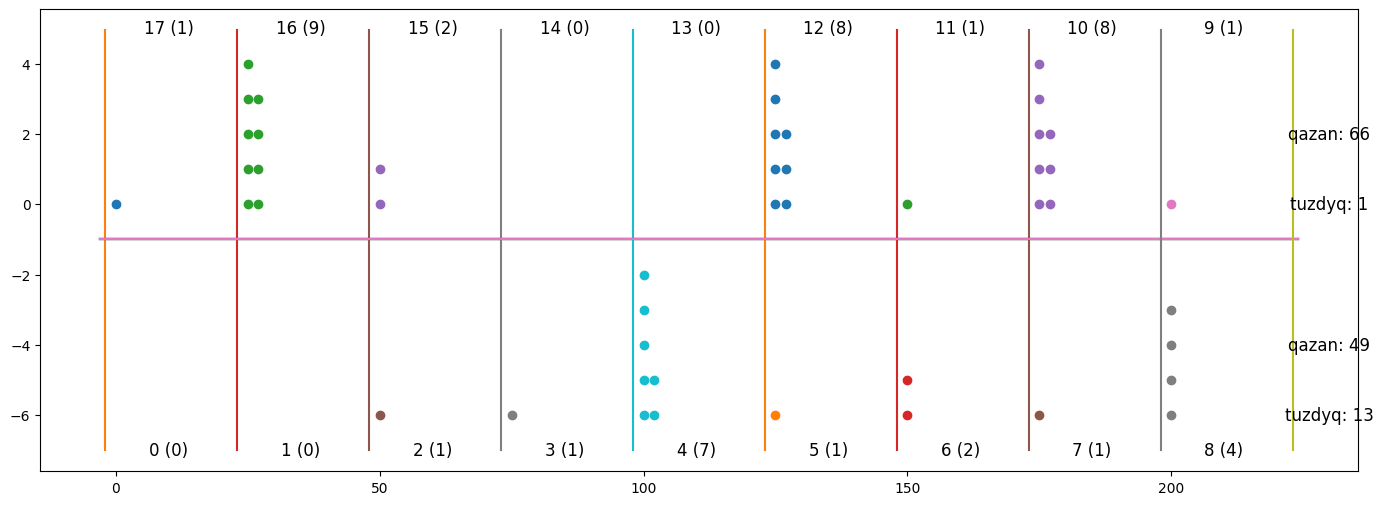

Player 1 make action 11


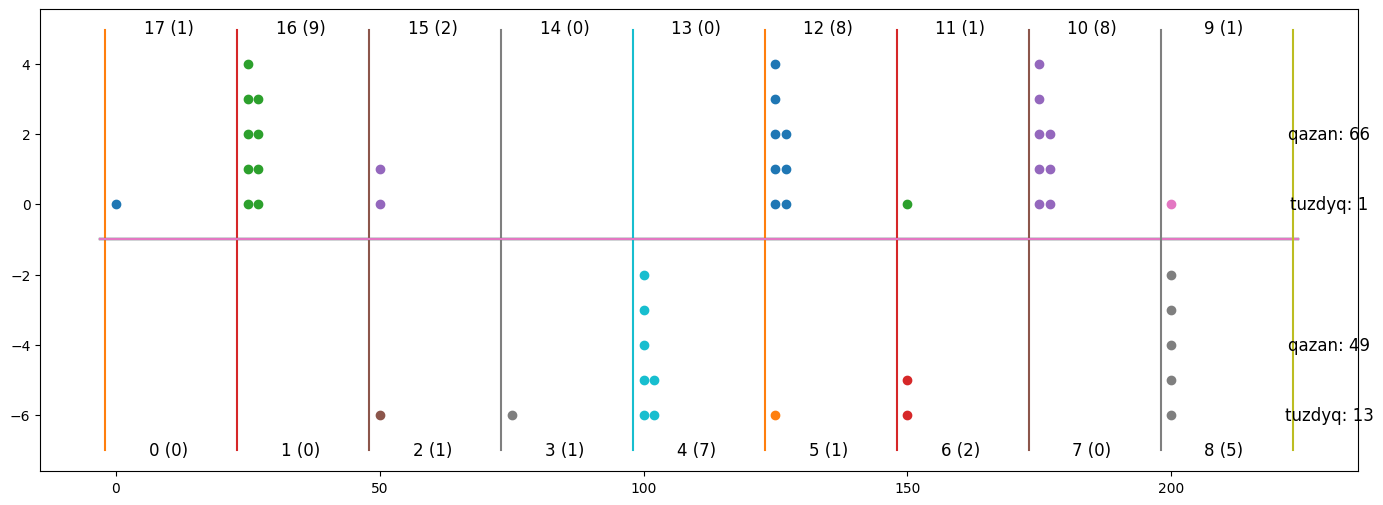

Player 0 wins 0.
Player 0 make action 4


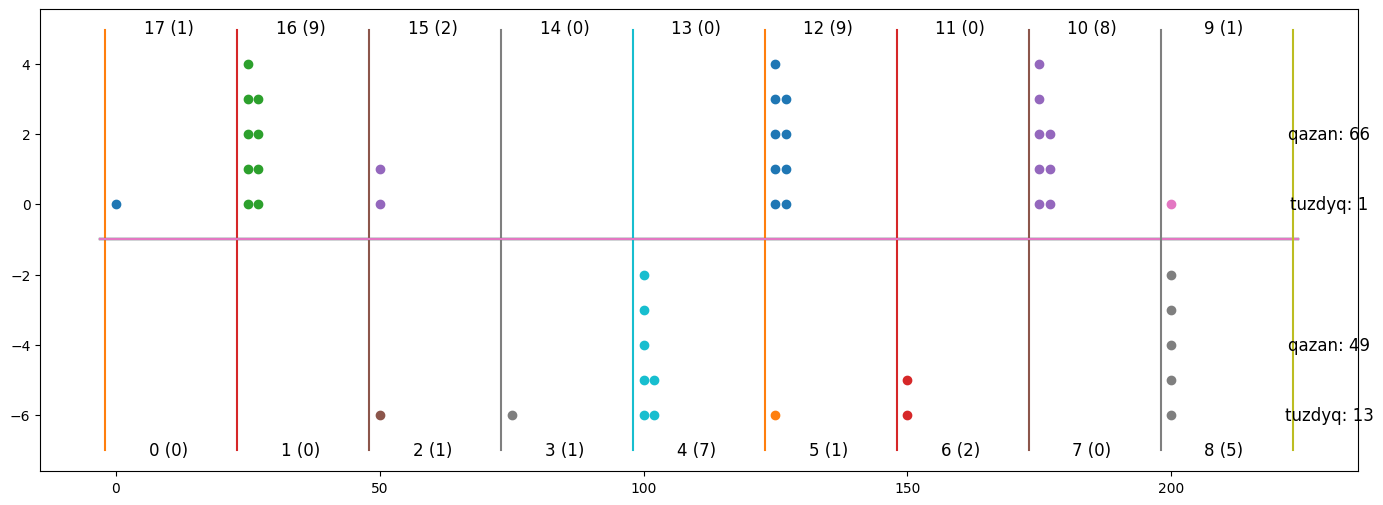

Player 1 make action 12


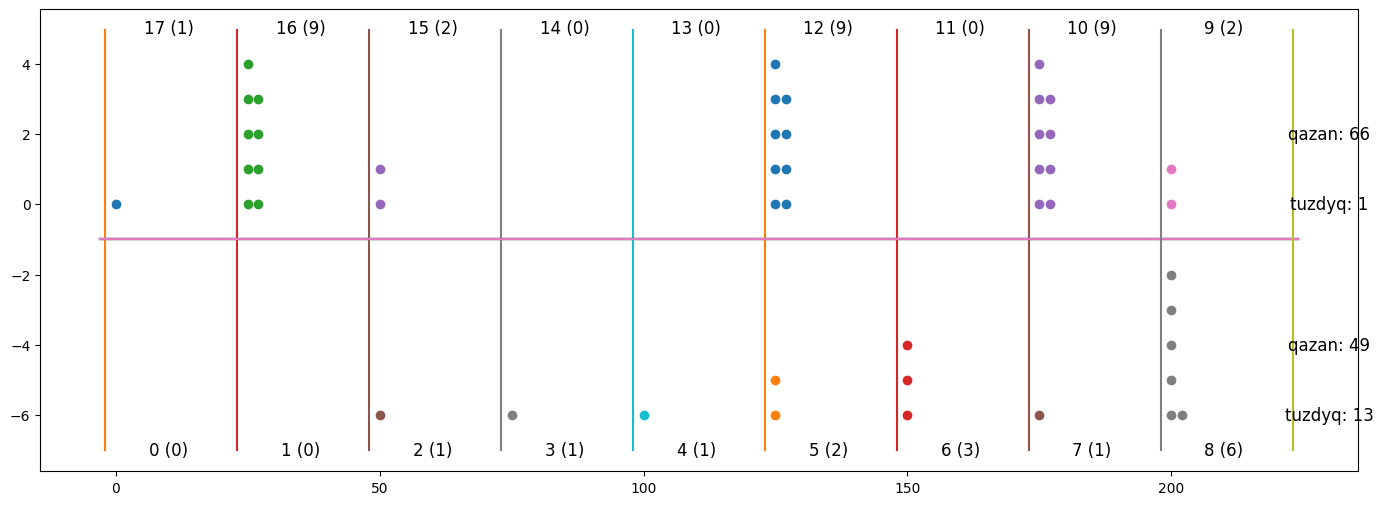

Player 0 wins -3.
Player 0 make action 6


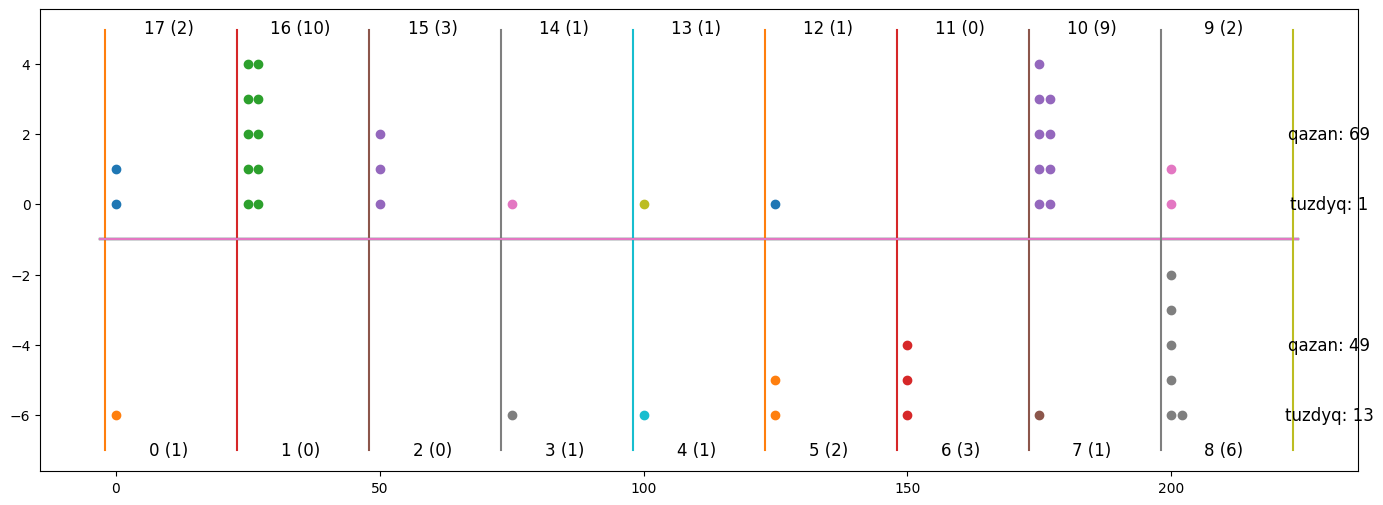

Player 1 make action 16


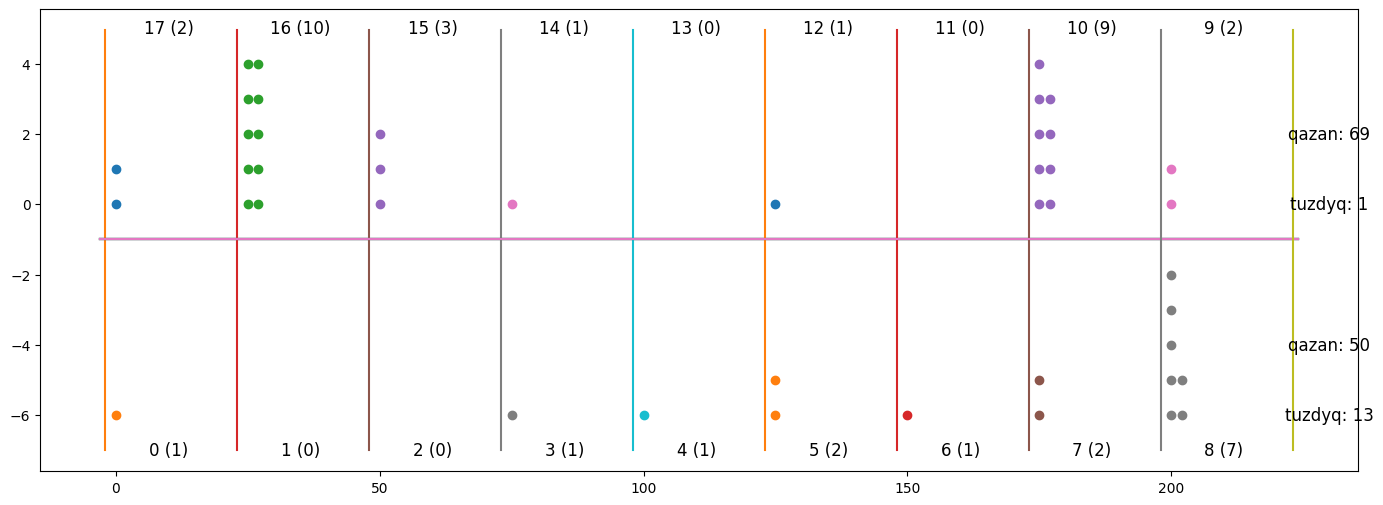

Player 0 wins 0.
Player 0 make action 5


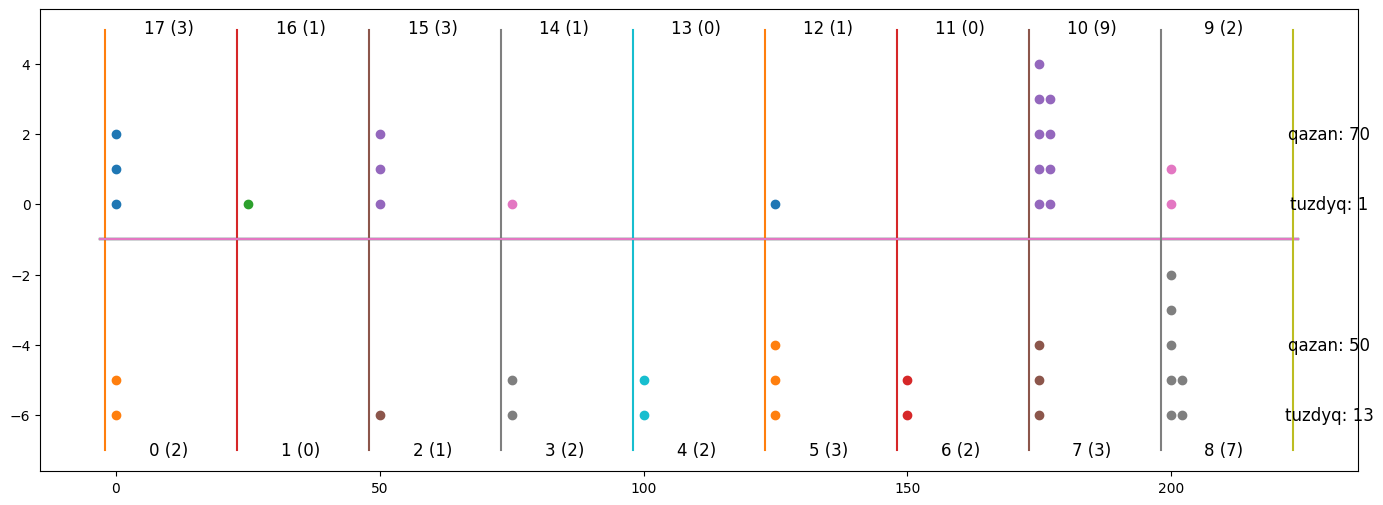

Player 1 make action 9


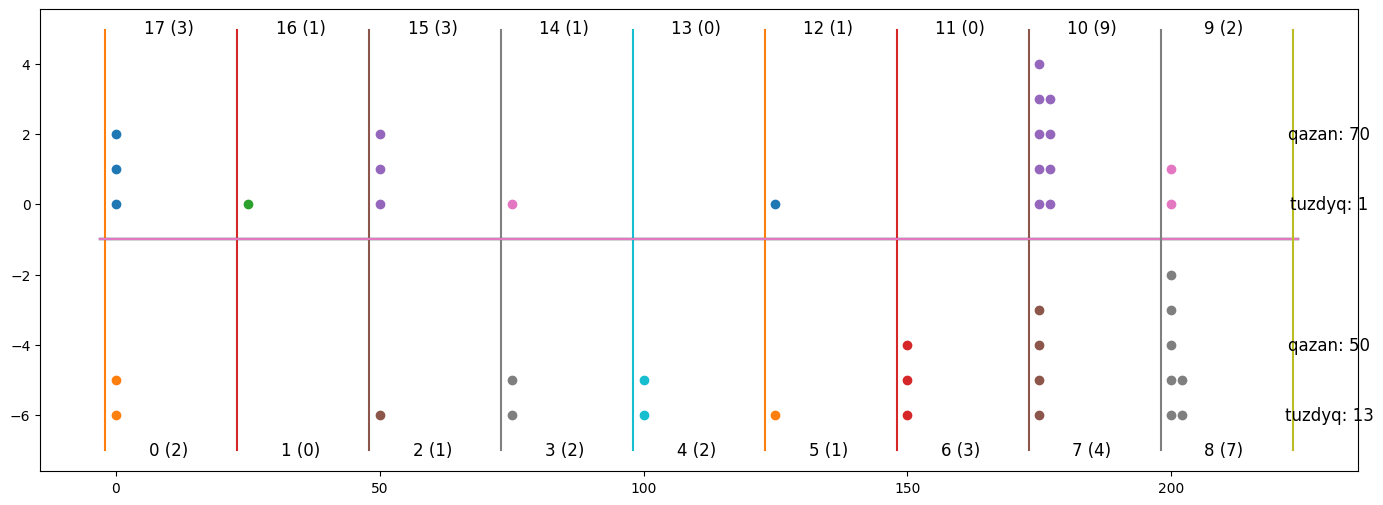

Player 0 wins 0.
Player 0 make action 7


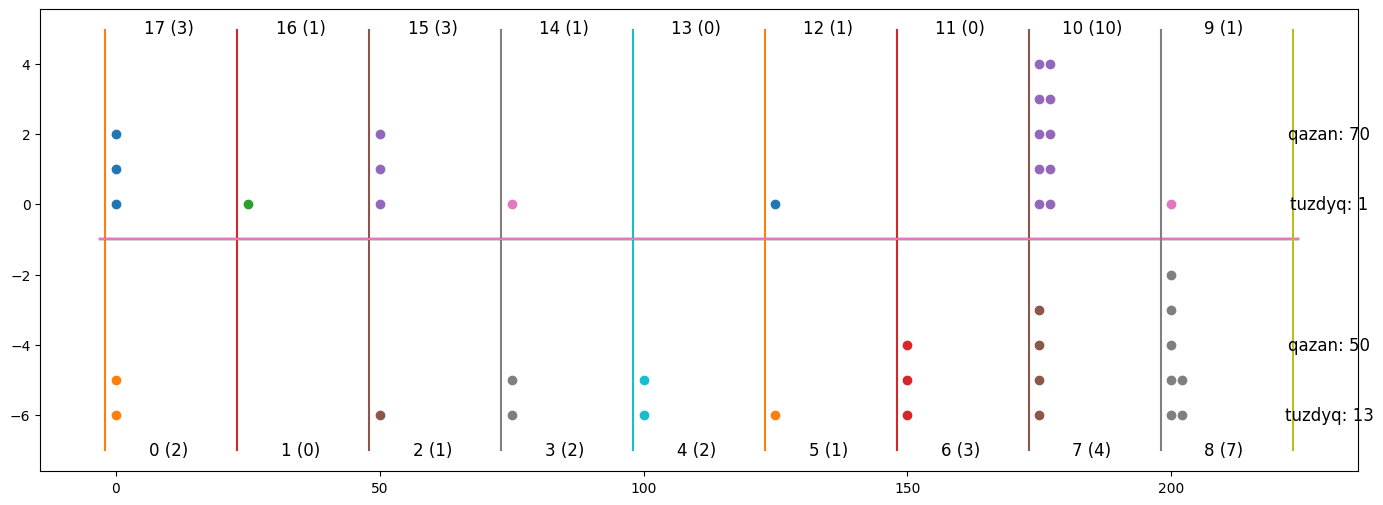

Player 1 make action 14


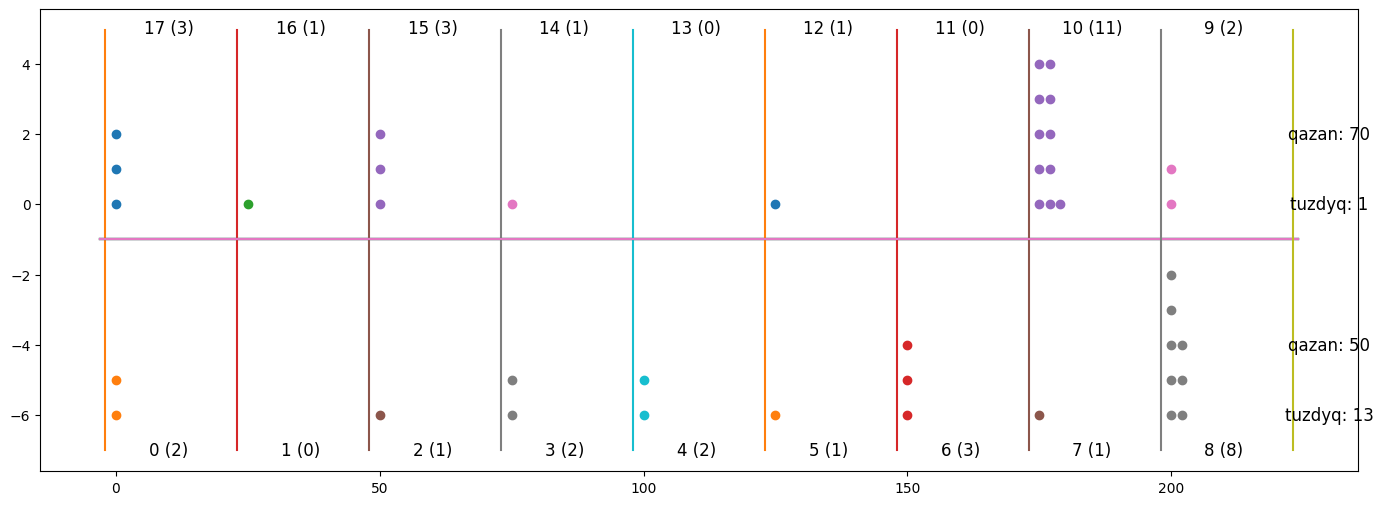

Player 0 wins 0.
Player 0 make action 4


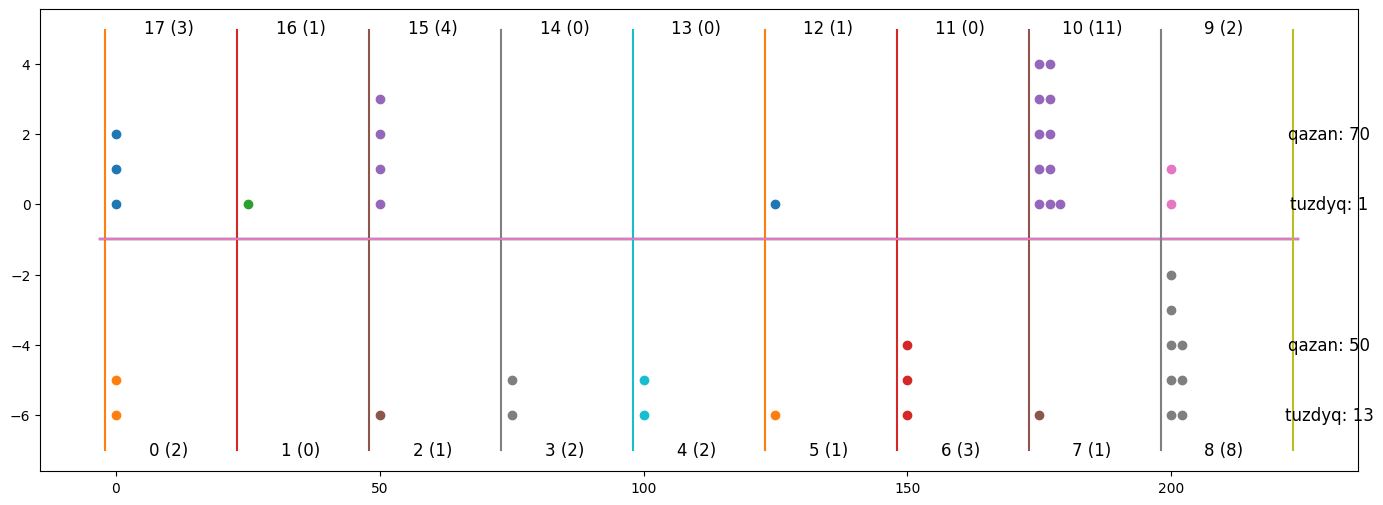

Player 1 make action 9


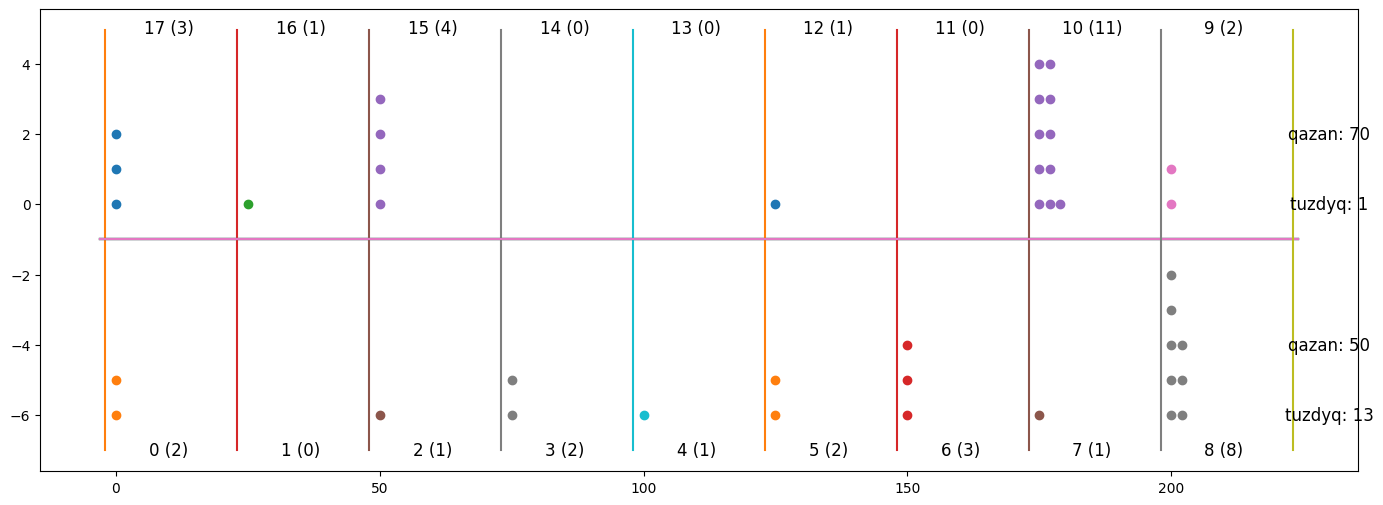

Player 0 wins 0.
Player 0 make action 6


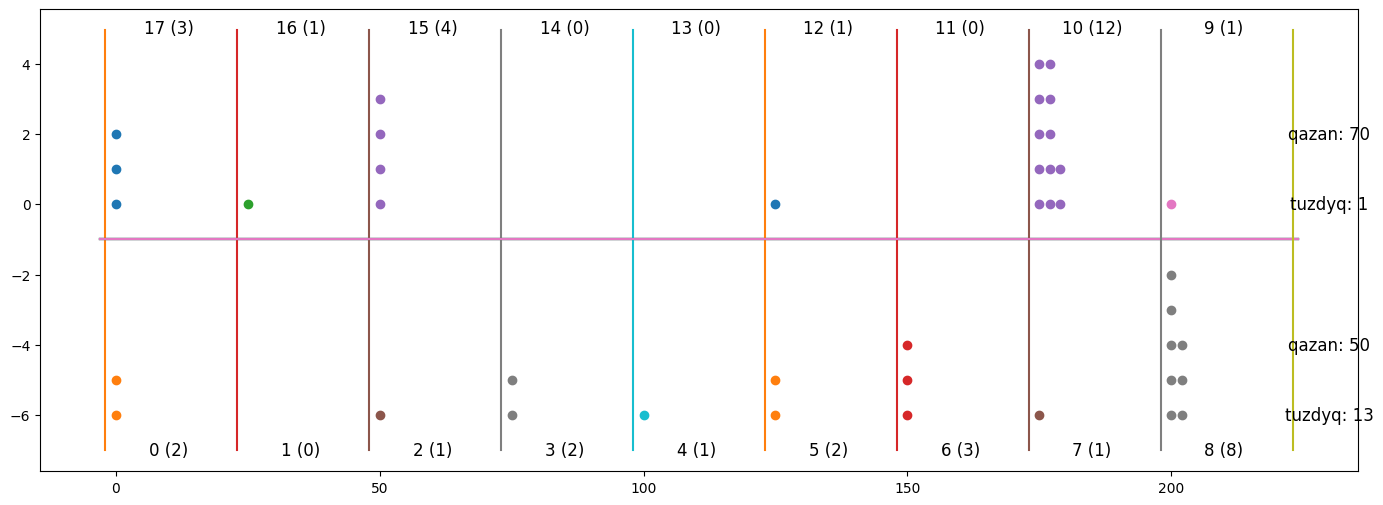

Player 1 make action 16


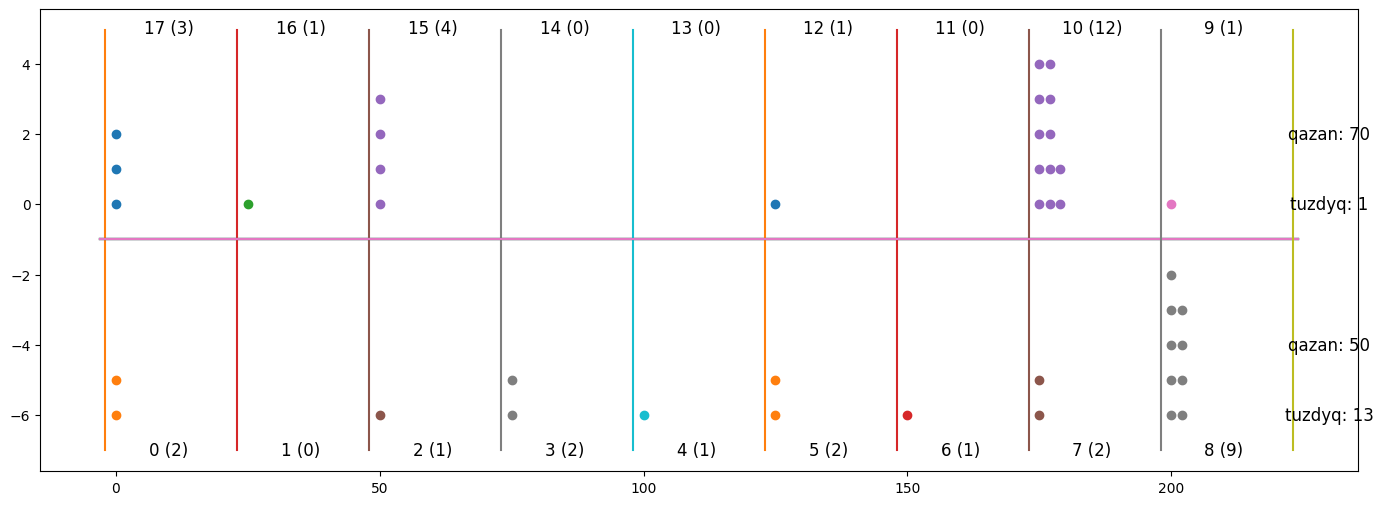

Player 0 wins 0.
Player 0 make action 8


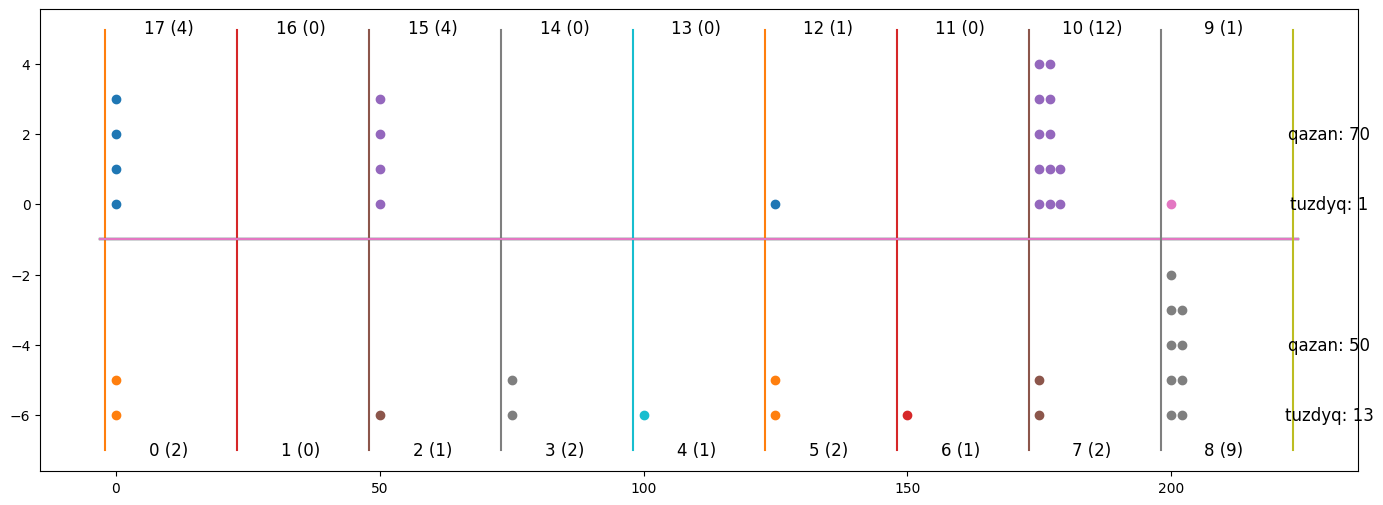

Player 1 make action 9


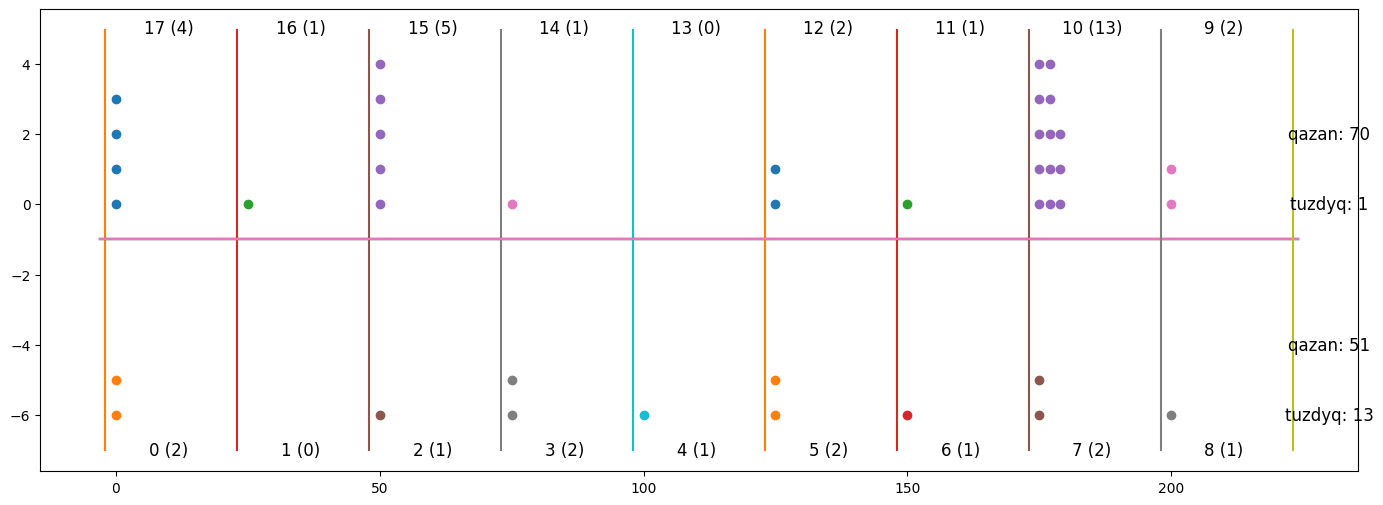

Player 0 wins 1.
Player 0 make action 0


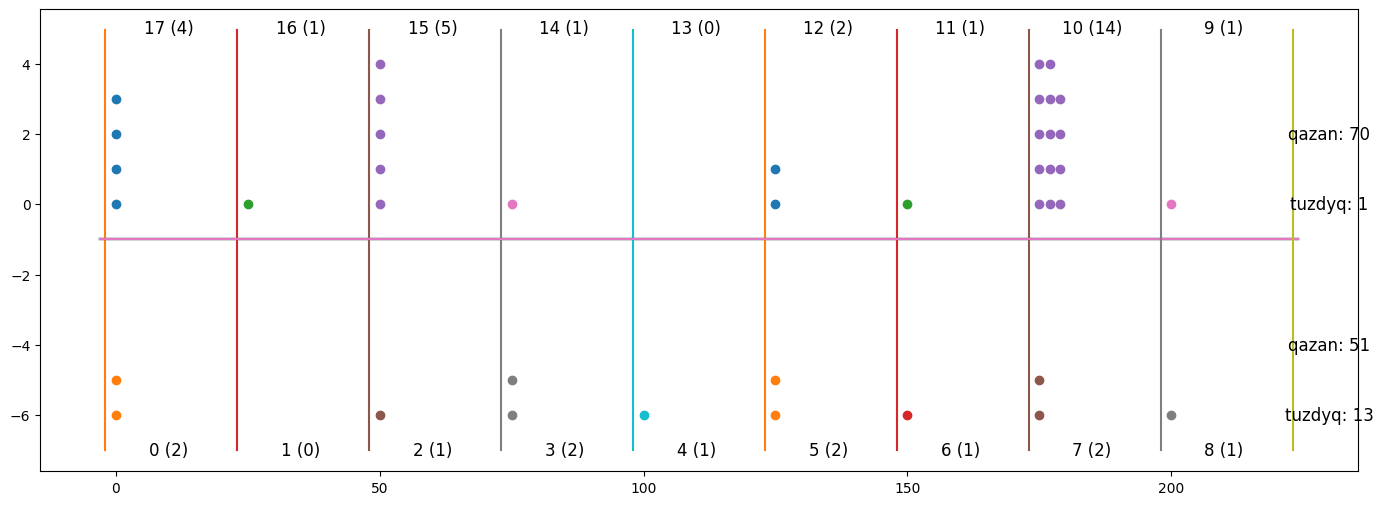

Player 1 make action 15


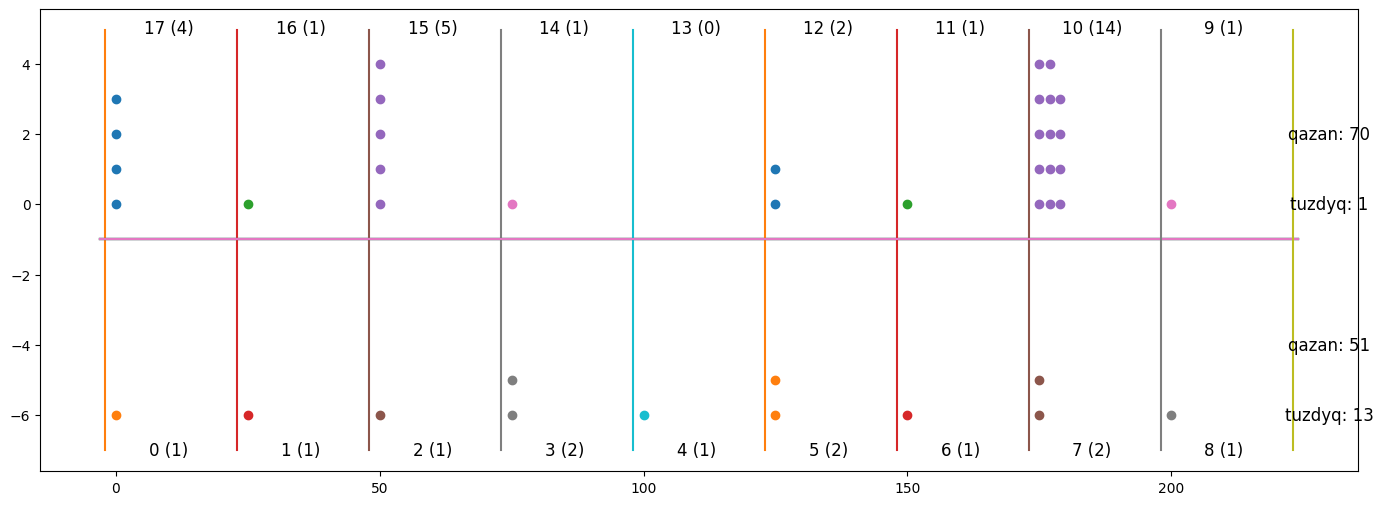

Player 0 wins -2.
Player 0 make action 0


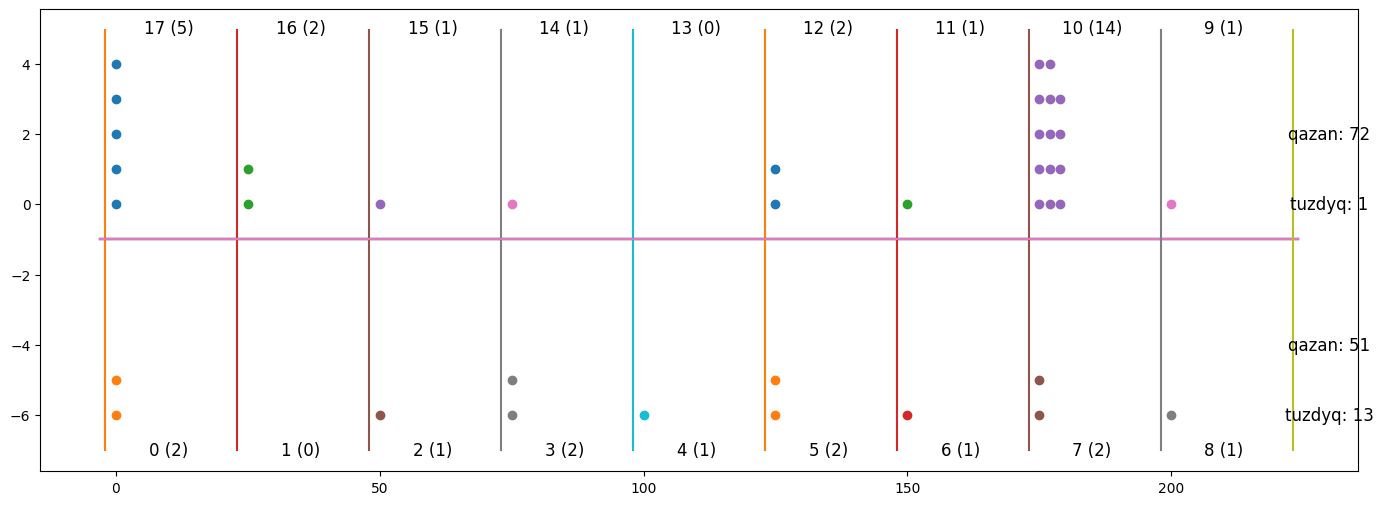

Player 1 make action 17


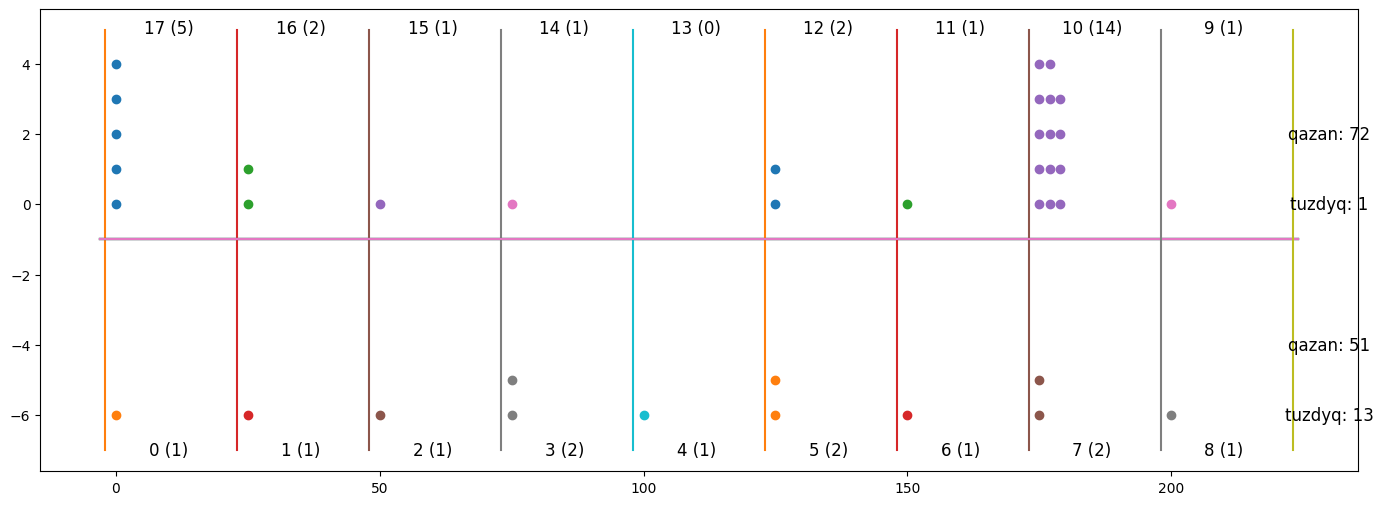

Player 0 wins -2.
Player 0 make action 4


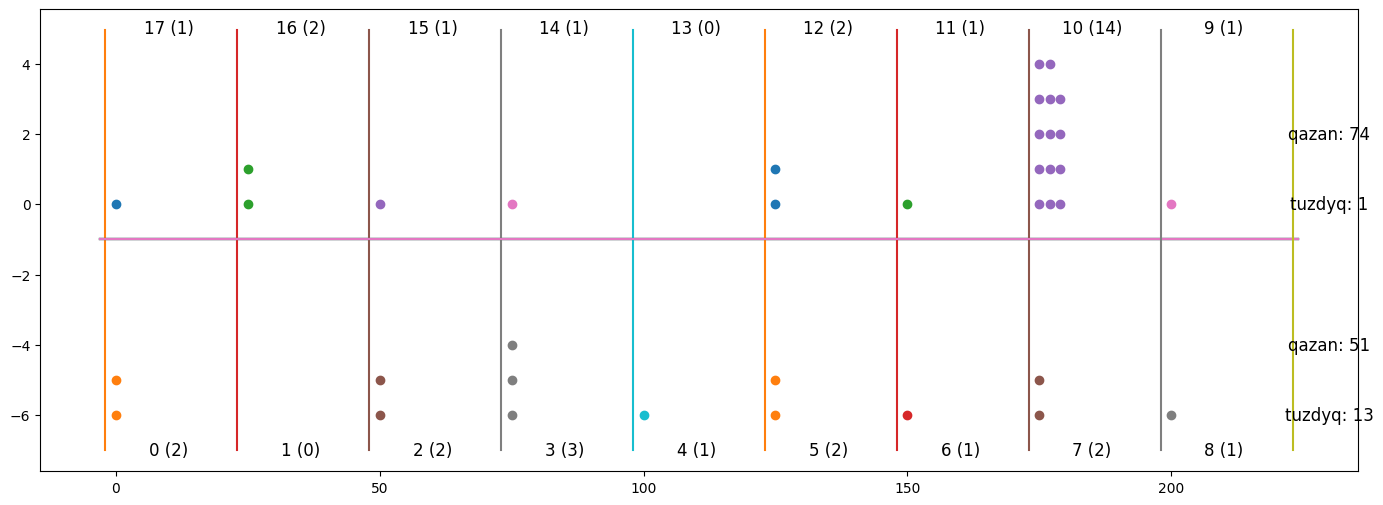

Player 1 make action 17


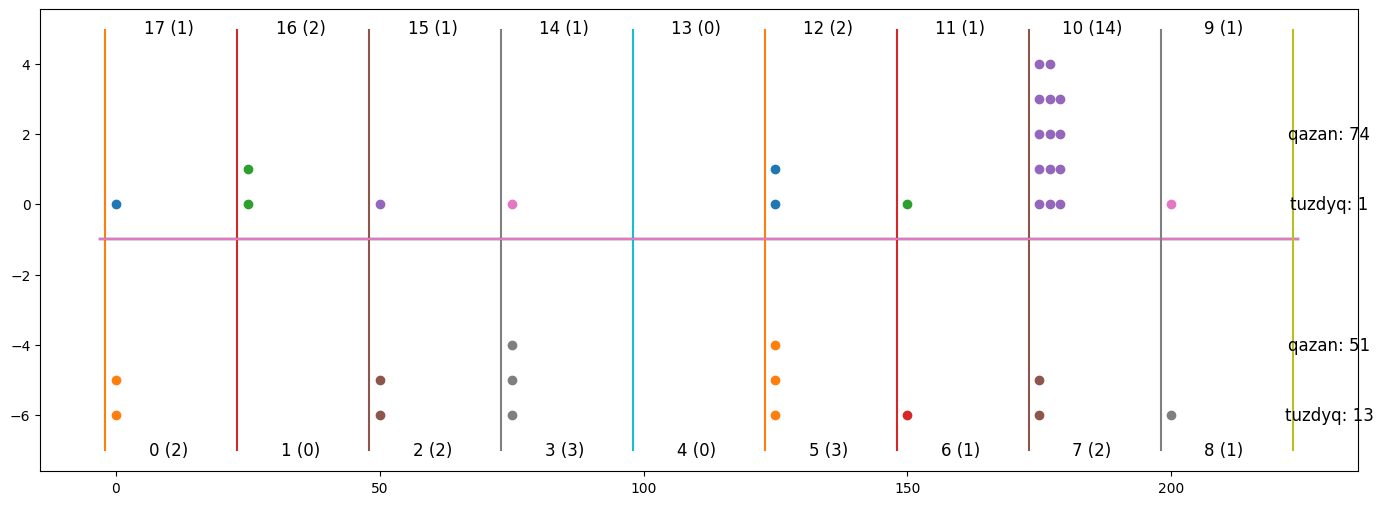

Player 0 wins 0.
Player 0 make action 8


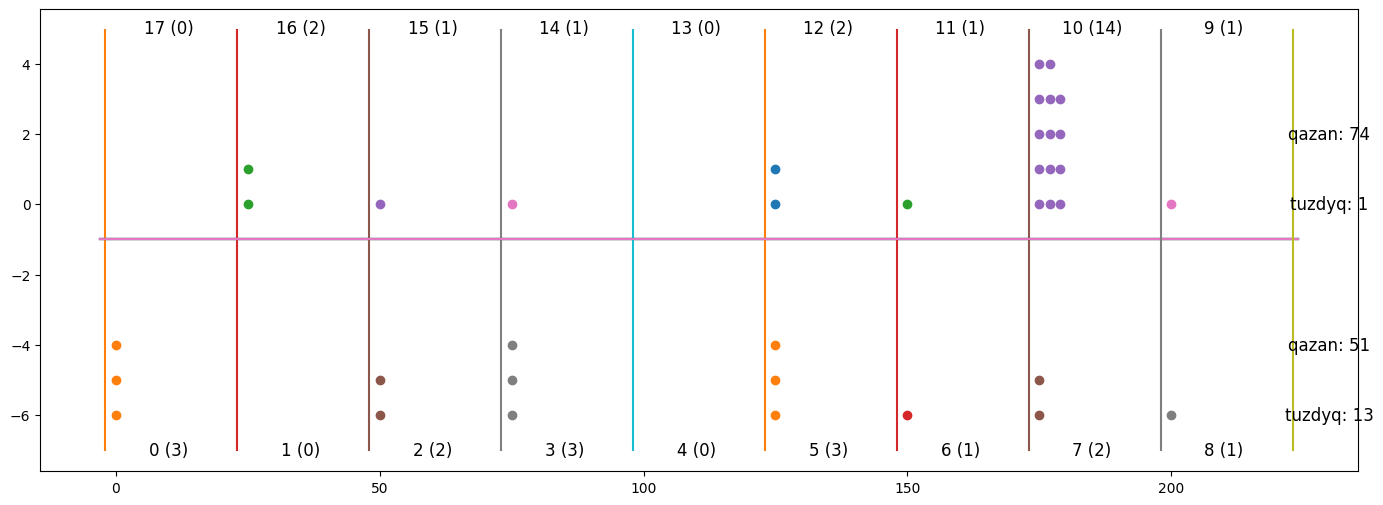

Player 1 make action 14


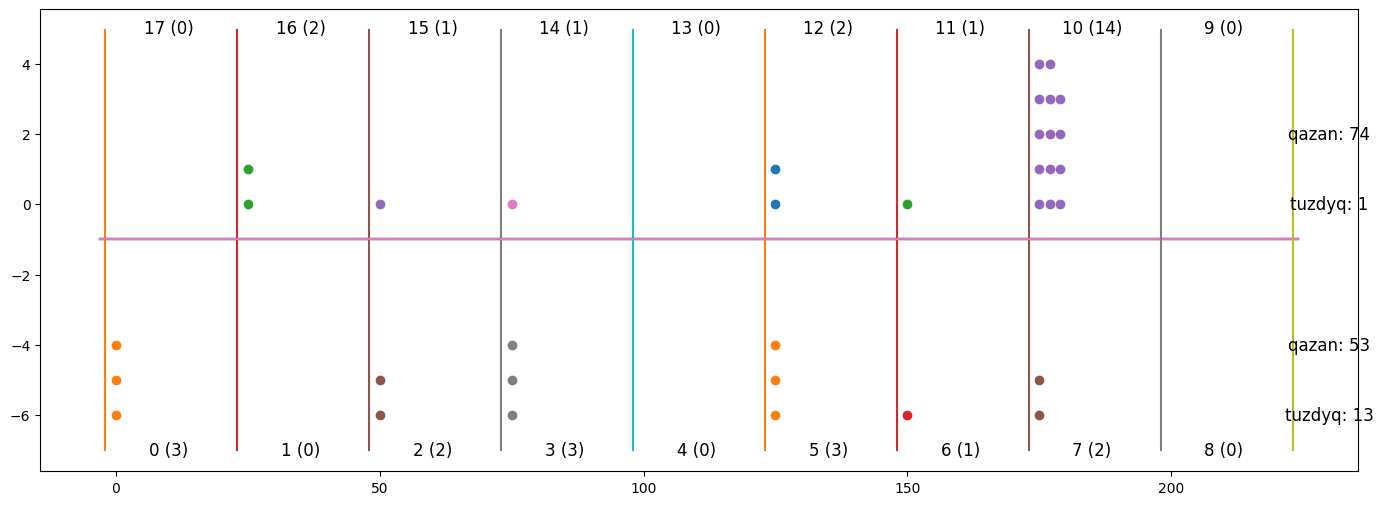

Player 0 wins 2.
Player 0 make action 0


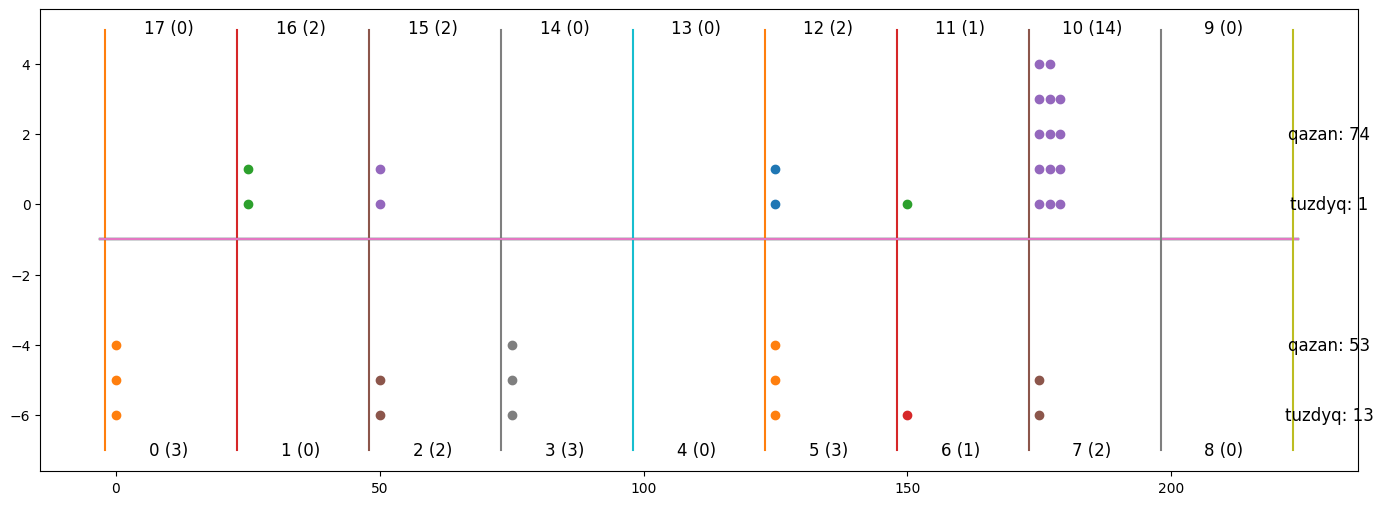

Player 1 make action 10


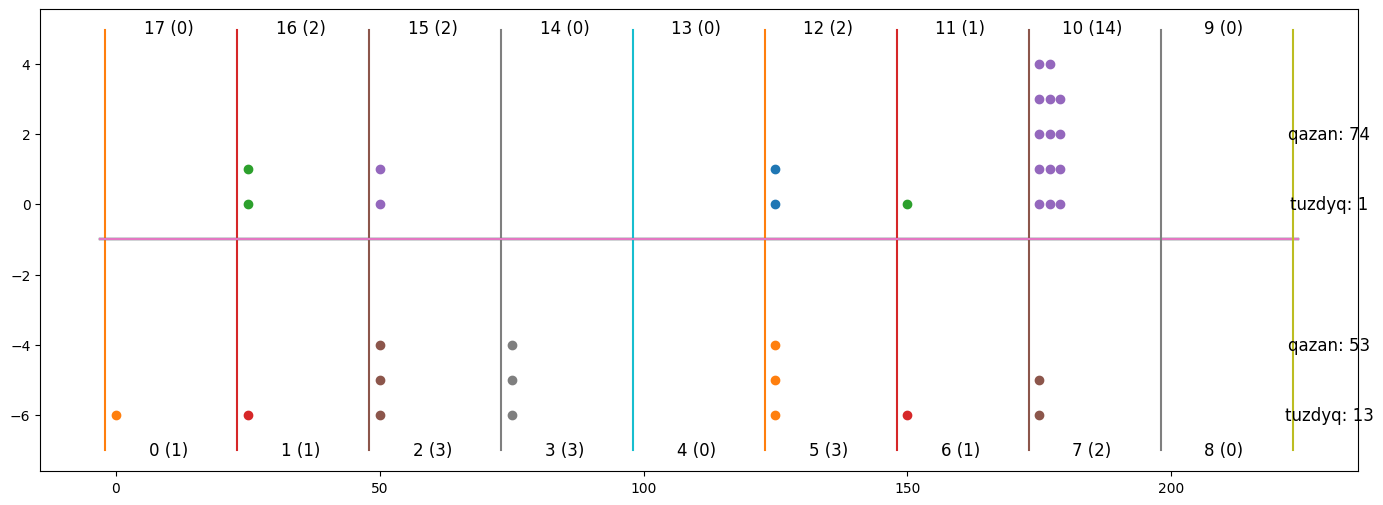

Player 0 wins -6.
Player 0 make action 4


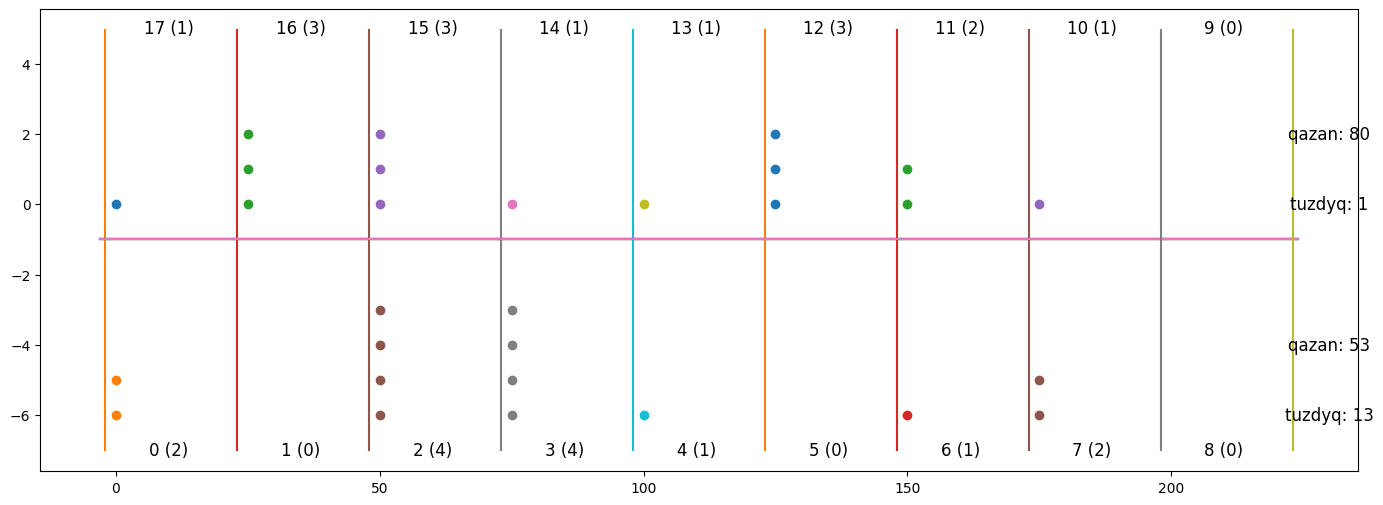

Player 1 make action 11


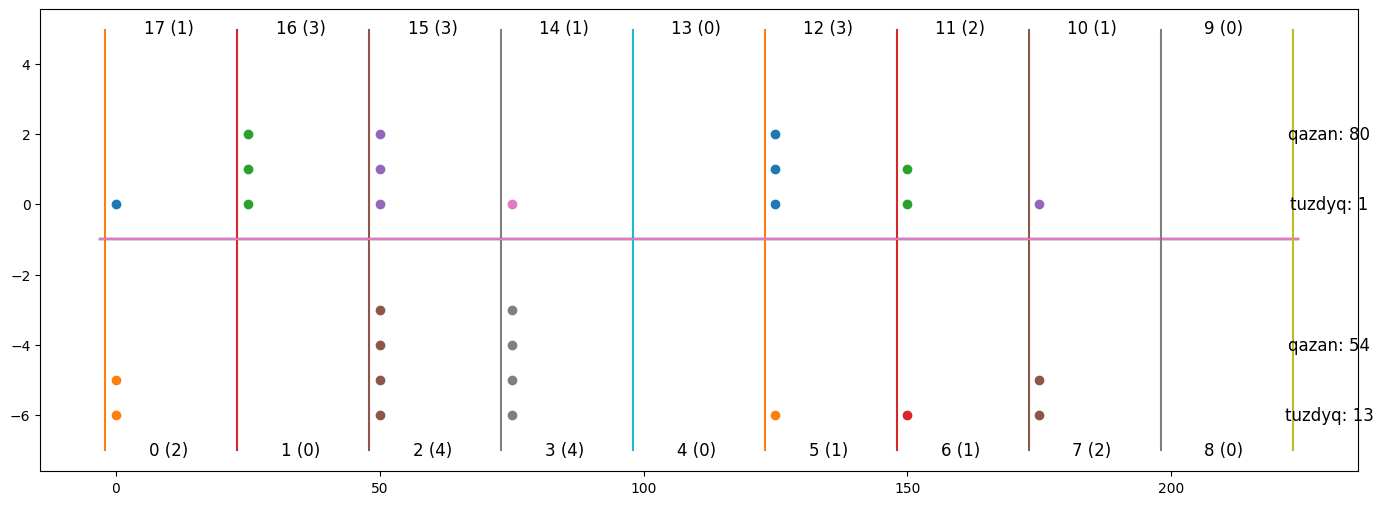

Player 0 wins 1.
Player 0 make action 7


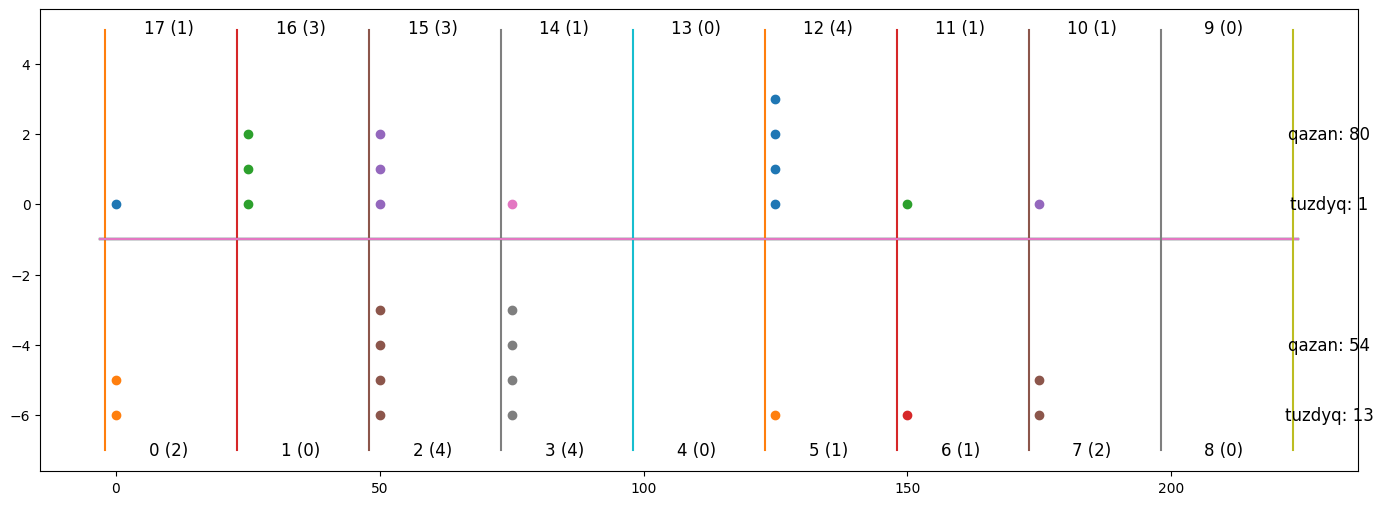

Player 1 make action 10


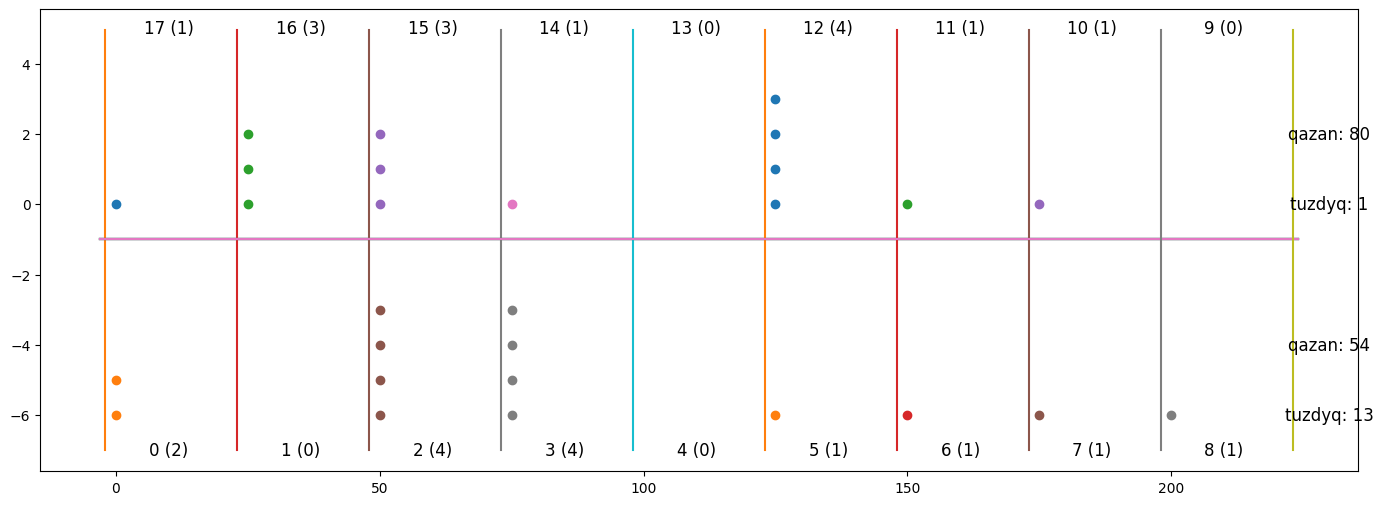

Player 0 wins 0.
Player 0 make action 0


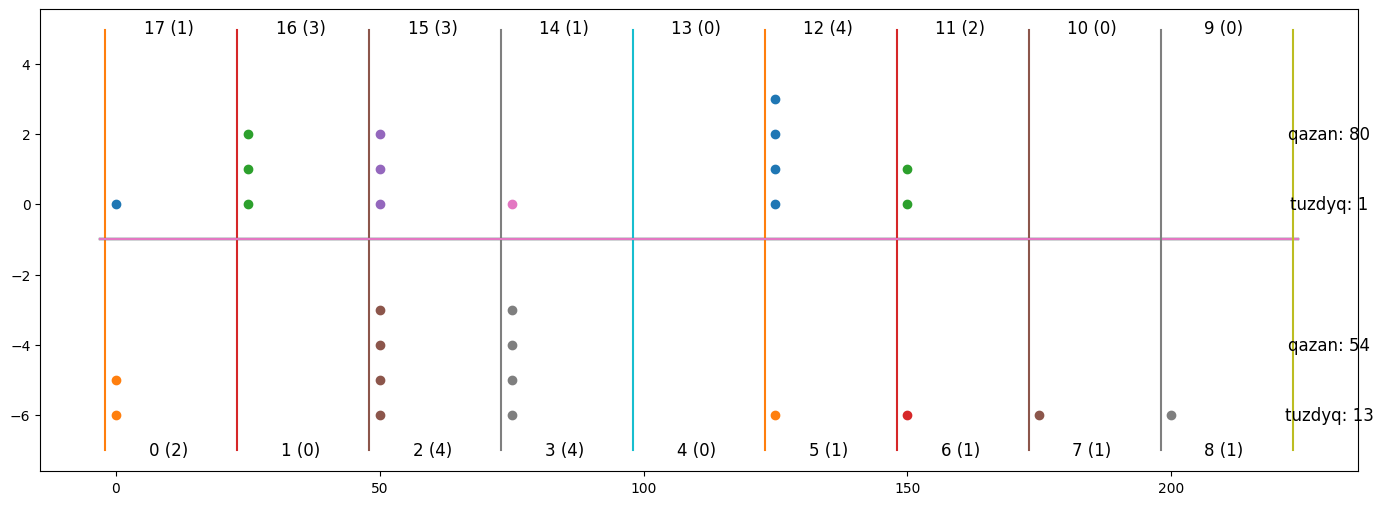

Player 1 make action 14


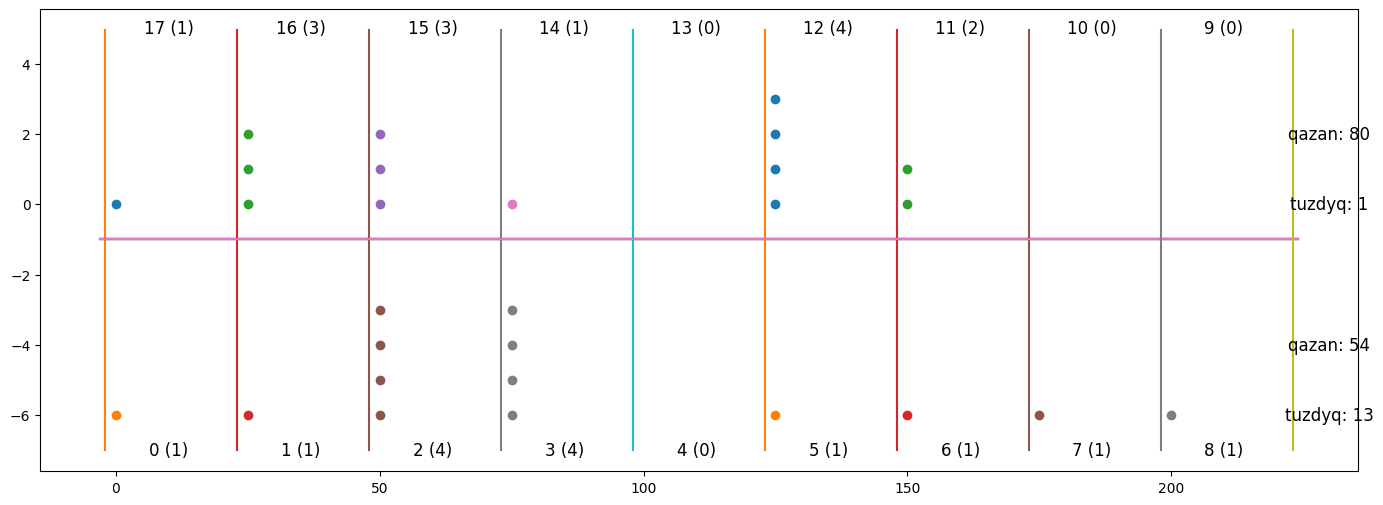

Player 0 wins -1.
Player 0 make action 0


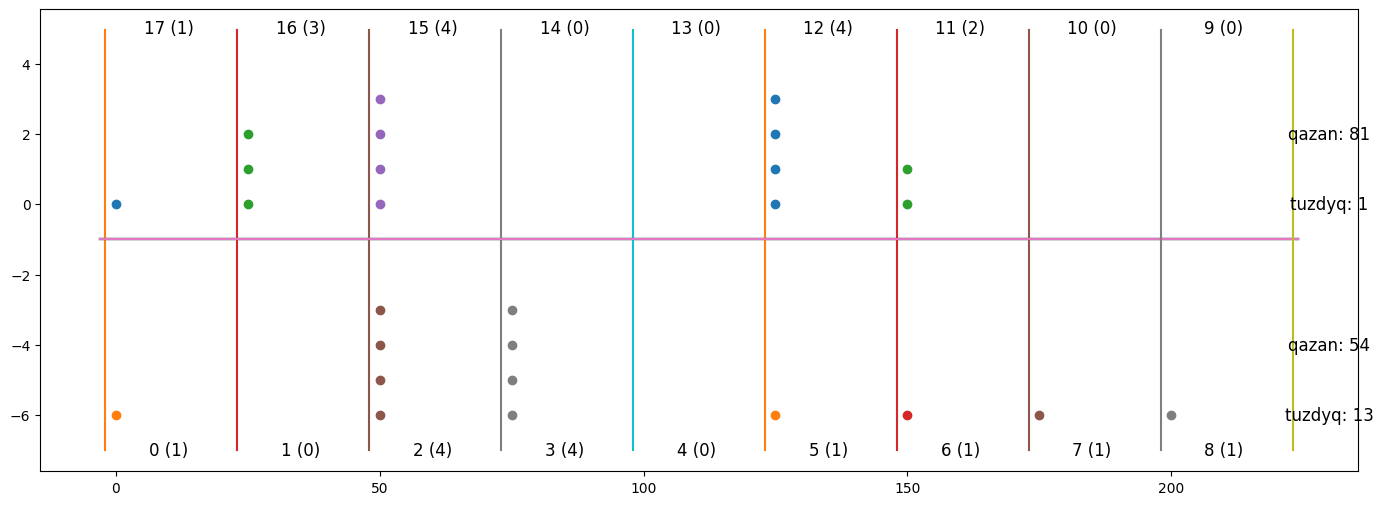

Player 1 make action 16


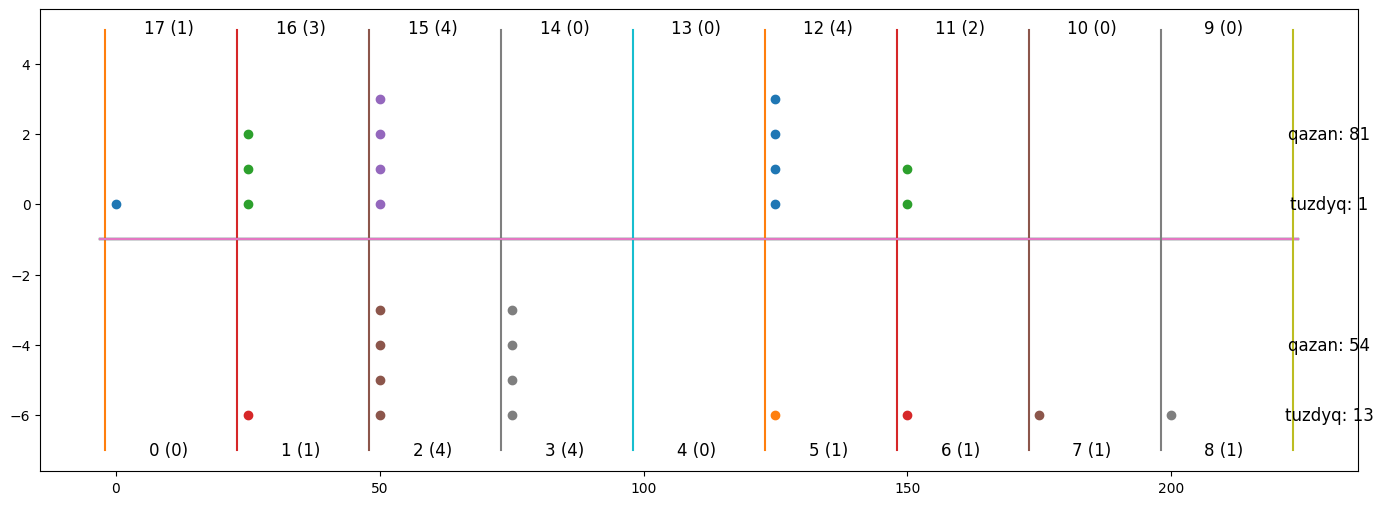

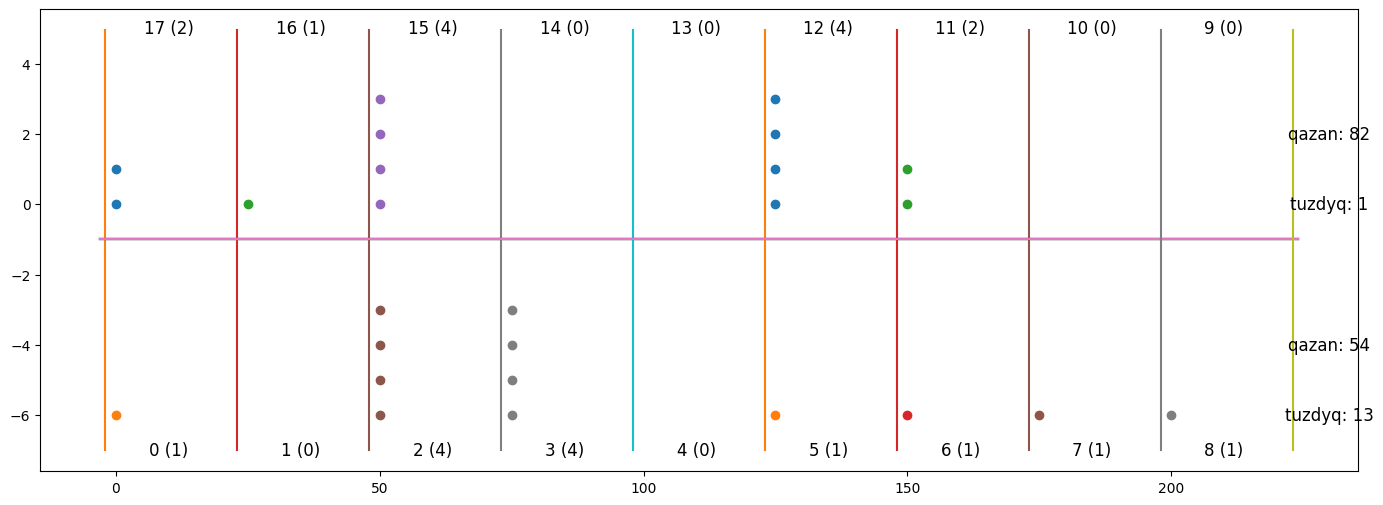

27.0

In [ ]:
evaluate(env, agent, n_games=1)

### Experience Replay

In [ ]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
        if maxsize == len(storage):
            storage.pop(0)
        storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
            # randomly generate batch_size integers
            # to be used as indexes of samples
        storage = self._storage
        ids_batch = np.random.choice(range(len(storage)), replace=False, size=batch_size)
        obs_batch = np.array([storage[i][0] for i in ids_batch])
        act_batch = np.array([storage[i][1] for i in ids_batch])
        rew_batch = np.array([storage[i][2] for i in ids_batch])
        next_obs_batch = np.array([storage[i][3] for i in ids_batch])
        done_mask = np.array([storage[i][4] for i in ids_batch])

        return (obs_batch, act_batch, rew_batch, next_obs_batch, done_mask)
            # <states>, <actions>, <rewards>, <next_states>, <is_done>

In [ ]:
# exp_replay = ReplayBuffer(10)

# for _ in range(30):
#     exp_replay.add(env.reset()[0], env.action_space.sample(),
#                    1.0, env.reset()[0], done=False)

# obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
#     5)

# assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"